# I) Import the necessary packages

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import f_oneway

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE

import os
from pathlib import Path

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                             BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, davies_bouldin_score
import scikitplot as skplt
from yellowbrick.model_selection import FeatureImportances

import joblib

import datetime as dt
from datetime import datetime as dt2
from datetime import timedelta as td
from datetime import time as tm

from sklearn.manifold import TSNE

import plotly.offline as pyoff
import plotly.graph_objs as go

import feature_engine
from feature_engine.outliers import Winsorizer

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

from sklearn.pipeline import Pipeline

# II) Get the data

## 1) Import csv file

In [6]:
full_data = pd.read_csv('credit_risk_dataset.csv')

## 2) Rename features

In [8]:
full_data = full_data.rename(columns={
    "person_age": "Age",
    "person_income": "Annual Income",
    "person_home_ownership": "Home Ownership",
    "person_emp_length": "Employment Length",
    "loan_intent": "Loan Purpose",
    "loan_grade": "Credit Grade",
    "loan_amnt": "Loan Amount",
    "loan_int_rate": "Interest Rate",
    "loan_status": "Loan Default",
    "loan_percent_income": "Loan To Income Ratio",
    "cb_person_default_on_file": "Has Prior Default",
    "cb_person_cred_hist_length": "Credit History Length"
})

## 3) Split the data into training and test sets, creating a copy of the datasets

In [10]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [11]:
train_data, test_data = data_split(full_data, 0.2)

In [12]:
train_data.shape

(26064, 12)

In [13]:
test_data.shape

(6517, 12)

In [14]:
train_data.to_csv('train.csv',index=False)

In [15]:

test_data.to_csv('test.csv',index=False)

In [16]:
# creating a copy of the dataset so that the original stays untouched
train_data_copy = train_data.copy()
test_data_copy = test_data.copy()

# III) Explore the Data

## 1) Quick glance at the data

In [19]:
full_data.head()

Age  Annual Income Home Ownership  Employment Length Loan Purpose  \
0   22          59000           RENT              123.0     PERSONAL   
1   21           9600            OWN                5.0    EDUCATION   
2   25           9600       MORTGAGE                1.0      MEDICAL   
3   23          65500           RENT                4.0      MEDICAL   
4   24          54400           RENT                8.0      MEDICAL   

  Credit Grade  Loan Amount  Interest Rate  Loan Default  \
0            D        35000          16.02             1   
1            B         1000          11.14             0   
2            C         5500          12.87             1   
3            C        35000          15.23             1   
4            C        35000          14.27             1   

   Loan To Income Ratio Has Prior Default  Credit History Length  
0                  0.59                 Y                      3  
1                  0.10                 N                      2  
2                  0.57                 N                      3  
3                  0.53                 N                      2  
4                  0.55                 Y                      4

In [20]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    32581 non-null  int64  
 1   Annual Income          32581 non-null  int64  
 2   Home Ownership         32581 non-null  object 
 3   Employment Length      31686 non-null  float64
 4   Loan Purpose           32581 non-null  object 
 5   Credit Grade           32581 non-null  object 
 6   Loan Amount            32581 non-null  int64  
 7   Interest Rate          29465 non-null  float64
 8   Loan Default           32581 non-null  int64  
 9   Loan To Income Ratio   32581 non-null  float64
 10  Has Prior Default      32581 non-null  object 
 11  Credit History Length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [21]:
full_data.describe()

Age  Annual Income  Employment Length   Loan Amount  \
count  32581.000000   3.258100e+04       31686.000000  32581.000000   
mean      27.734600   6.607485e+04           4.789686   9589.371106   
std        6.348078   6.198312e+04           4.142630   6322.086646   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.850000e+04           2.000000   5000.000000   
50%       26.000000   5.500000e+04           4.000000   8000.000000   
75%       30.000000   7.920000e+04           7.000000  12200.000000   
max      144.000000   6.000000e+06         123.000000  35000.000000   

       Interest Rate  Loan Default  Loan To Income Ratio  \
count   29465.000000  32581.000000          32581.000000   
mean       11.011695      0.218164              0.170203   
std         3.240459      0.413006              0.106782   
min         5.420000      0.000000              0.000000   
25%         7.900000      0.000000              0.090000   
50%        10.990000      0.000000              0.150000   
75%        13.470000      0.000000              0.230000   
max        23.220000      1.000000              0.830000   

       Credit History Length  
count           32581.000000  
mean                5.804211  
std                 4.055001  
min                 2.000000  
25%                 3.000000  
50%                 4.000000  
75%                 8.000000  
max                30.000000

<Axes: >

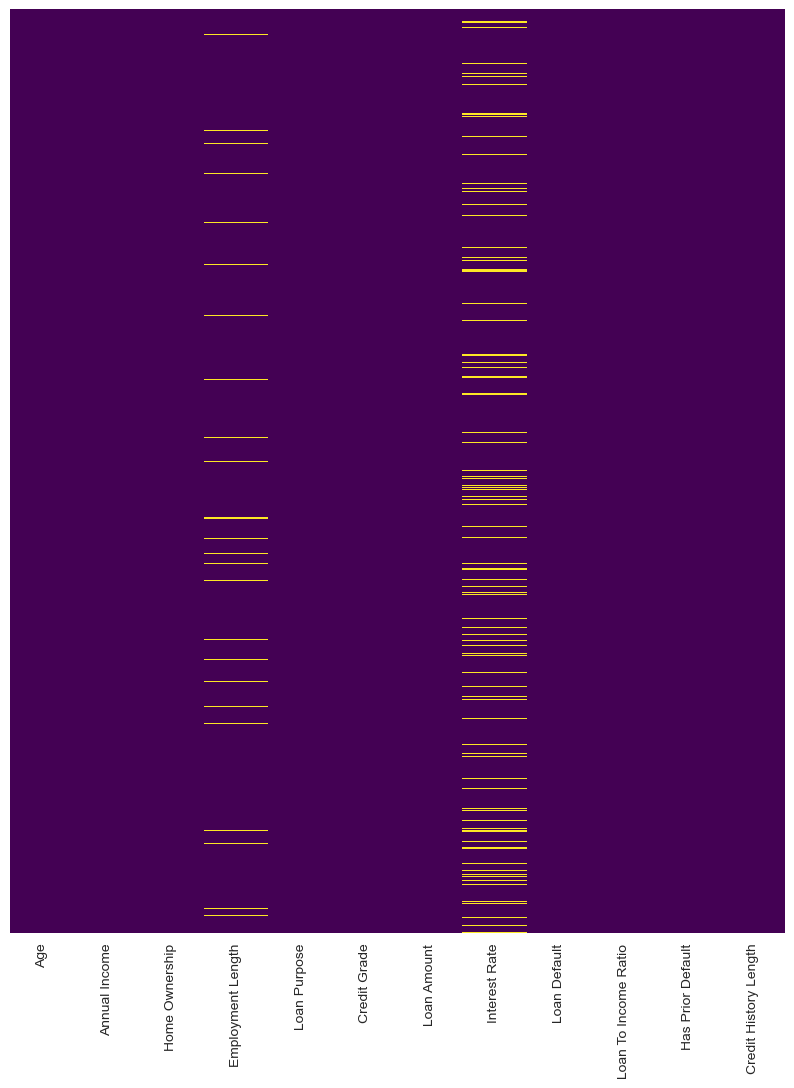

In [22]:
plt.figure(figsize=(10,12))
sns.heatmap(full_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [23]:
full_data.nunique()

Age                        58
Annual Income            4295
Home Ownership              4
Employment Length          36
Loan Purpose                6
Credit Grade                7
Loan Amount               753
Interest Rate             348
Loan Default                2
Loan To Income Ratio       77
Has Prior Default           2
Credit History Length      29
dtype: int64

In [24]:
full_data.isnull().sum()

Age                         0
Annual Income               0
Home Ownership              0
Employment Length         895
Loan Purpose                0
Credit Grade                0
Loan Amount                 0
Interest Rate            3116
Loan Default                0
Loan To Income Ratio        0
Has Prior Default           0
Credit History Length       0
dtype: int64

## 2) Functions used to explore each feature

In [26]:
#Function that will return the value count and frequency of each observation within a feature
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [27]:
# function to create display general information about the feature
def gen_info_feat(df,feature):
    match feature:
        case _:
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            value_cnt = value_cnt_norm_cal(df,feature)
            print('Value count:\n{}'.format(value_cnt))

In [28]:
# function to create a pie chart plot
def create_pie_plot(df,feature):
    match feature:
        case _:
            ratio_size = value_cnt_norm_cal(df, feature)
            ratio_size_len = len(ratio_size.index)
            ratio_list = []
            for i in range(ratio_size_len):
                ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
            fig, ax = plt.subplots(figsize=(8,8))
            # %1.2f%% display decimals in the pie chart with 2 decimal places
            plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' :'black'})
            plt.title('Pie chart of {}'.format(feature))
            plt.legend(loc='best')
            plt.axis('equal')
            return plt.show()

In [29]:
# Function to create a bar chart plot with adjusted spacing between bars
def create_bar_plot(df, feature):
    data = value_cnt_norm_cal(df, feature)
    x_labels = data.index
    y_values = data.values[:, 0]

    fig, ax = plt.subplots(figsize=(8, 10))

    sns.barplot(x=x_labels, y=y_values, ax=ax, width=0.5)  # giảm width để tạo khoảng cách

    ax.set_xticklabels(labels=x_labels, rotation=45, ha='right')

    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(f'{feature} Count')

    plt.xticks(ticks=range(len(x_labels)), labels=x_labels, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

In [30]:
# function to create a box plot
def create_box_plot(df,feature):
    match feature:
        case 'Annual Income' | 'Loan Amount':
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            # suppress scientific notation
            ax.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()

In [31]:
# function to create a histogram plot
def create_hist_plot(df,feature, the_bins=50):
    match feature:
        case 'Annual Income' | 'Loan Amount':
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            # suppress scientific notation
            ax.get_xaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()

In [32]:
# High risk vs low risk applicants compared on a box plot
def loan_box_plot(df,feature):
    match feature:
        case 'Annual Income' | 'Loan Amount':
            print(df.groupby('Loan Default')[feature].mean())
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature]),x=df['Loan Default'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            # suppress scientific notation
            ax.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            plt.title('Loan default individuals grouped by {}'.format(feature))
            return plt.show()
        case _:
            print(np.abs(df.groupby('Loan Default')[feature].mean()))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature]),x=df['Loan Default'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('Loan default individuals grouped by {}'.format(feature))
            return plt.show()

In [33]:
# High risk vs low risk applicants compared on a bar plot
def loan_bar_plot(df,feature):
    is_high_risk_grp = df.groupby(feature)['Loan Default'].sum()
    is_high_risk_grp_srt = is_high_risk_grp.sort_values(ascending=False)
    print(dict(is_high_risk_grp_srt))
    fig, ax = plt.subplots(figsize=(6,10))
    sns.barplot(x=is_high_risk_grp_srt.index,y=is_high_risk_grp_srt.values)
    ax.set_xticklabels(labels=is_high_risk_grp_srt.index,rotation=45, ha='right')
    plt.ylabel('Count')
    plt.title('Loan default applicants count grouped by {}'.format(feature))
    return plt.show()

In [34]:
train_data_copy.shape

(26064, 12)

## 3) Univariate analysis

### 3.1) Age

In [37]:
gen_info_feat(train_data_copy,'Age')

Description:
count    26064.000000
mean        27.764695
std          6.392500
min         20.000000
25%         23.000000
50%         26.000000
75%         30.000000
max        144.000000
Name: Age, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
     Count  Frequency (%)
Age                      
23    3124      11.985881
22    2877      11.038214
24    2829      10.854052
25    2415       9.265654
26    1966       7.542971
27    1729       6.633671
28    1465       5.620780
29    1368       5.248619
30    1031       3.955648
21     990       3.798343
31     914       3.506753
32     781       2.996470
33     697       2.674187
34     565       2.167741
35     512       1.964395
36     435       1.668969
37     385       1.477133
38     287       1.101136
39     234       0.897790
40     224       0.859423
41     194       0.744322
42     146       0.560160
43     141       0.540976
4

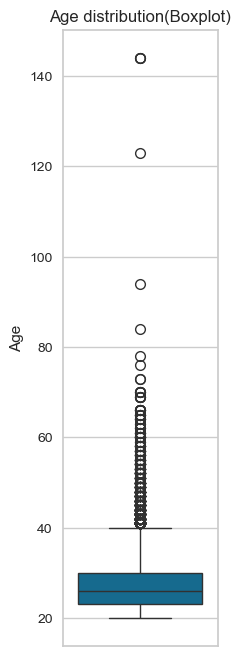

In [38]:
create_box_plot(train_data_copy,'Age')

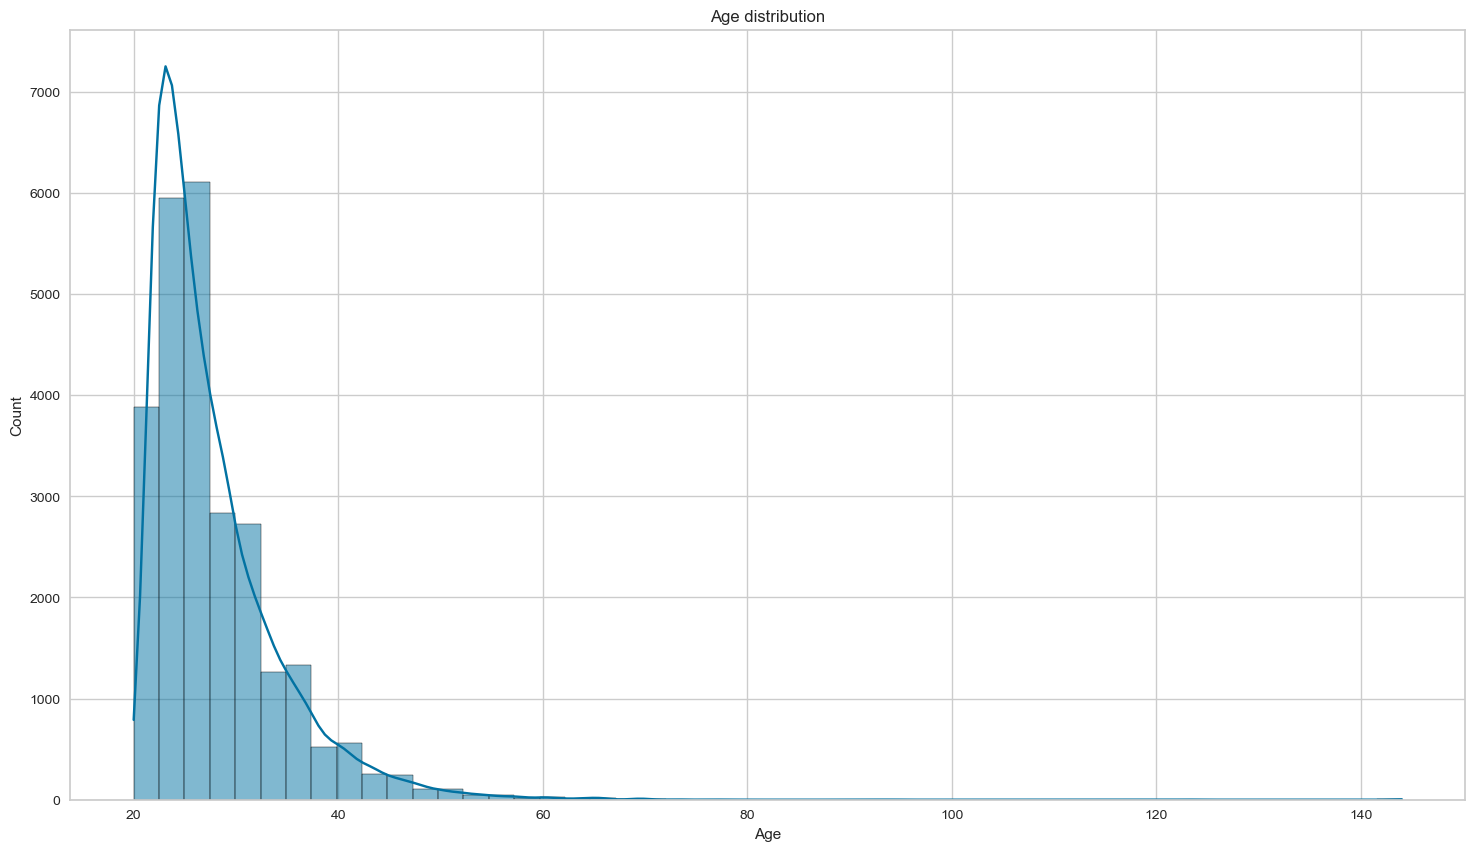

In [39]:
create_hist_plot(train_data_copy,'Age')

Loan Default
0    27.839273
1    27.496027
Name: Age, dtype: float64


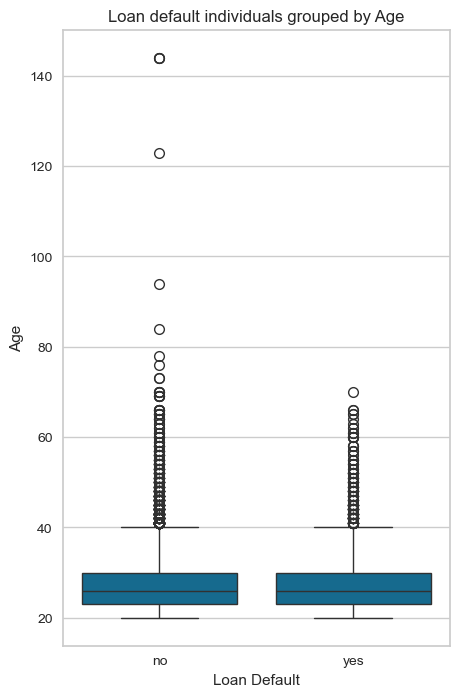

In [40]:
loan_box_plot(train_data_copy,'Age')

**Interpretation:**  
- The youngest applicant is **20 years old**, while the oldest is **144 years old**.  
- The **average** age is **27.7**, and the **median** is **26** (less affected by outliers).  
- The **age distribution is positively skewed**, not normally distributed.  
- There is **no significant difference** in average age between **No** and **Yes** applicants.  
- The maximum age (**144**) is likely an **outlier or data entry error**, and should be further **investigated**.


### 3.2) Annual Income

In [43]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
gen_info_feat(train_data_copy,'Annual Income')

Description:
count     26064.00
mean      66171.84
std       63599.33
min        4000.00
25%       39000.00
50%       55000.00
75%       79500.00
max     6000000.00
Name: Annual Income, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
               Count  Frequency (%)
Annual Income                      
60000            845           3.24
30000            690           2.65
50000            641           2.46
40000            543           2.08
45000            468           1.80
...              ...            ...
105398             1           0.00
61766              1           0.00
178650             1           0.00
39512              1           0.00
107473             1           0.00

[3708 rows x 2 columns]


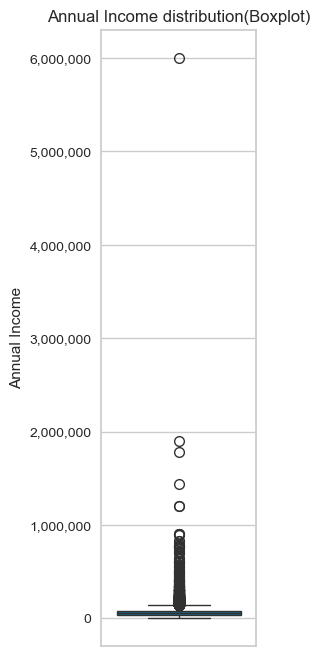

In [44]:
create_box_plot(train_data_copy,'Annual Income')

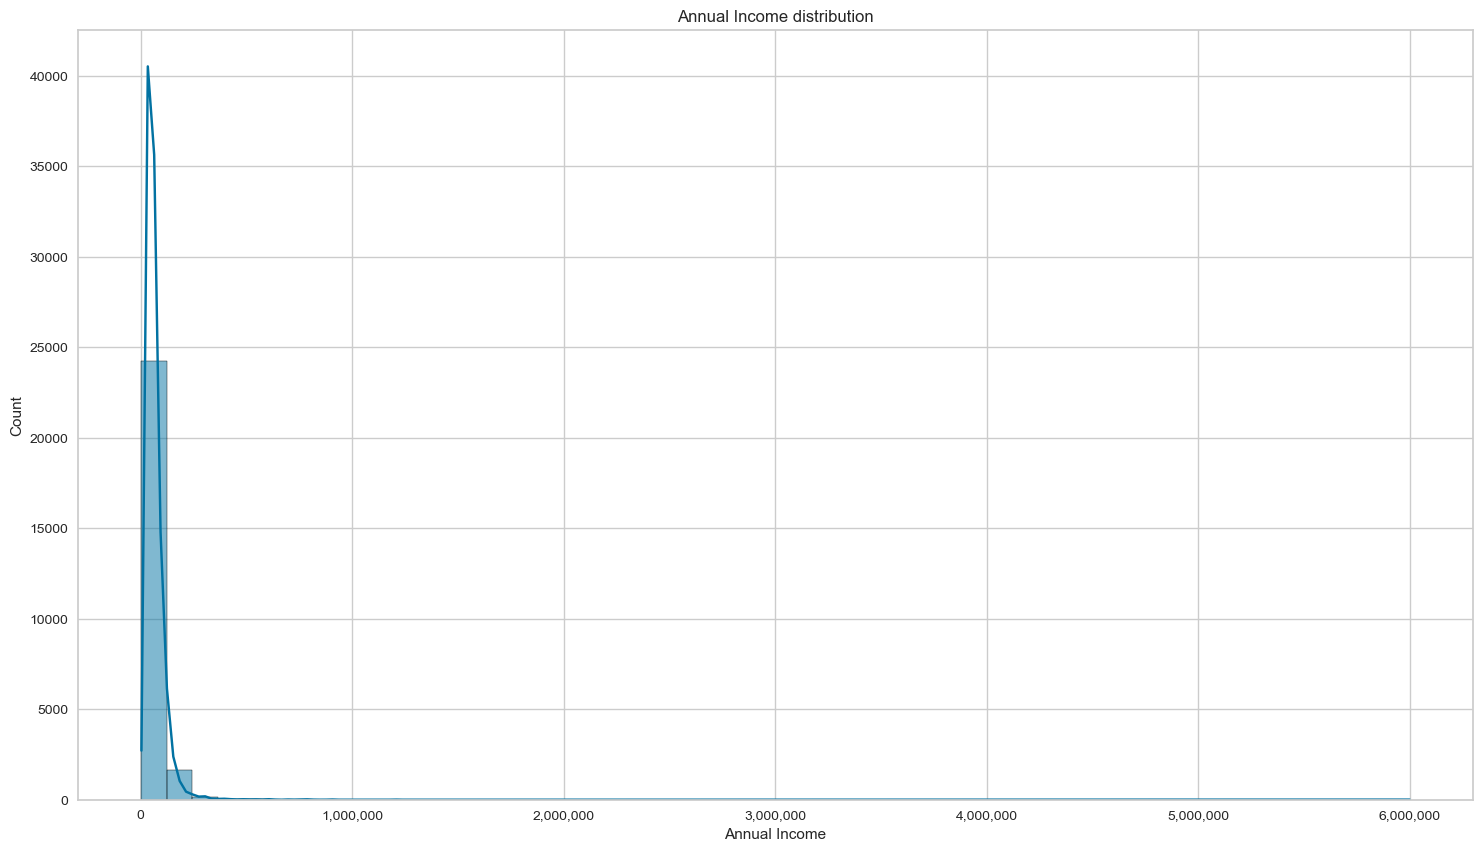

In [45]:
create_hist_plot(train_data_copy,'Annual Income')

Loan Default
0   70898.29
1   49144.78
Name: Annual Income, dtype: float64


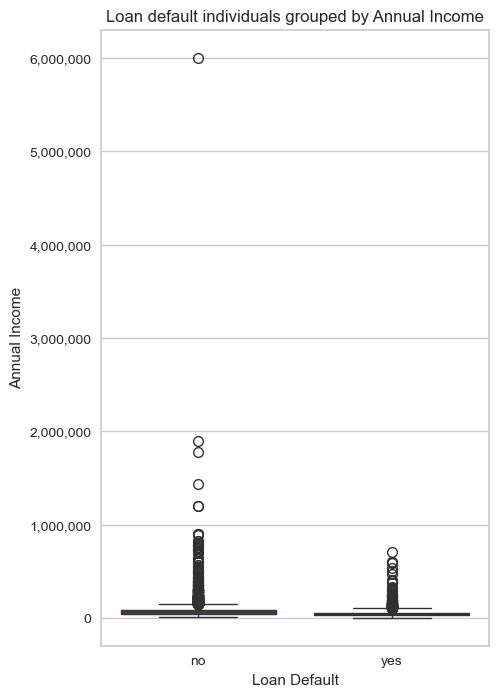

In [46]:
loan_box_plot(train_data_copy,'Annual Income')

**Interpretation:**  
- The **average income** is **66,171**, but this value is affected by **outliers**.  
  If we ignore the outliers, most applicants make around **55,000**.  
- There are **5 applicants** earning more than **1,000,000**, and notably, one applicant reports an income of **6,000,000**.  
- This feature is **positively skewed**.  
- **No** and **Yes** applicants have **roughly similar income distributions**.


### 3.3) Home Ownership

In [49]:
gen_info_feat(train_data_copy,'Home Ownership')

Description:
count     26064
unique        4
top        RENT
freq      13150
Name: Home Ownership, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                Count  Frequency (%)
Home Ownership                      
RENT            13150          50.45
MORTGAGE        10759          41.28
OWN              2072           7.95
OTHER              83           0.32


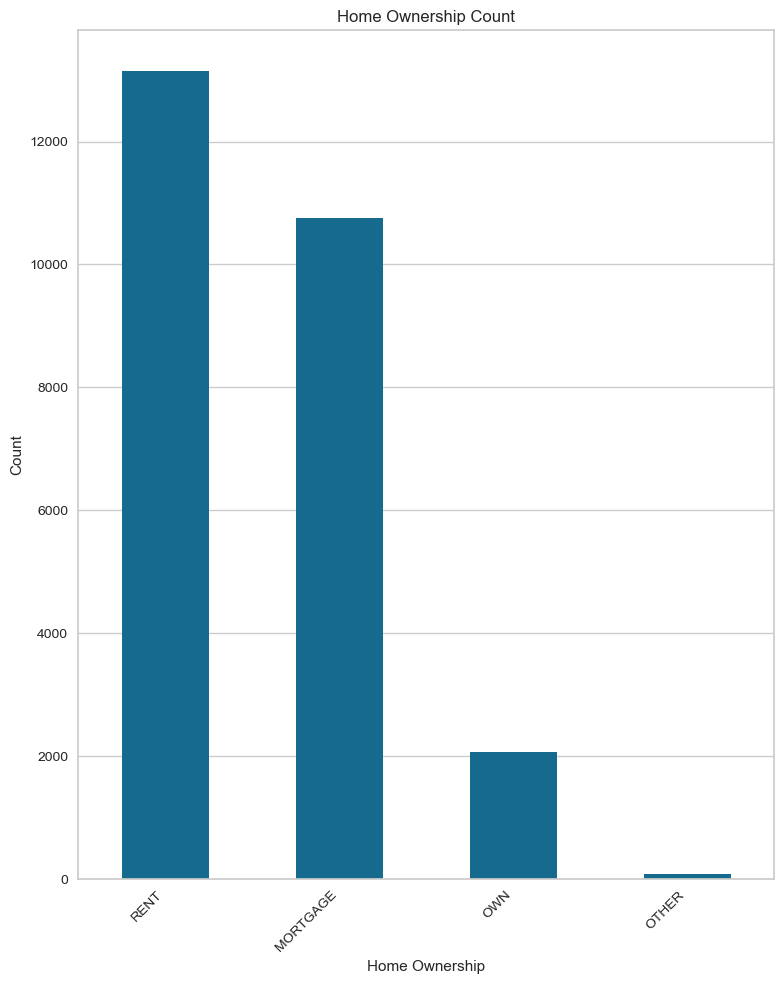

In [50]:
create_bar_plot(train_data_copy,'Home Ownership')

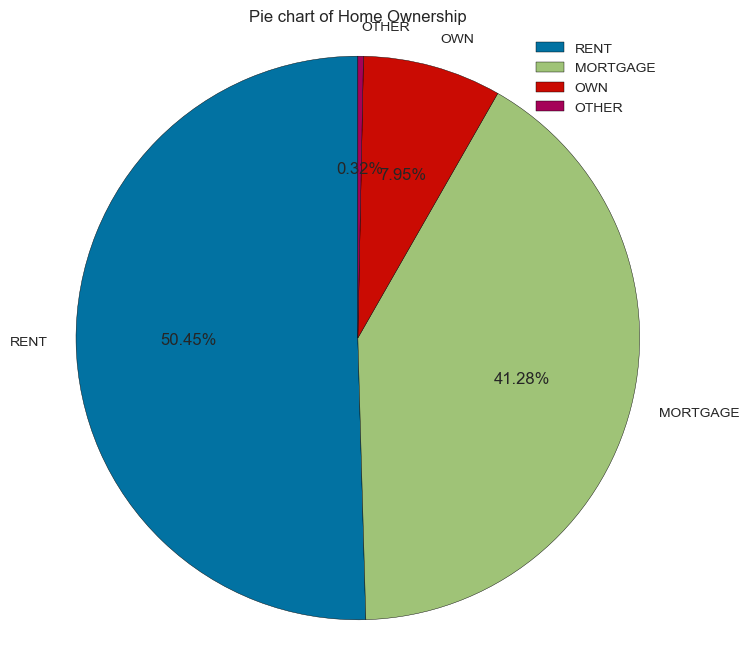

In [51]:
create_pie_plot(train_data_copy,'Home Ownership')

**Interpretation:**  
- The dataset contains **26,064** records for the *Home Ownership* feature, with **4 unique categories**.  
- The most common type of home ownership is **RENT**, accounting for **50.45%** of applicants.  
- **MORTGAGE** is the second most common, making up **41.28%**, followed by **OWN** at **7.95%**.  
- Only a small fraction of applicants (**0.32%**) fall under the **OTHER** category.  
- Overall, the majority of applicants do **not own their homes outright**, which could be associated with higher financial dependency or less stability.  
- The distribution is **heavily skewed toward RENT and MORTGAGE**, suggesting these are the dominant housing situations in the dataset.

### 3.4) Employment Length

In [54]:
gen_info_feat(train_data_copy,'Employment Length')

Description:
count   25347.00
mean        4.79
std         4.11
min         0.00
25%         2.00
50%         4.00
75%         7.00
max       123.00
Name: Employment Length, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
                   Count  Frequency (%)
Employment Length                      
0.00                3275          12.92
2.00                3129          12.34
3.00                2792          11.02
1.00                2316           9.14
5.00                2314           9.13
4.00                2295           9.05
6.00                2095           8.27
7.00                1783           7.03
8.00                1345           5.31
9.00                1101           4.34
11.00                592           2.34
10.00                549           2.17
12.00                456           1.80
13.00                345           1.36
14.00                271           

In [55]:
job_title_nan_count = train_data_copy['Employment Length'].isna().sum()
rows_total_count = train_data_copy.shape[0]
print('The percentage of missing rows is {:.2f} %'.format(job_title_nan_count * 100 / rows_total_count))

The percentage of missing rows is 2.75 %


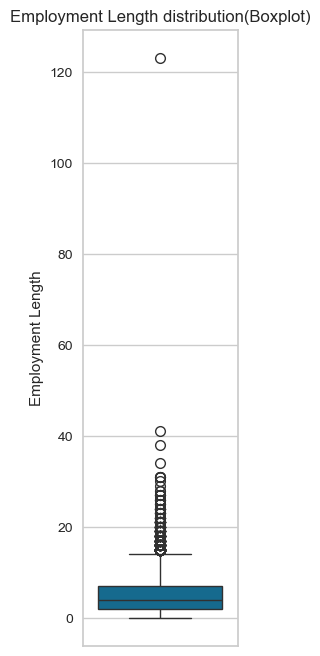

In [56]:
create_box_plot(train_data_copy,'Employment Length')

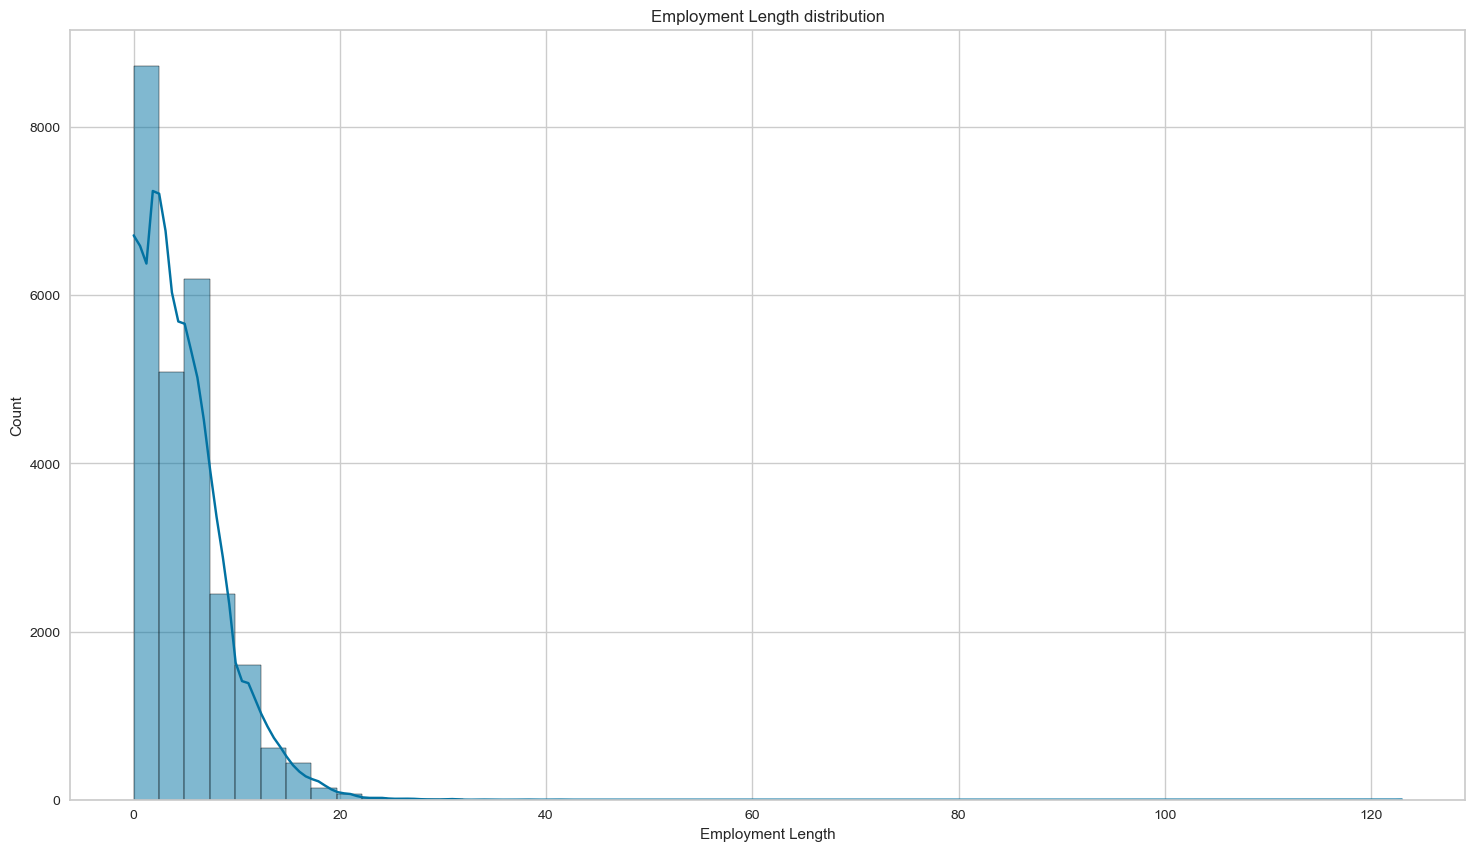

In [57]:
create_hist_plot(train_data_copy,'Employment Length')

Loan Default
0   4.96
1   4.17
Name: Employment Length, dtype: float64


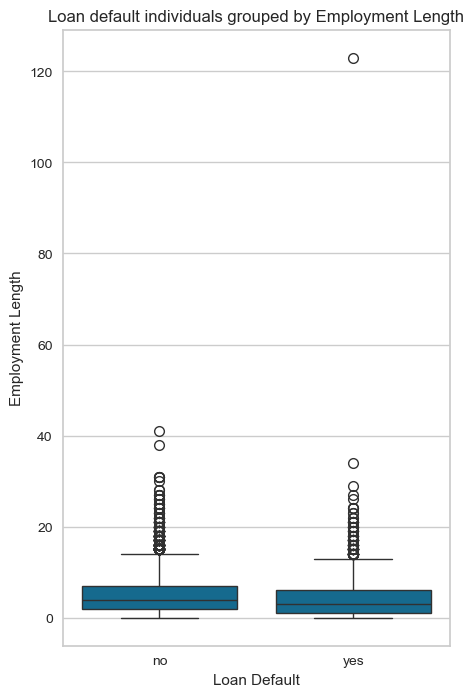

In [58]:
loan_box_plot(train_data_copy,'Employment Length')

**Interpretation:**  
- Most applicants have been working for **4 to 5 years** on average.  
- There are a noticeable number of **outliers** with **employment length exceeding 14 years**.  
- The **employment length distribution is positively skewed**.  
- Applicants who **defaulted on loans** have a slightly **lower average employment length** of **4 years**, compared to **5 years** for those who did not default.  
- Approximately **2.75%** of the rows have **missing values** in this feaure.


### 3.5) Loan Purpose

In [61]:
gen_info_feat(train_data_copy,'Loan Purpose')

Description:
count         26064
unique            6
top       EDUCATION
freq           5144
Name: Loan Purpose, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                   Count  Frequency (%)
Loan Purpose                           
EDUCATION           5144          19.74
MEDICAL             4843          18.58
VENTURE             4540          17.42
PERSONAL            4436          17.02
DEBTCONSOLIDATION   4216          16.18
HOMEIMPROVEMENT     2885          11.07


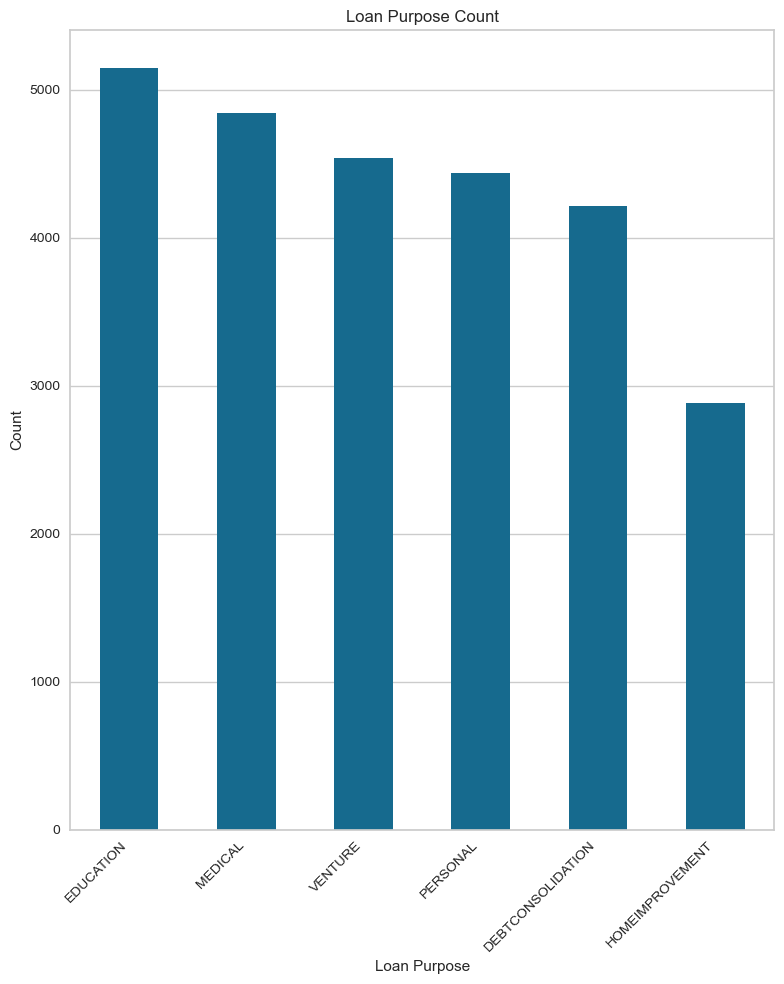

In [62]:
create_bar_plot(train_data_copy,'Loan Purpose')

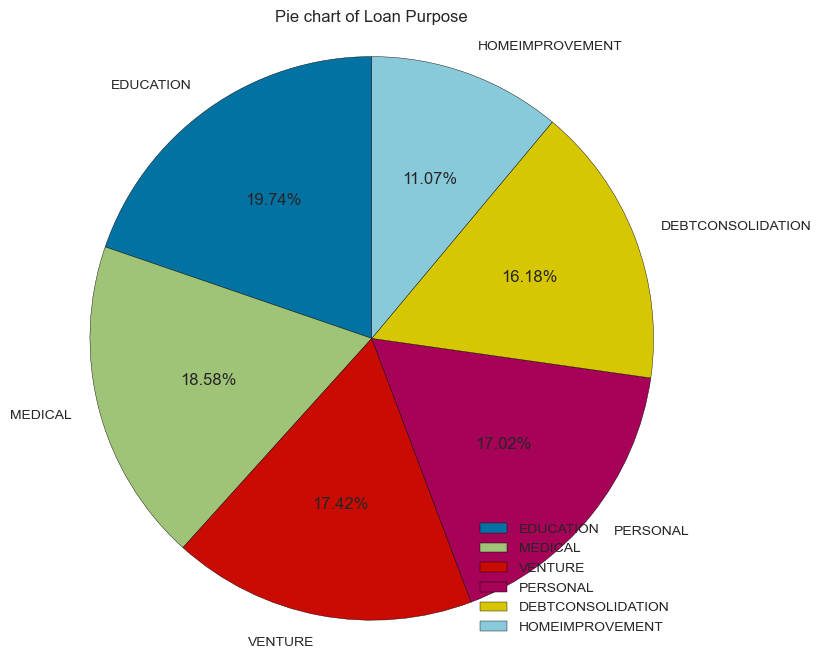

In [63]:
create_pie_plot(train_data_copy,'Loan Purpose')

**Interpretation:**  
- The *Loan Purpose* feature contains **6 unique categories** across **26,064** records.  
- The most common reason for applying for a loan is **EDUCATION**, accounting for **19.74%** of all applications.  
- This is followed closely by **MEDICAL (18.58%)**, **VENTURE (17.42%)**, and **PERSONAL (17.02%)** purposes.  
- **DEBT CONSOLIDATION** represents **16.18%**, while **HOME IMPROVEMENT** is the least common at **11.07%**.  
- Overall, loan applications are fairly **evenly distributed across multiple purposes**, with no single purpose dominating the dataset.  
- The diversity of loan purposes suggests a wide range of financial needs among the applicants.

### 3.6) Credit Grade

In [66]:
gen_info_feat(train_data_copy,'Credit Grade')

Description:
count     26064
unique        7
top           A
freq       8615
Name: Credit Grade, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
              Count  Frequency (%)
Credit Grade                      
A              8615          33.05
B              8389          32.19
C              5168          19.83
D              2897          11.11
E               757           2.90
F               188           0.72
G                50           0.19


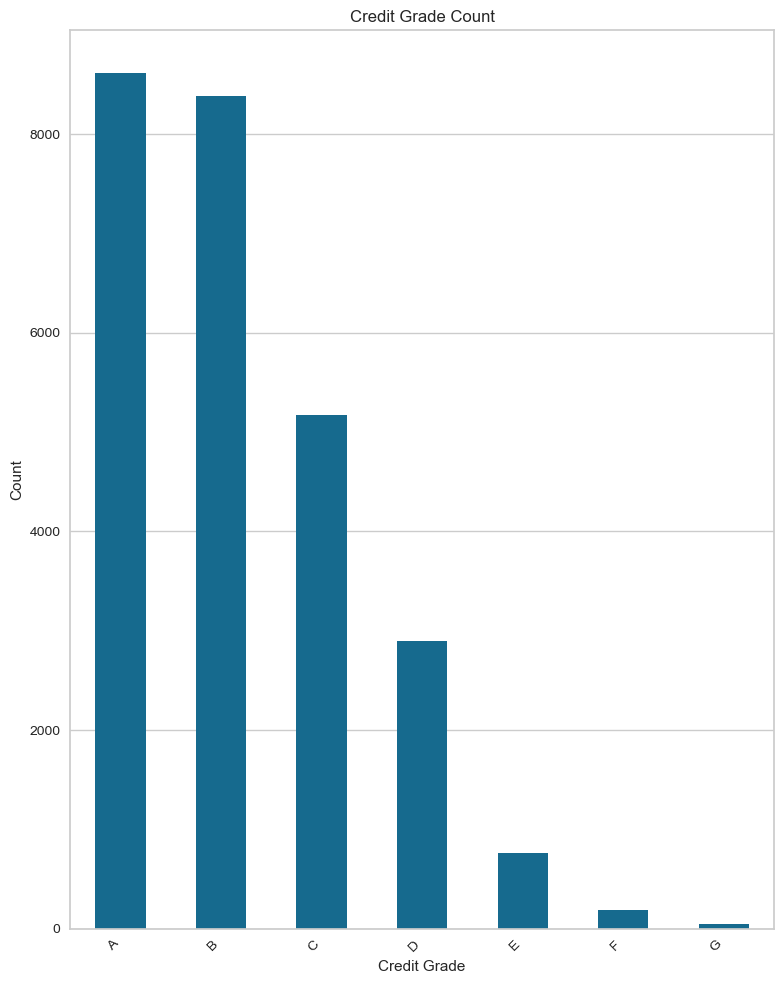

In [67]:
create_bar_plot(train_data_copy,'Credit Grade')

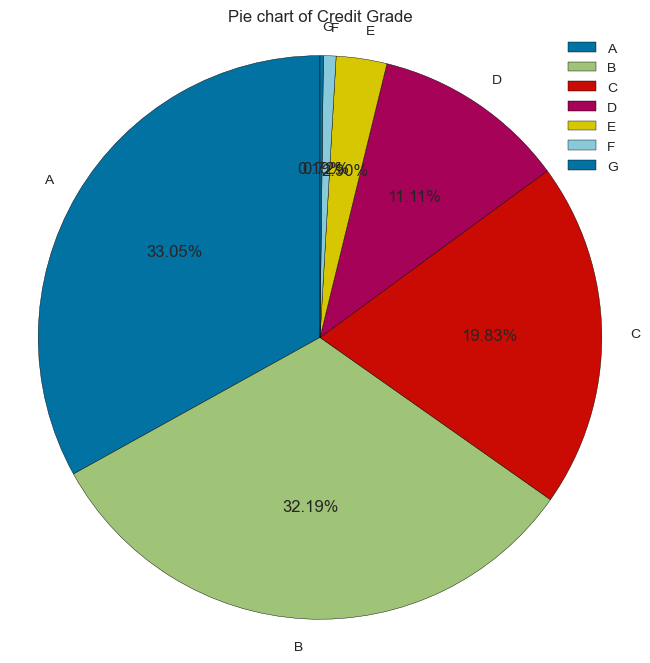

In [68]:
create_pie_plot(train_data_copy,'Credit Grade')

**Interpretation:**  
- The *Credit Grade* feature includes **7 levels of borrower creditworthiness**, ranging from **A (highest)** to **G (lowest)**.  
- The majority of applicants fall into **Grade A (33.05%)** and **Grade B (32.19%)**, indicating that over **65%** of borrowers are considered to have **high or relatively low credit risk**.  
- **Grade C** covers **19.83%**, representing borrowers with **moderate credit risk**.  
- Grades **D to G**, which indicate **higher credit risk**, account for only **14.93%** of the dataset:
  - **D: 11.11%**
  - **E: 2.90%**
  - **F: 0.72%**
  - **G: 0.19%**  
- The **low proportion of Grades F and G** suggests that very few applicants in the dataset have extremely poor creditworthiness.  
- Overall, the distribution is **skewed towards higher credit grades**, which may indicate a relatively **creditworthy applicant pool**, possibly due to filtering during loan approval processes.


### 3.7) Loan Amount

In [71]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
gen_info_feat(train_data_copy,'Loan Amount')

Description:
count   26064.00
mean     9601.07
std      6315.75
min       500.00
25%      5000.00
50%      8000.00
75%     12250.00
max     35000.00
Name: Loan Amount, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
             Count  Frequency (%)
Loan Amount                      
10000         2144           8.23
5000          1620           6.22
12000         1433           5.50
6000          1429           5.48
15000         1227           4.71
...            ...            ...
26375            1           0.00
29100            1           0.00
21100            1           0.00
32400            1           0.00
22100            1           0.00

[708 rows x 2 columns]


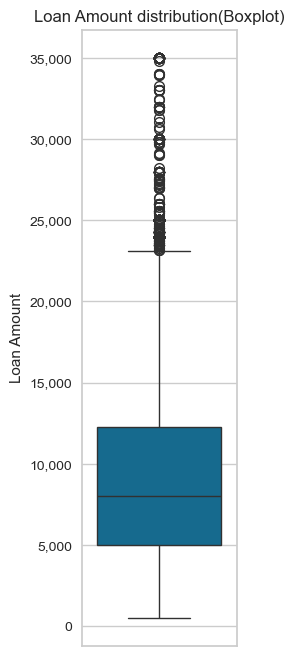

In [72]:
create_box_plot(train_data_copy,'Loan Amount')

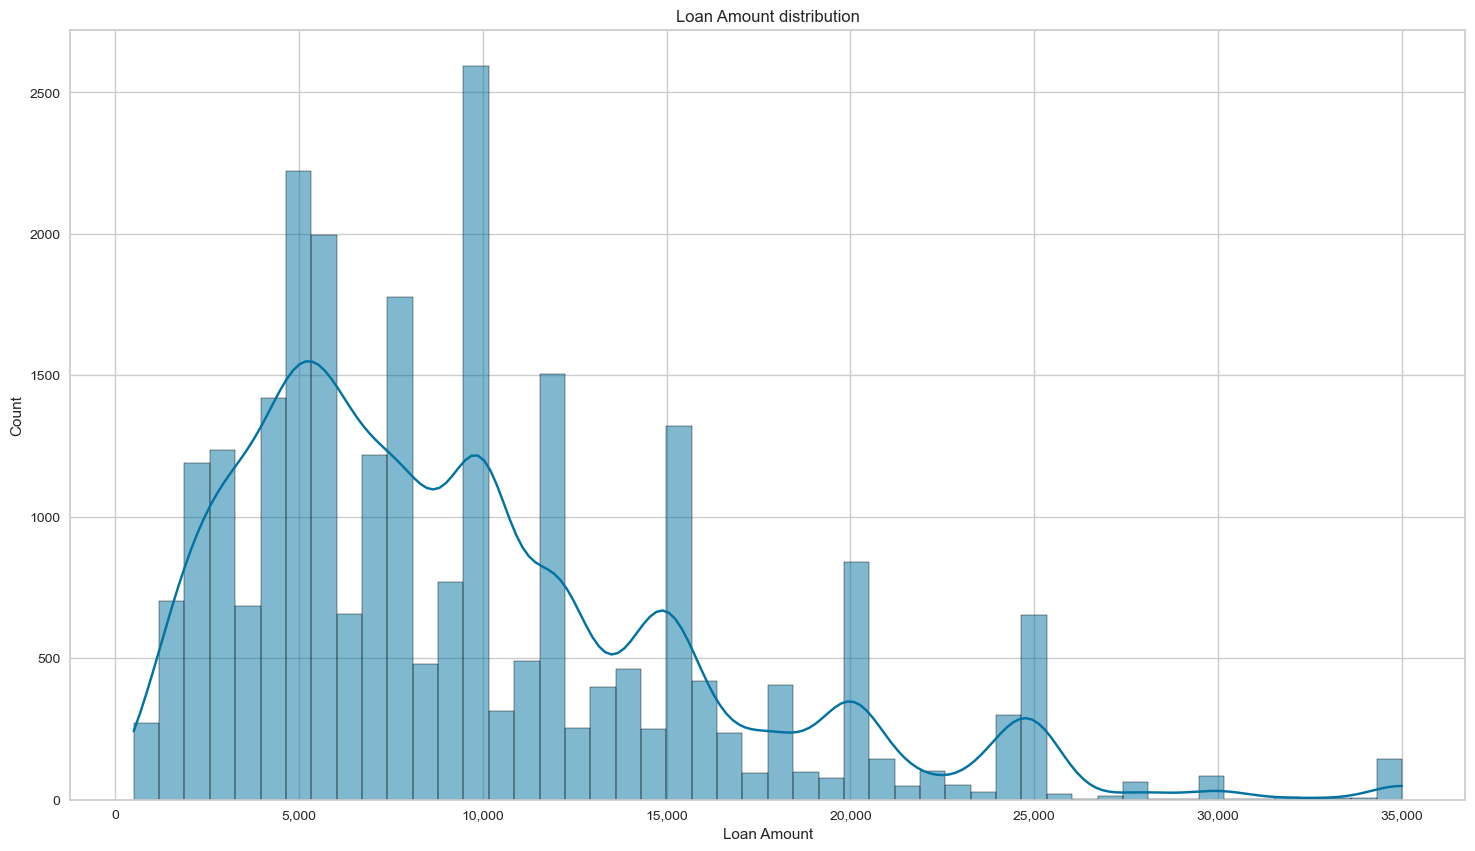

In [73]:
create_hist_plot(train_data_copy,'Loan Amount')

Loan Default
0    9233.45
1   10925.45
Name: Loan Amount, dtype: float64


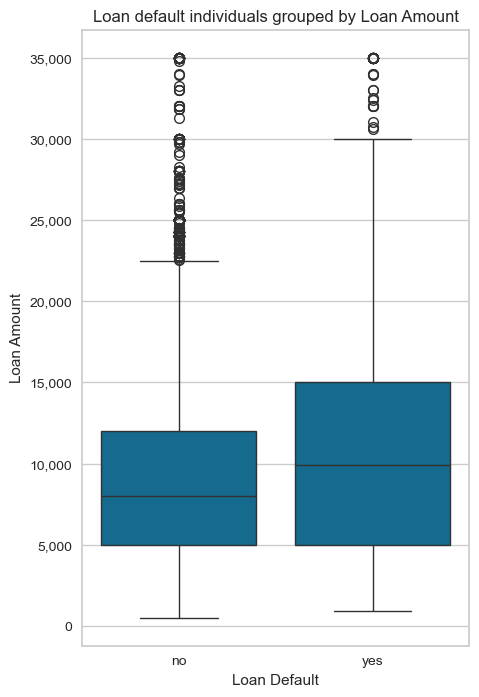

In [74]:
loan_box_plot(train_data_copy,'Loan Amount')

**Interpretation:**
- The average loan amount is **9,601**, while the  median is lower at **8,000**, indicating **a right-skewed (positively skewed)** distribution.
- A significant number of applicants requested **loan amounts around 5,000–10,000**.
- There are a few extreme **outliers reaching up to 35,000**, which inflate the mean.
- Individuals who **defaulted on loans (yes)** tend to borrow **larger amounts** than those who did not.
- This suggests that **larger loan sizes may be associated with higher default risk**, or reflect applicants with higher financial needs and possibly higher risk.

### 3.8) Interest Rate

In [77]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
gen_info_feat(train_data_copy,'Interest Rate')

Description:
count   23585.00
mean       11.01
std         3.23
min         5.42
25%         7.90
50%        10.99
75%        13.47
max        22.48
Name: Interest Rate, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
               Count  Frequency (%)
Interest Rate                      
10.99            607           2.57
7.51             599           2.54
7.49             530           2.25
7.88             521           2.21
5.42             463           1.96
...              ...            ...
14.62              1           0.00
17.34              1           0.00
17.06              1           0.00
16.71              1           0.00
20.40              1           0.00

[343 rows x 2 columns]


In [78]:
job_title_nan_count = train_data_copy['Interest Rate'].isna().sum()
rows_total_count = train_data_copy.shape[0]
print('The percentage of missing rows is {:.2f} %'.format(job_title_nan_count * 100 / rows_total_count))

The percentage of missing rows is 9.51 %


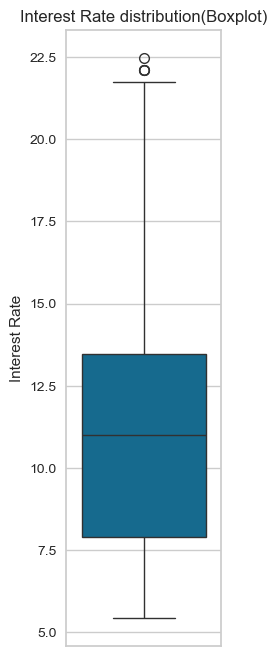

In [79]:
create_box_plot(train_data_copy,'Interest Rate')

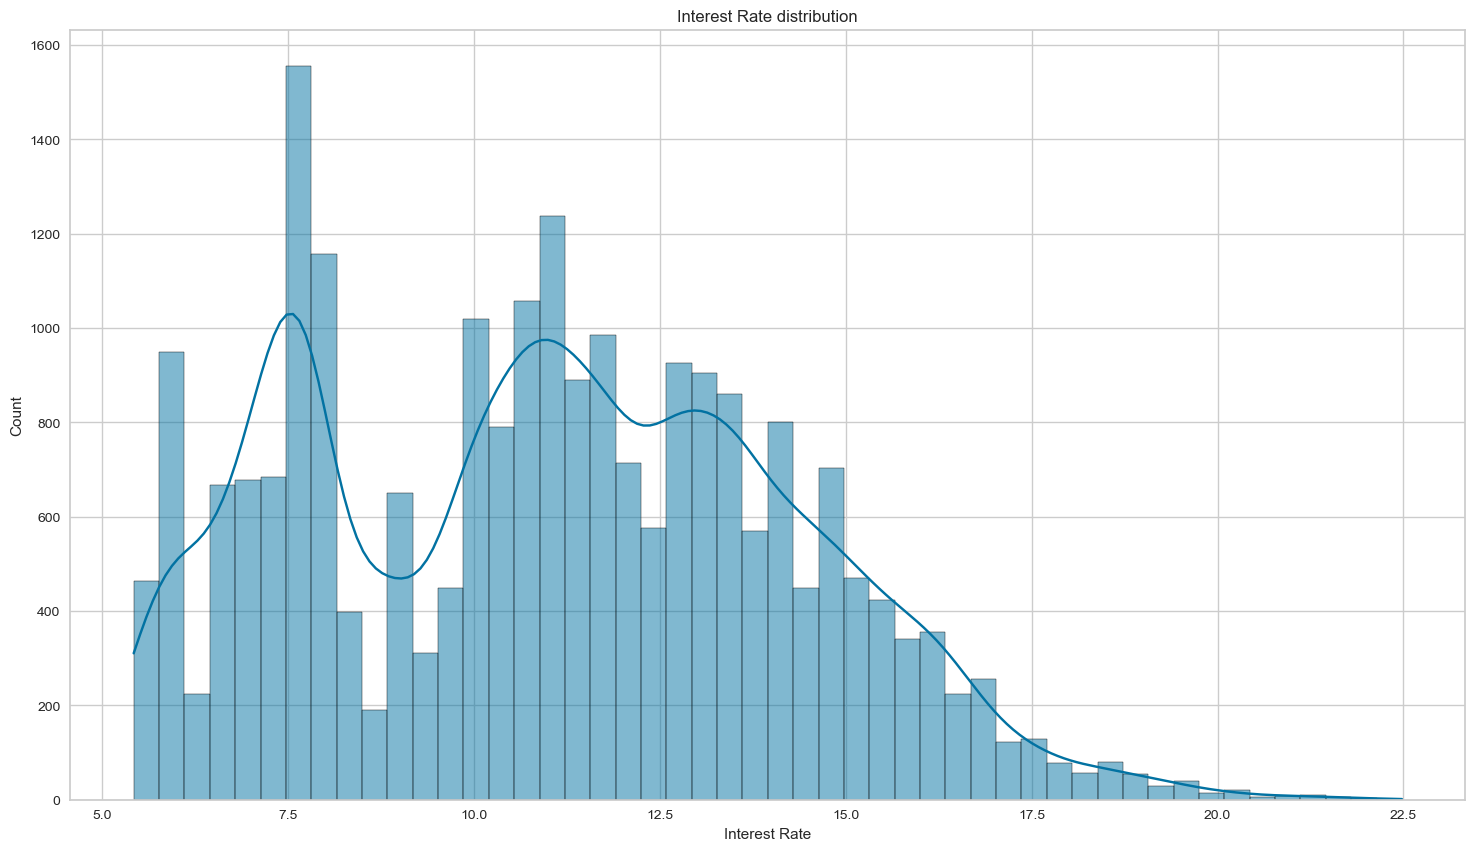

In [80]:
create_hist_plot(train_data_copy,'Interest Rate')

Loan Default
0   10.45
1   13.03
Name: Interest Rate, dtype: float64


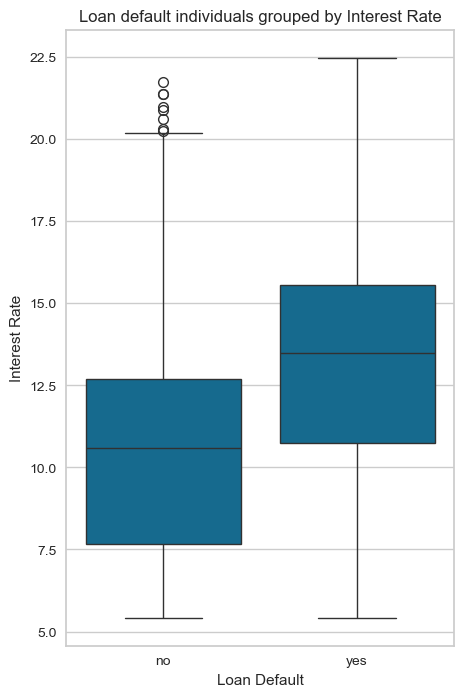

In [81]:
loan_box_plot(train_data_copy,'Interest Rate')

**Interpretation:**
- The average interest rate is 11.01%, with a median of 10.99%, indicating a nearly symmetric distribution with a **slight positive skew**.
- Borrowers who defaulted ("yes") were typically charged **higher interest rates**, likely reflecting **higher perceived risk** by the lender.
- This supports the intuition that higher interest rates may be associated with **greater loan default risk**.
- However, interest rate alone does not fully determine default risk and should be considered in conjunction with other variables (e.g., loan amount, income, credit grade).
- Approximately **9.51%** of the rows have **missing values** in this feature.

### 3.9) Loan Default

In [84]:
gen_info_feat(train_data_copy,'Loan Default')

Description:
count   26064.00
mean        0.22
std         0.41
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: Loan Default, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
              Count  Frequency (%)
Loan Default                      
0             20401          78.27
1              5663          21.73


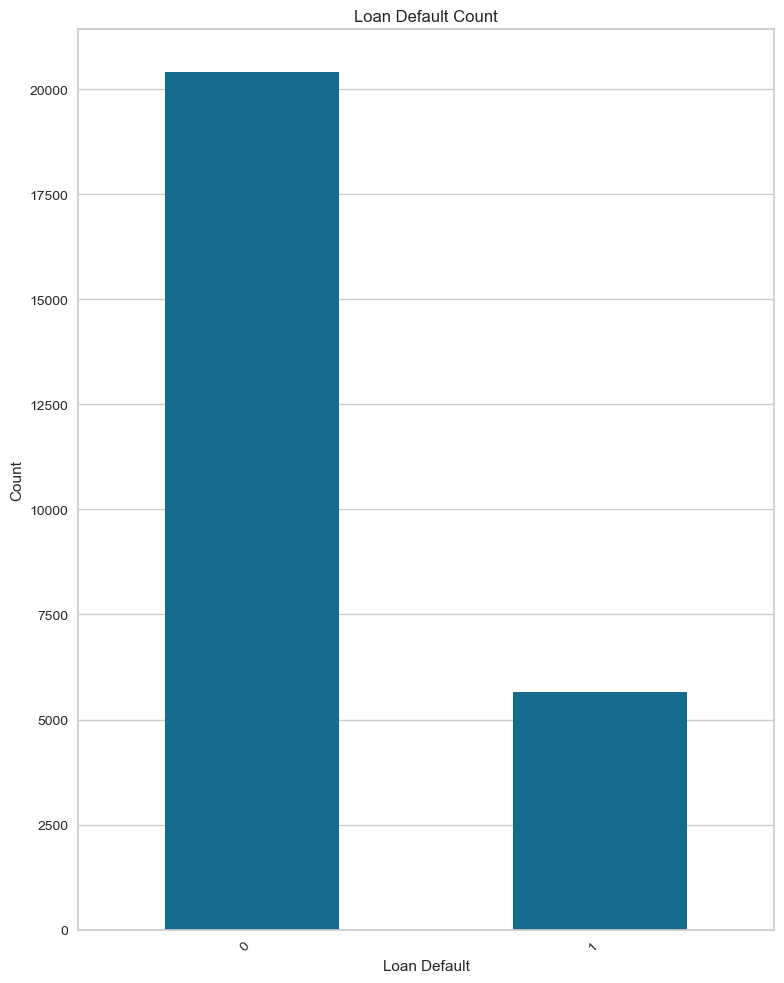

In [85]:
create_bar_plot(train_data_copy,'Loan Default')

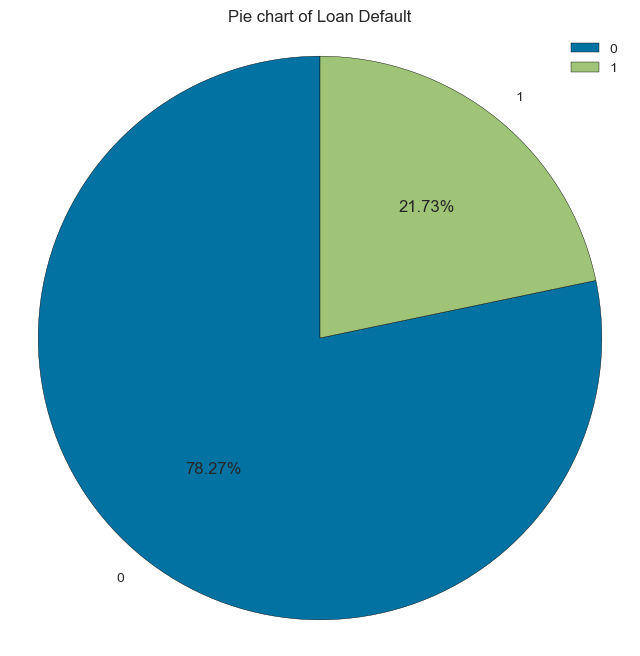

In [86]:
create_pie_plot(train_data_copy,'Loan Default')

**Interpretation:**
- A vast majority of applicants are low risk applicants (78.27%).
- We have a very imbalance data.
- Note: Here **0** is no and **1** is yes.

### 3.10) Loan To Income Ratio

In [89]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
gen_info_feat(train_data_copy,'Loan To Income Ratio')

Description:
count   26064.00
mean        0.17
std         0.11
min         0.00
25%         0.09
50%         0.15
75%         0.23
max         0.78
Name: Loan To Income Ratio, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
                      Count  Frequency (%)
Loan To Income Ratio                      
0.10                   1236           4.74
0.13                   1188           4.56
0.08                   1134           4.35
0.07                   1115           4.28
0.11                   1087           4.17
...                     ...            ...
0.66                      2           0.01
0.72                      1           0.00
0.70                      1           0.00
0.78                      1           0.00
0.76                      1           0.00

[75 rows x 2 columns]


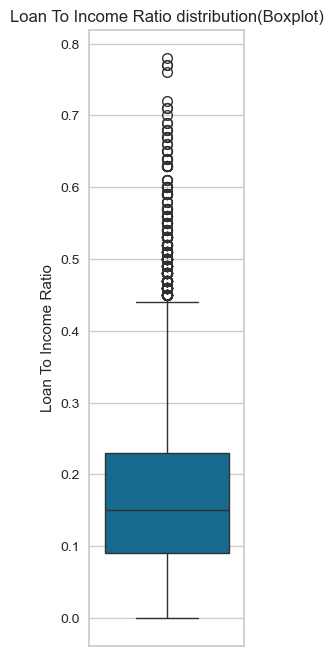

In [90]:
create_box_plot(train_data_copy,'Loan To Income Ratio')

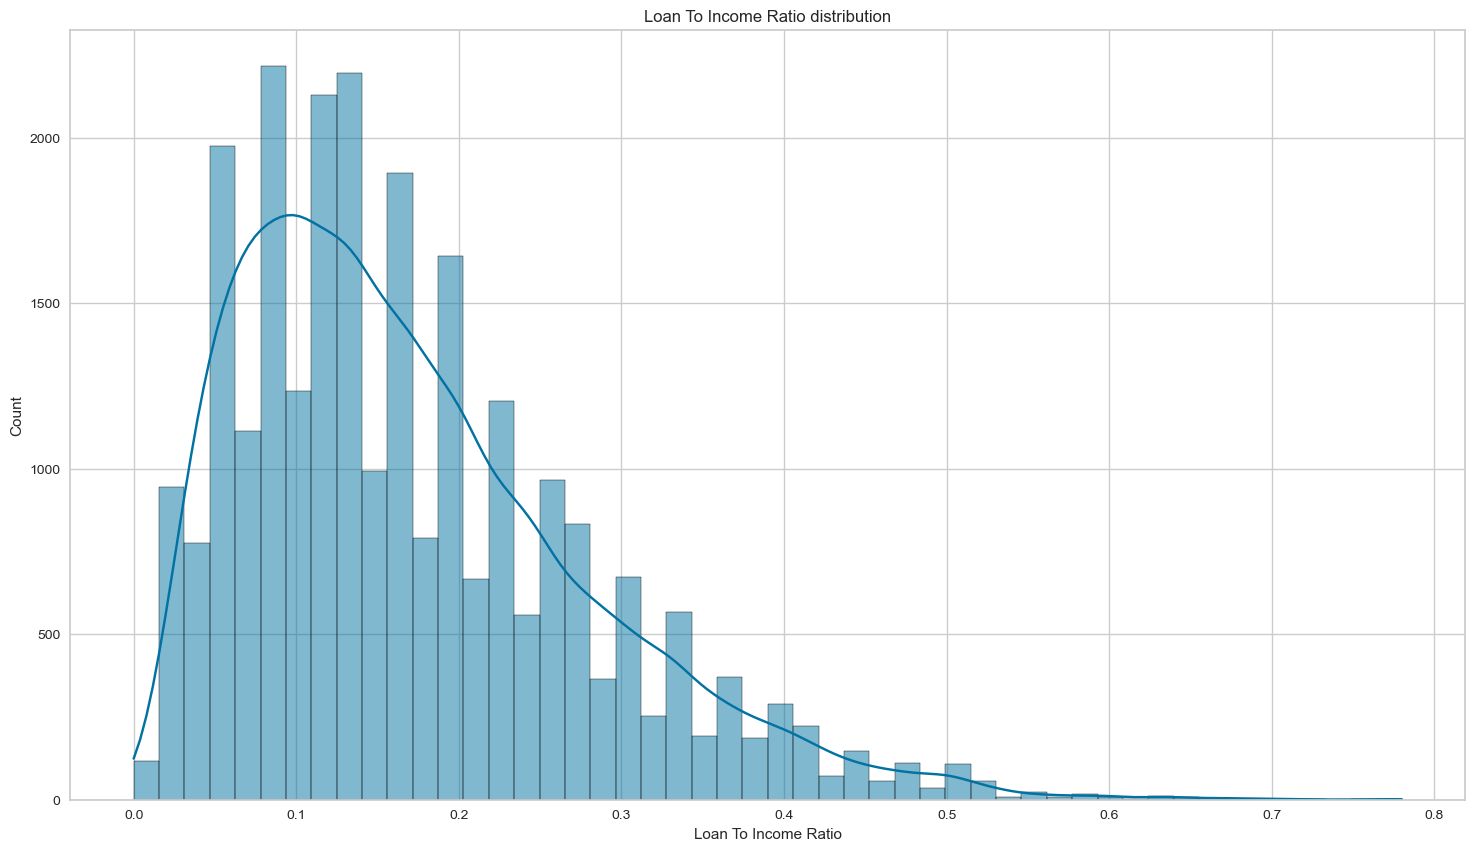

In [91]:
create_hist_plot(train_data_copy,'Loan To Income Ratio')

Loan Default
0   0.15
1   0.25
Name: Loan To Income Ratio, dtype: float64


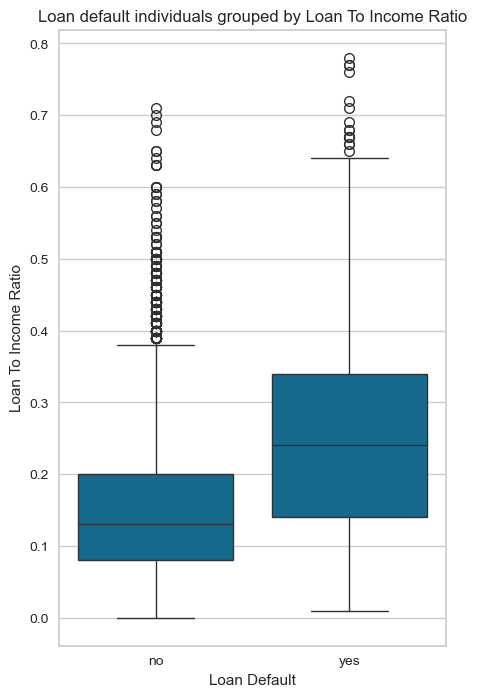

In [92]:
loan_box_plot(train_data_copy,'Loan To Income Ratio')

**Loan To Income Ratio Analysis:**

- This ratio is strongly indicative of credit risk.
- Individuals who default tend to have a significantly higher Loan to Income Ratio.
- The median ratio for defaulters is notably higher, with wider spread and more outliers.
- This feature is a strong candidate for predictive modeling.


### 3.11) Has Prior Default

In [95]:
gen_info_feat(train_data_copy,'Has Prior Default')

Description:
count     26064
unique        2
top           N
freq      21514
Name: Has Prior Default, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                   Count  Frequency (%)
Has Prior Default                      
N                  21514          82.54
Y                   4550          17.46


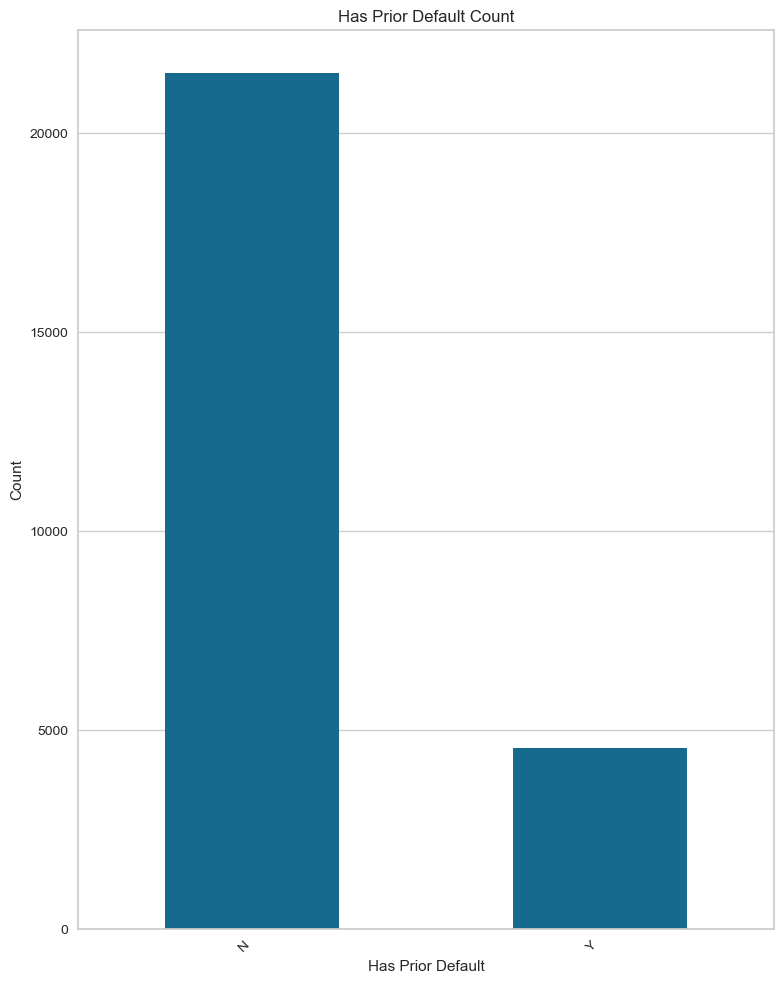

In [96]:
create_bar_plot(train_data_copy,'Has Prior Default')

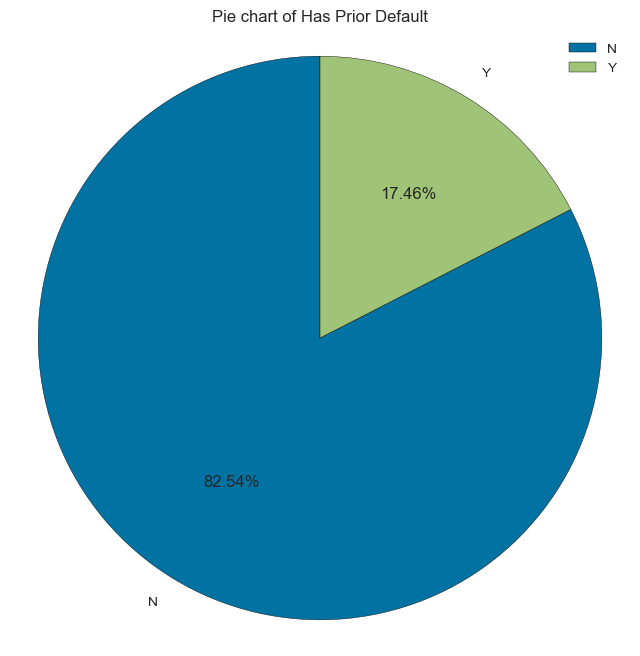

In [97]:
create_pie_plot(train_data_copy,'Has Prior Default')

**Interpretation:**
- Most of the applicants are individuals who have previously had low risk (82.54%).
- We have a very imbalance data.
- Note: Here **N** is no and **Y** is yes.

### 3.12) Credit History Length

In [100]:
gen_info_feat(train_data_copy,'Credit History Length')

Description:
count   26064.00
mean        5.82
std         4.05
min         2.00
25%         3.00
50%         4.00
75%         8.00
max        30.00
Name: Credit History Length, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                       Count  Frequency (%)
Credit History Length                      
2                       4765          18.28
4                       4731          18.15
3                       4721          18.11
8                       1567           6.01
7                       1523           5.84
9                       1517           5.82
5                       1491           5.72
6                       1485           5.70
10                      1479           5.67
14                       401           1.54
12                       394           1.51
11                       371           1.42
13                       366           1.40
15           

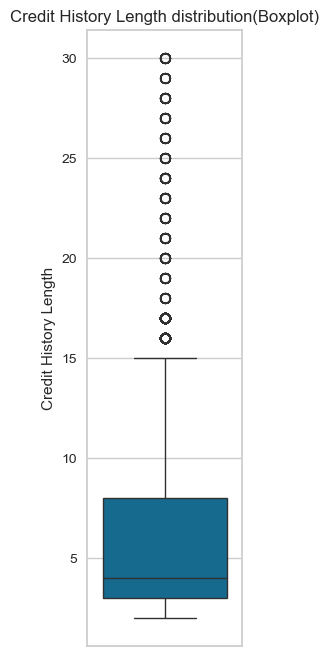

In [101]:
create_box_plot(train_data_copy,'Credit History Length')

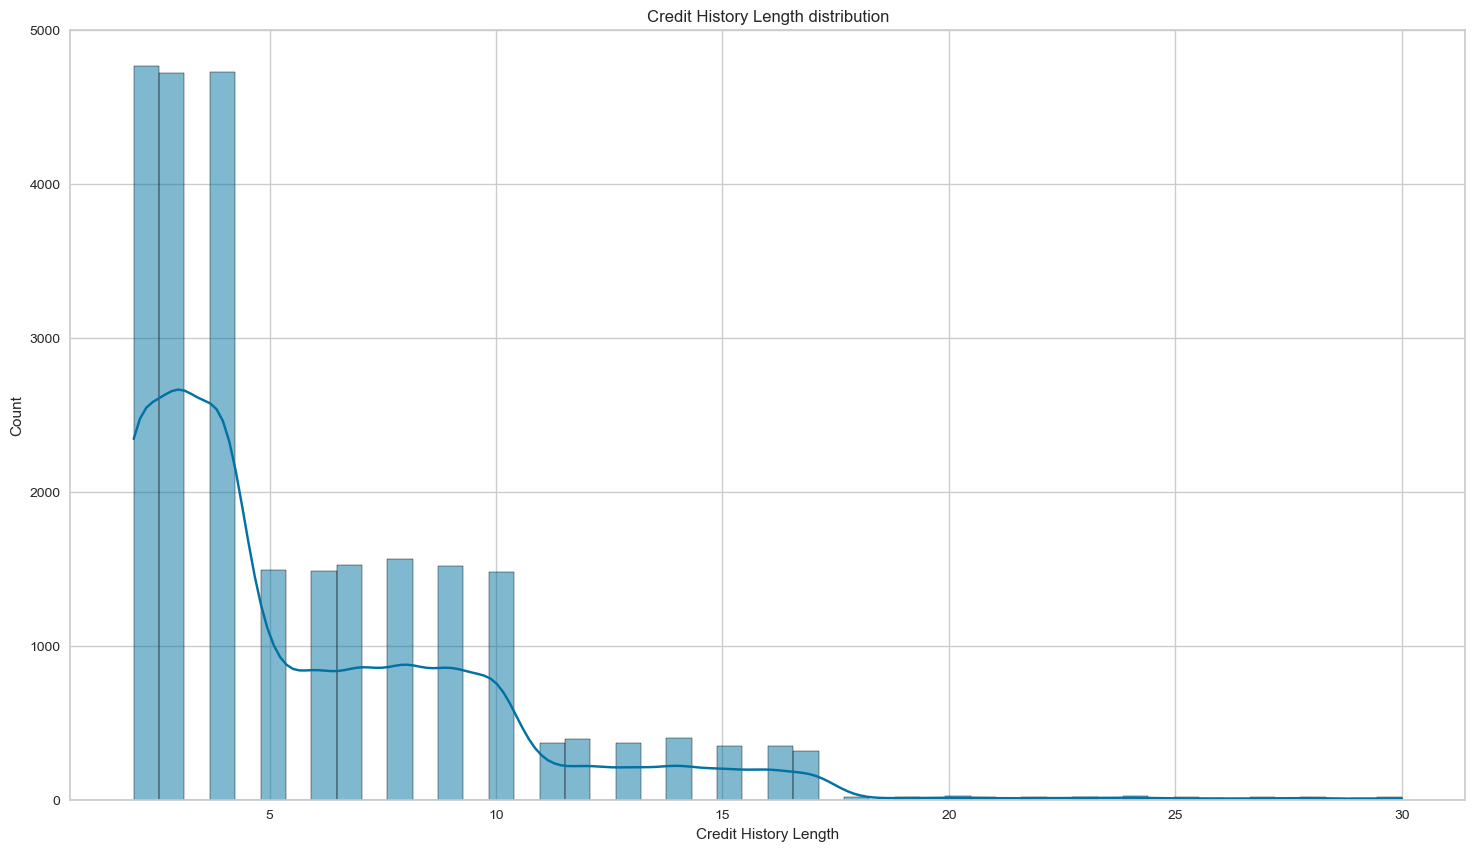

In [102]:
create_hist_plot(train_data_copy,'Credit History Length')

Loan Default
0   5.85
1   5.69
Name: Credit History Length, dtype: float64


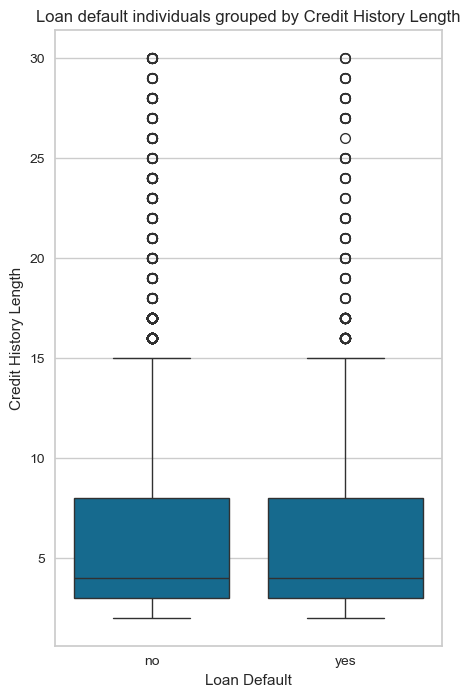

In [103]:
loan_box_plot(train_data_copy,'Credit History Length')

**Interpretation:**
- The shortest credit history is **2 years**, and the longest is **30 years**.
- The average credit history length is **5.82 years**, and the median is **4 years**.
- The distribution is **right-skewed**, with most applicants having a short credit history.
- There is **no significant difference** in credit history length between applicants who defaulted and those who did not.
- The longer credit history values (e.g., **30 years**) are outliers, but do not appear to heavily influence the overall trend.

## 4) Bivariate analysis

### 4.1) Numerical vs numerical features (Correlation & scatter plots)

#### 4.1.1) Scatter plots

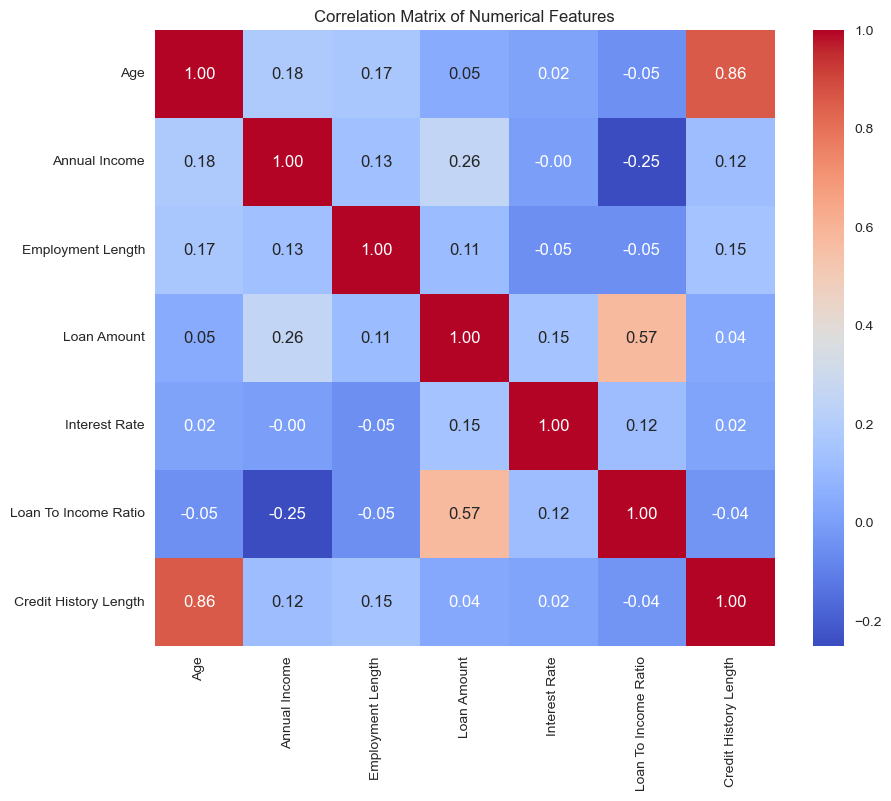

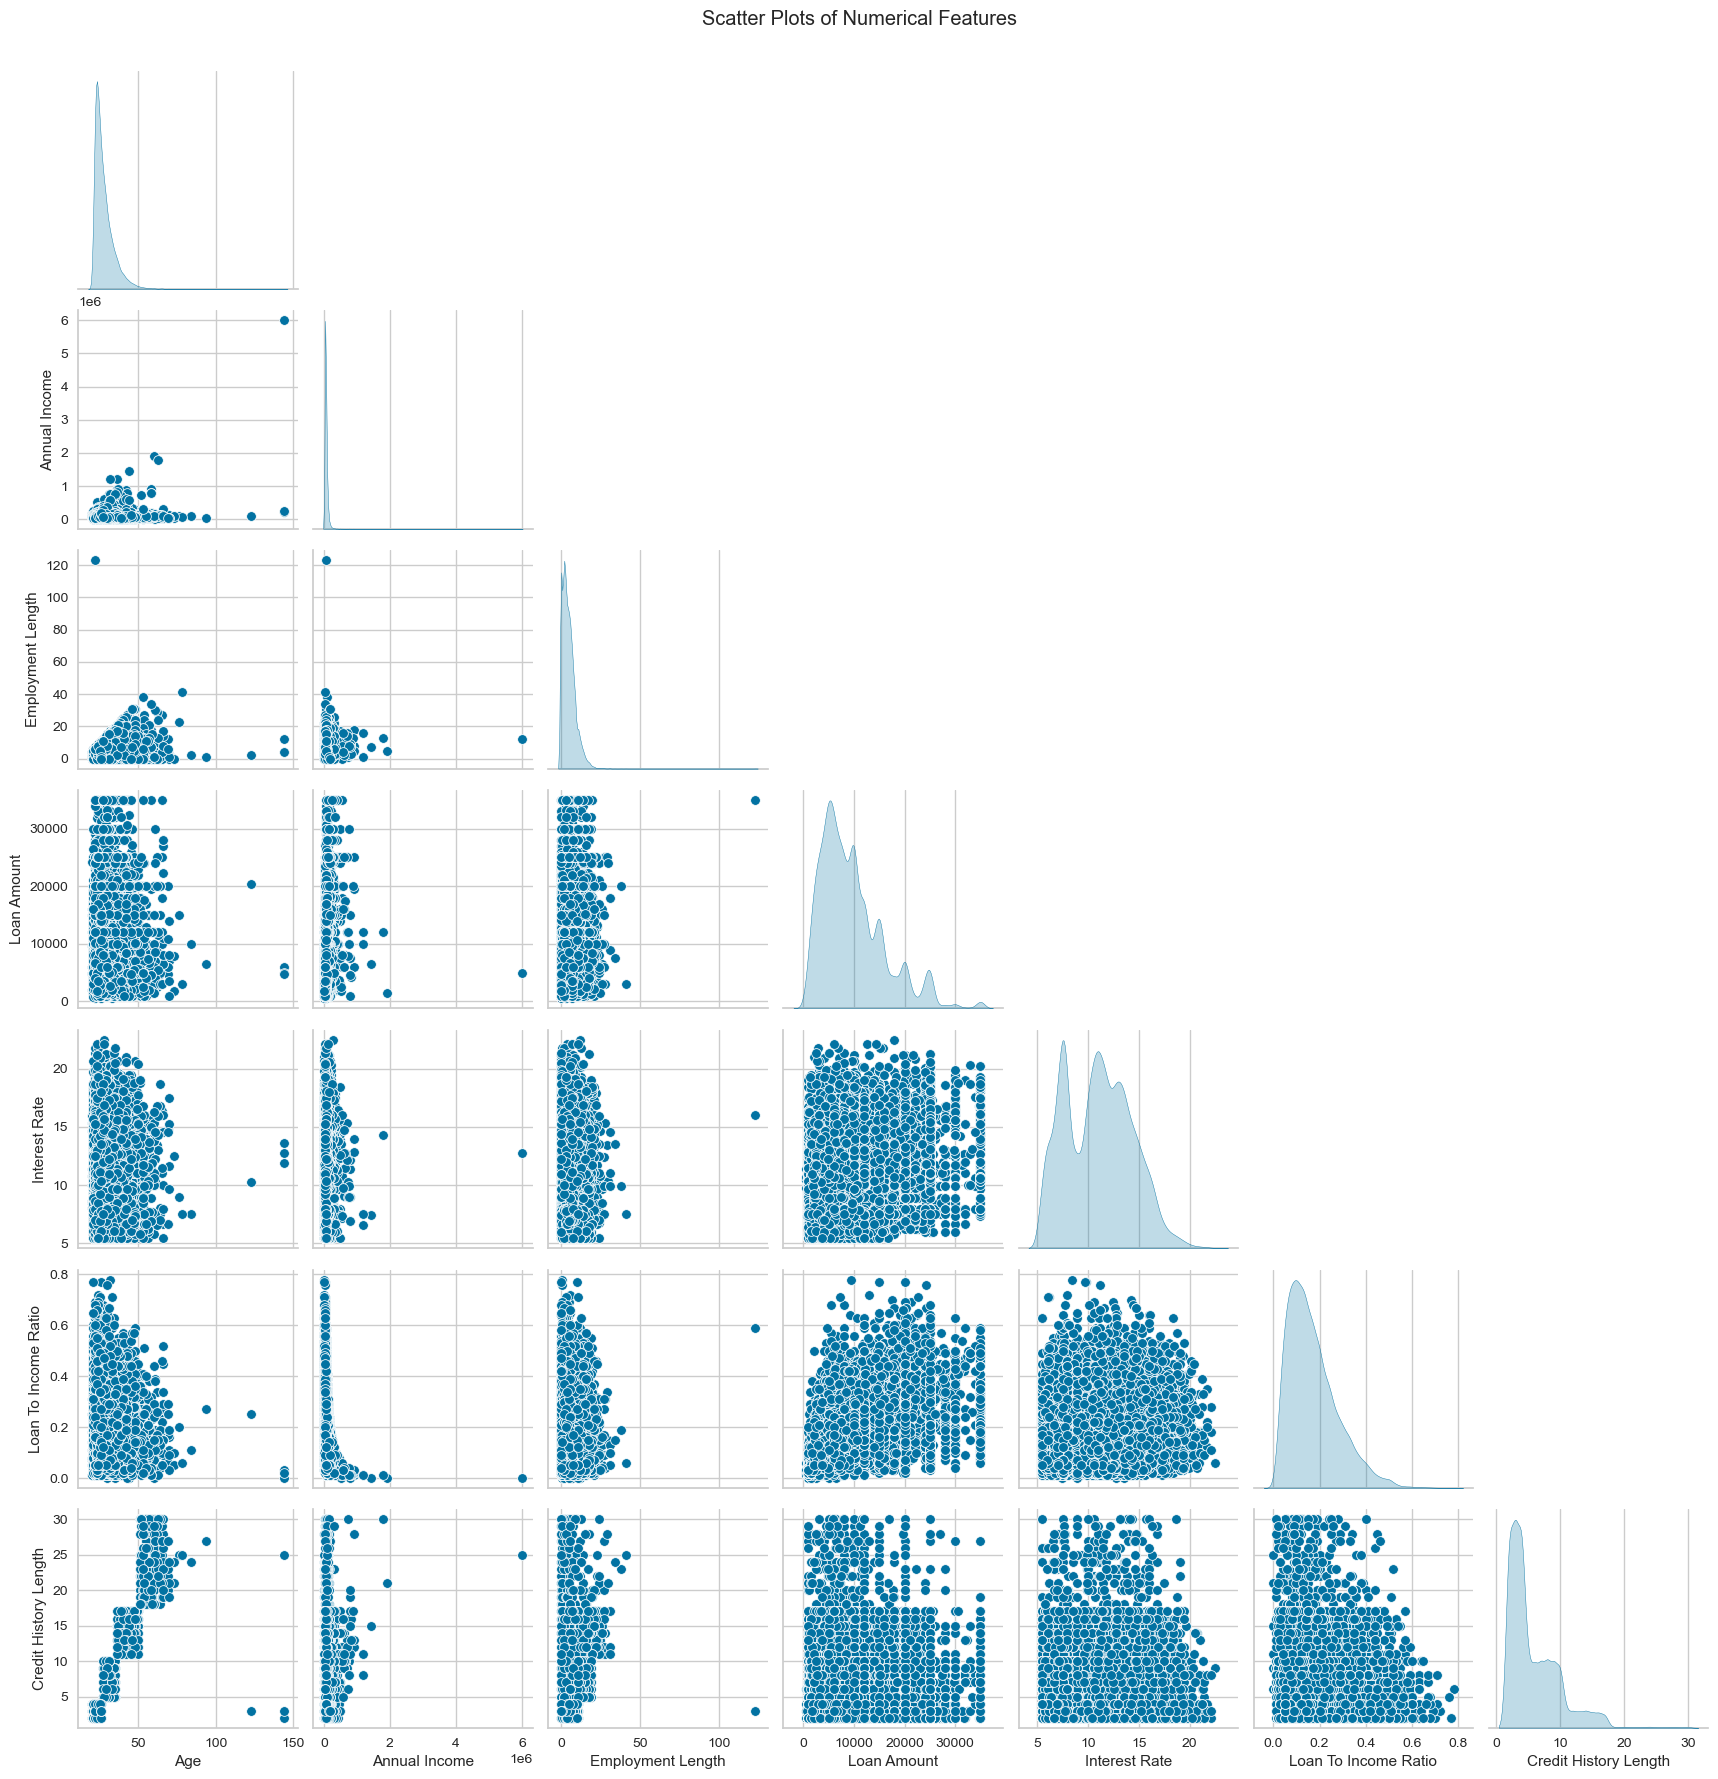

In [108]:
numerical_cols = [
    'Age', 'Annual Income', 'Employment Length',
    'Loan Amount', 'Interest Rate', 'Loan To Income Ratio',
    'Credit History Length'
]

plt.figure(figsize=(10, 8))
correlation_matrix = train_data_copy[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

sns.pairplot(train_data_copy[numerical_cols], diag_kind='kde', corner=True)
plt.suptitle('Scatter Plots of Numerical Features', y=1.02)
plt.show()


**Interpretation:**
- We can see a strong positive linear correlation between Age and Credit History Length (correlation = 0.86). 
- This makes intuitive sense: the older a person is, the longer their credit history tends to be. 
- This is a typical multicollinearity issue, where two features are highly correlated. 
- In a modeling context, we might consider removing one of them to avoid redundancy.

- Another interesting trend is the positive correlation between Loan Amount and Loan To Income Ratio (correlation = 0.57). 
- This also makes sense: as the loan amount increases relative to a person's income, the loan-to-income ratio will naturally go up. 
- This feature pair doesn’t necessarily indicate a multicollinearity problem, but it does highlight how these variables interact and may affect loan risk assessment.

##### 4.1.1.1)  Age and Credit History Length

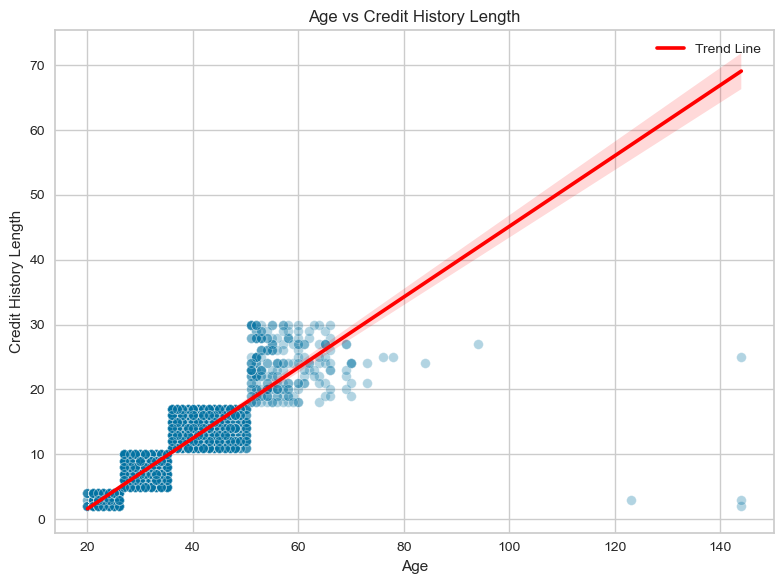

In [111]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_data_copy, x='Age', y='Credit History Length', alpha=0.3)
sns.regplot(data=train_data_copy, x='Age', y='Credit History Length', scatter=False, color='red', label='Trend Line')

plt.title('Age vs Credit History Length')
plt.xlabel('Age')
plt.ylabel('Credit History Length')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Interpretation:**
- We can see a strong positive linear correlation between Age and Credit History Length (correlation ≈ 0.86).
- This makes intuitive sense: the older a person is, the longer their credit history tends to be.
- This is a typical multicollinearity issue, where two features are highly correlated.
- In a modeling context, we might consider removing one of them to avoid redundancy.

- There are noticeable outliers with extremely high age values (e.g., > 120) and unusually short credit history, which may indicate data entry errors.
- Removing or correcting these outliers could improve model performance and avoid distortion in trend lines.
- The overall trend remains consistent despite these anomalies, suggesting the relationship is robust but still benefits from data cleaning.

##### 4.1.1.2) Loan Amount and Loan To Income Ratio

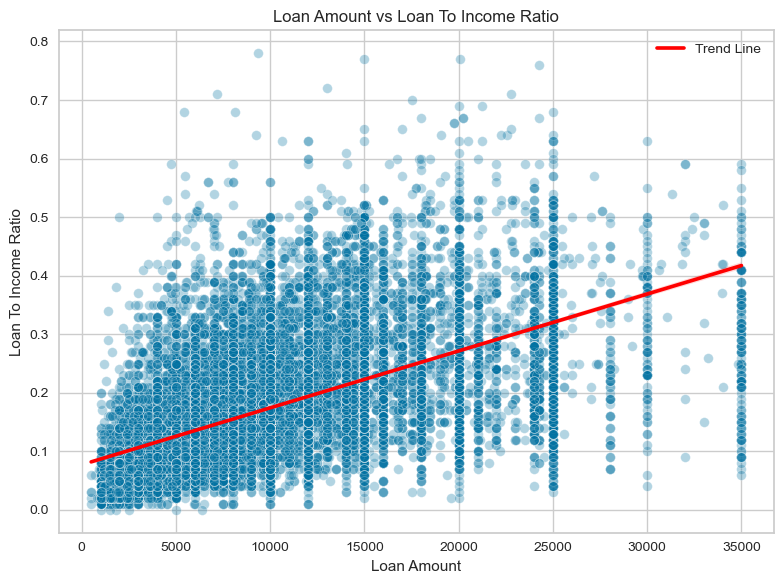

In [114]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_data_copy, x='Loan Amount', y='Loan To Income Ratio', alpha=0.3)
sns.regplot(data=train_data_copy, x='Loan Amount', y='Loan To Income Ratio', scatter=False, color='red', label='Trend Line')

plt.title('Loan Amount vs Loan To Income Ratio')
plt.xlabel('Loan Amount')
plt.ylabel('Loan To Income Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Interpretation:**
- There is a moderate positive correlation between Loan Amount and Loan To Income Ratio (correlation ≈ 0.57).
- This relationship is logical: as the loan amount increases, the loan-to-income ratio tends to rise as well, since the ratio is directly dependent on the loan amount relative to income.
- This feature pair doesn’t necessarily indicate a multicollinearity issue, but it highlights an important interaction that may influence loan risk assessment.

- The scatter shows a wide spread, indicating that while the overall trend is upward, many individual cases vary significantly.
- There are also some vertical lines, likely due to repeated loan amount values — possibly representing standardized loan packages or policy-defined amounts.
- Understanding these clusters could offer insights into lending practices or borrower behavior.

##### 4.1.1.3) Annual Income and Loan To Income Ratio

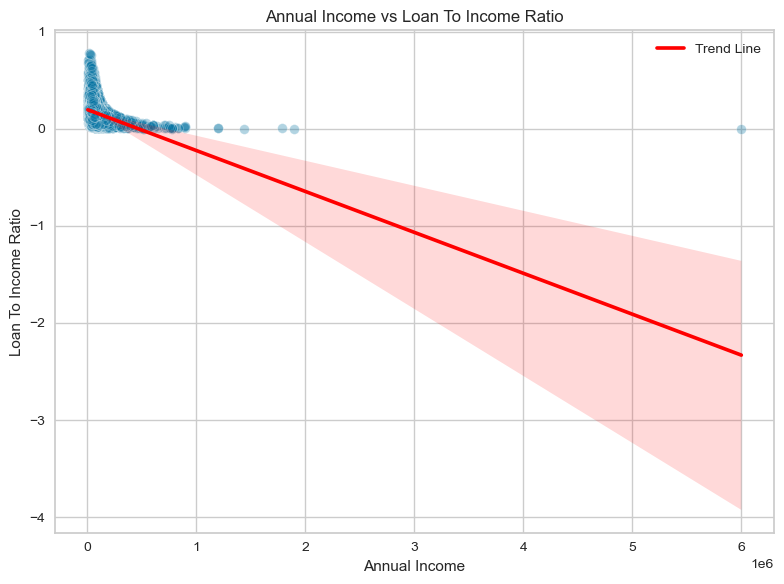

In [117]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_data_copy, x='Annual Income', y='Loan To Income Ratio', alpha=0.3)
sns.regplot(data=train_data_copy, x='Annual Income', y='Loan To Income Ratio', scatter=False, color='red', label='Trend Line')

plt.title('Annual Income vs Loan To Income Ratio')
plt.xlabel('Annual Income')
plt.ylabel('Loan To Income Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Interpretation:**
- There is a strong negative correlation between Annual Income and Loan To Income Ratio.
- This makes intuitive sense: as a person's income increases, the loan amount becomes a smaller proportion of their income, leading to a lower loan-to-income ratio.
- The relationship appears to follow a non-linear pattern, especially for incomes below 1 million, where most data points are concentrated and the ratio drops rapidly.
- The regression line and wide confidence interval suggest the presence of a few outliers with extremely high income, possibly skewing the fit.
- While this doesn’t indicate a multicollinearity issue, it highlights a key insight: income is a dominant factor in determining an individual's loan risk, as measured by loan-to-income ratio.

### 4.2) Numerical vs categorical features (ANOVA)

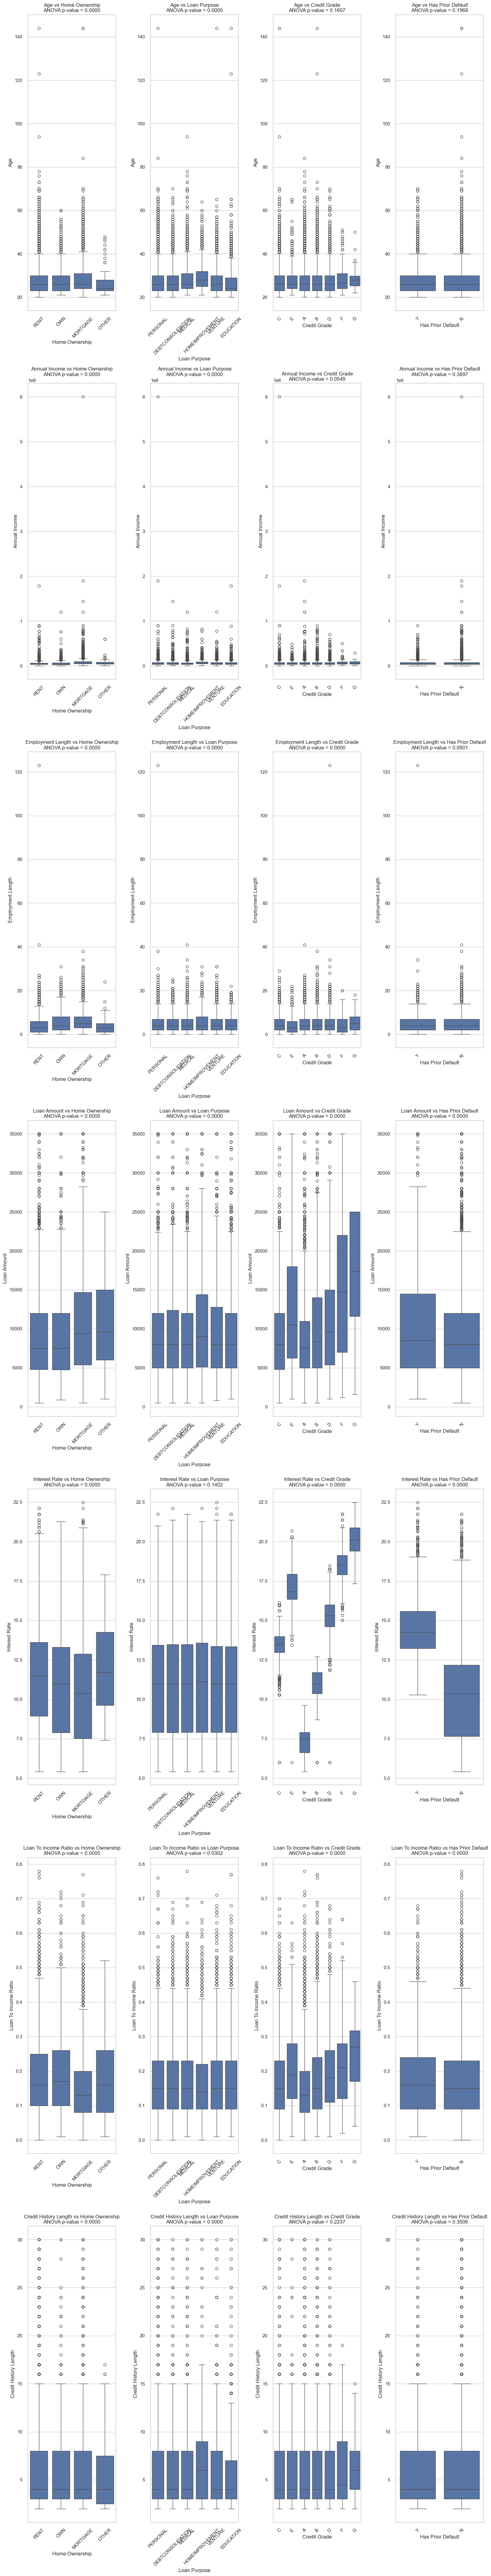

In [120]:
numerical_cols = ['Age', 'Annual Income', 'Employment Length', 'Loan Amount',
                  'Interest Rate', 'Loan To Income Ratio', 'Credit History Length']

categorical_cols = ['Home Ownership', 'Loan Purpose', 'Credit Grade', 'Has Prior Default']

sns.set(style="whitegrid")
plt.figure(figsize=(16, len(numerical_cols) * len(categorical_cols) * 3))

plot_number = 1

for num_col in numerical_cols:
    for cat_col in categorical_cols:
        sub_df = train_data_copy[[num_col, cat_col]].dropna()
        
        groups = [group[num_col].values for name, group in sub_df.groupby(cat_col)]
        
        f_stat, p_val = f_oneway(*groups)

        plt.subplot(len(numerical_cols), len(categorical_cols), plot_number)
        sns.boxplot(data=sub_df, x=cat_col, y=num_col)
        plt.xticks(rotation=45)
        plt.title(f'{num_col} vs {cat_col}\nANOVA p-value = {p_val:.4f}')
        plot_number += 1

plt.tight_layout()
plt.show()

**Interpretation:**
- Those who hold a mortgage tend to be older, have higher incomes, longer employment and credit histories, take out larger loans, pay lower interest rates and carry lower loan-to-income ratios compared with renters or outright owners.
- Those who rent are generally younger, earn less, have shorter job tenures and credit histories, borrow smaller amounts, pay moderate rates, and have mid-range loan-to-income ratios.
- Borrowers using loans for home improvement show the highest median income, longest employment and credit history, and largest loan amounts, whereas those borrowing for education are the youngest, earn the least, have the shortest histories, and take smaller loans at similar rates.
- Debt-consolidation loans are associated with higher incomes and loan-to-income ratios, but only moderate employment and credit history lengths.
- Credit Grade A–B applicants enjoy the lowest interest rates, small loan-to-income ratios, and moderate loan amounts, while grades F–G face the highest rates, largest loans, and highest ratios.
- Having a prior default correlates with shorter employment, larger loan amounts, higher interest rates, and higher loan-to-income ratios—but it does not significantly affect age, income level, or credit history length.
- Credit Grade and default history show no clear link to age or credit history length, confirming their impact is specific to borrowing terms rather than borrower demographics.

### 4.3) Categorical vs categorical features (Chi-square test)

Null hypothesis: the feature's categories have no effect on the target variable. 
Alternate hypothesis: one(or more) of the feature categories has a significant effect on the target variable.

In [124]:
def chi_func(df, feature):
    df = df[[feature, 'Loan Default']].dropna()
    
    high_risk_ft = df[df['Loan Default'] == 1][feature]

    high_risk_ft_ct = pd.crosstab(index=high_risk_ft, columns=['Count']).rename_axis(None, axis=1)
    high_risk_ft_ct.index.name = None

    # Observed
    obs = high_risk_ft_ct
    print('Observed values:\n')
    print(obs)
    print('\n')

    # Expected
    exp = pd.DataFrame([obs['Count'].sum() / len(obs)] * len(obs), columns=['Count'], index=obs.index)
    print('Expected values:\n')
    print(exp)
    print('\n')

    # Chi-square
    chi_squared_stat = (((obs - exp) ** 2) / exp).sum()
    print('Chi-square:\n')
    print(chi_squared_stat[0])
    print('\n')

    crit = stats.chi2.ppf(q=0.95, df=len(obs) - 1)
    print('Critical value:\n')
    print(crit)
    print('\n')

    # P-value
    p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=len(obs) - 1)
    print('P-value:\n')
    print(p_value[0])
    print('\n')

    if chi_squared_stat[0] >= crit:
        print('❌ Reject the null hypothesis', feature, 'and Loan Default.')
    else:
        print('✅ Fail to reject the null hypothesis', feature, 'and Loan Default.')

In [125]:
cat_ft = ['Home Ownership', 'Loan Purpose', 'Credit Grade', 'Has Prior Default']
for ft in cat_ft:
    print('\n\n**** {} ****\n'.format(ft))
    chi_func(train_data_copy, ft)



**** Home Ownership ****

Observed values:

          Count
MORTGAGE   1336
OTHER        25
OWN         159
RENT       4143


Expected values:

           Count
MORTGAGE 1415.75
OTHER    1415.75
OWN      1415.75
RENT     1415.75


Chi-square:

7739.967331802932


Critical value:

7.814727903251179


P-value:

0.0


❌ Reject the null hypothesis Home Ownership and Loan Default.


**** Loan Purpose ****

Observed values:

                   Count
DEBTCONSOLIDATION   1203
EDUCATION            900
HOMEIMPROVEMENT      730
MEDICAL             1273
PERSONAL             888
VENTURE              669


Expected values:

                   Count
DEBTCONSOLIDATION 943.83
EDUCATION         943.83
HOMEIMPROVEMENT   943.83
MEDICAL           943.83
PERSONAL          943.83
VENTURE           943.83


Chi-square:

319.7755606568956


Critical value:

11.070497693516351


P-value:

0.0


❌ Reject the null hypothesis Loan Purpose and Loan Default.


**** Credit Grade ****

Observed values:

   Count
A  

**Interpretation:** All categorical variables have high statistical significance (p-value < 0.05), indicating that they are not independent of Loan Default.

## 5) Business findings from the EDA

#### 1. High Loan-to-Income Ratio Indicates Higher Risk
- **Finding**: Borrowers who default tend to have a significantly higher Loan-to-Income Ratio.
- **Implication**:
  - Set a maximum threshold for Loan-to-Income Ratio (e.g., 30–40%) during approval.
  - Consider additional requirements (e.g., collateral) for borderline cases.

---

#### 2. Higher Interest Rates Correlate with Loan Defaults
- **Finding**: Defaulted borrowers are typically charged higher interest rates.
- **Implication**:
  - Reassess risk-based pricing models to avoid over-penalizing potentially recoverable customers.
  - Offer flexible rate programs or incentive-based reductions.

---

#### 3. Presence of Outliers in Age and Income
- **Finding**: Implausible values such as age 144 and income >6M detected.
- **Implication**:
  - Implement validation rules (e.g., age range 18–75).
  - Flag extreme values for manual review or clean from dataset.

---

#### 4. Credit Grade Strongly Influences Loan Terms
- **Finding**:
  - Grades A–B dominate the dataset and enjoy lower interest rates and safer ratios.
  - Grades F–G are rare but face high risk terms.
- **Implication**:
  - Promote Grade C–D borrowers with tailored risk-based offers.
  - Launch “Credit Boost” programs to improve onboarding of mid-tier credit customers.

---

#### 5. Prior Default History Signals Risk
- **Finding**: Applicants with prior defaults have higher loan amounts, interest rates, and loan-to-income ratios.
- **Implication**:
  - Apply stricter review or collateral requirements.
  - Develop “Credit Rebuild” loan products to re-engage this segment responsibly.

---

#### 6. Loan Purpose Provides Segmentation Opportunities
- **Finding**:
  - Top reasons: Education (19.7%) and Medical (18.6%).
  - Lowest: Home Improvement (11%).
- **Implication**:
  - Create targeted loan programs for education and healthcare.
  - Partner with home improvement vendors to offer bundled financing deals.

#  IV) Prepare the data

## 1) Transform to be done on each feature

### 🔧 Feature Transformation Plan

---

### Age:
- Remove outliers (e.g., age > 100)
- Fix skewness
- Min-max scaling

---

### Annual Income:
- Remove outliers (e.g., income > 1,000,000)
- Fix skewness
- Min-max scaling

---

### Home Ownership:
- One-hot encoding (4 categories: RENT, MORTGAGE, OWN, OTHER)

---

### Employment Length:
- Impute missing values (e.g., with median)
- Remove outliers (e.g., > 20 years)
- Min-max scaling

---

### Loan Purpose:
- One-hot encoding (6 categories)

---

### Credit Grade:
- Ordinal encoding (A-G mapped to 1–7)
- Consider grouping lower grades (F, G) if sample size is small

---

### Loan Amount:
- Remove outliers (e.g., > 35,000)
- Min-max scaling

---

### Interest Rate:
- Impute missing values (e.g., with median by credit grade)
- Min-max scaling

---

### Loan Default (Target):
- Change data type to numerical (0 = No, 1 = Yes)
- Balance data using SMOTE or class weighting

---

### Loan to Income Ratio:
- Fix skewness
- Remove outliers
- Min-max scaling

---

### Has Prior Default:
- Convert to numerical (N = 0, Y = 1)
- One-hot encoding (optional depending on model)

---

### Credit History Length:
- Remove outliers (e.g., > 25–30 years)
- Min-max scaling

---

### Age vs. Credit History Length:
- High correlation → Consider removing one to reduce multicollinearity
- Preferred: Keep **Credit History Length** (more financially relevant)

## 2) Data Cleaning

### 2.1) Outliers handling

In [134]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_outliers=['Age', 'Annual Income', 'Loan Amount', 'Interest Rate', 'Loan To Income Ratio', 'Employment Length', 'Credit History Length']):
        self.feat_with_outliers = feat_with_outliers

    def fit(self, df, y=None):
        return self

    def transform(self, df):
        if set(self.feat_with_outliers).issubset(df.columns):
            Q1 = df[self.feat_with_outliers].quantile(0.25)
            Q3 = df[self.feat_with_outliers].quantile(0.75)
            IQR = Q3 - Q1
            condition = ~((df[self.feat_with_outliers] < (Q1 - 3 * IQR)) | 
                          (df[self.feat_with_outliers] > (Q3 + 3 * IQR))).any(axis=1)
            df_cleaned = df[condition].copy()
            return df_cleaned
        else:
            missing_features = list(set(self.feat_with_outliers) - set(df.columns))
            print(f"Missing features in dataframe: {missing_features}")
            return df

## 3) Feature selection

### 3.1) Drop features

In [137]:
class DropFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, feature_to_drop=['Age']):
        self.feature_to_drop = feature_to_drop

    def fit(self, df, y=None):
        return self

    def transform(self, df):
        if set(self.feature_to_drop).issubset(df.columns):
            df = df.drop(self.feature_to_drop, axis=1)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df


We drop the `Age` feature because:

- It has a high correlation with `Credit History Length`.
- It does not directly reflect creditworthiness or repayment ability.
- It contains outliers (e.g., an applicant aged 144), which may distort the analysis.
- `Credit History Length` is a more domain-specific credit feature and is commonly used in credit scoring models.


## 4) Feature engineering

In [140]:
# Handle skewness
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self, features=['Annual Income', 'Loan Amount']):
        self.features = features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.features] = X[self.features].apply(np.cbrt)
        return X

# Min-Max scaling
class MinMaxScalerWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, features=['Annual Income', 'Loan Amount', 'Loan To Income Ratio', 'Interest Rate', 'Employment Length', 'Credit History Length']):
        self.features = features
        self.scaler = MinMaxScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X[self.features])
        return self

    def transform(self, X):
        X[self.features] = self.scaler.transform(X[self.features])
        return X

# One-hot encoding
class OneHotEncoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, features=['Home Ownership', 'Loan Purpose']):
        self.features = features
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    def fit(self, X, y=None):
        self.encoder.fit(X[self.features])
        return self

    def transform(self, X):
        encoded = self.encoder.transform(X[self.features])
        encoded_df = pd.DataFrame(encoded, columns=self.encoder.get_feature_names_out(self.features), index=X.index)
        X = X.drop(columns=self.features)
        return pd.concat([X, encoded_df], axis=1)

# Ordinal encoding
class OrdinalEncoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, features=['Credit Grade']):
        self.features = features
        self.encoder = OrdinalEncoder()

    def fit(self, X, y=None):
        self.encoder.fit(X[self.features])
        return self

    def transform(self, X):
        X[self.features] = self.encoder.transform(X[self.features])
        return X

# Binary mapping (e.g., Yes/No, Y/N)
class BinaryMapper(BaseEstimator, TransformerMixin):
    def __init__(self, mapping_features={'Has Prior Default': {'Y': 1, 'N': 0}}):
        self.mapping_features = mapping_features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for feature, mapping in self.mapping_features.items():
            X[feature] = X[feature].map(mapping)
        return X

# Imputer for missing values
class ImputerWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mean', features=['Employment Length', 'Interest Rate']):
        self.strategy = strategy
        self.features = features

    def fit(self, X, y=None):
        if self.strategy == 'mean':
            self.fill_values = X[self.features].mean()
        elif self.strategy == 'median':
            self.fill_values = X[self.features].median()
        else:
            self.fill_values = X[self.features].mode().iloc[0]
        return self

    def transform(self, X):
        X[self.features] = X[self.features].fillna(self.fill_values)
        return X

# Oversampling minority class using SMOTE
class Oversample(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, df, y=None):
        return self

    def transform(self, df):
        if 'Loan Default' in df.columns:
            oversample = SMOTE(sampling_strategy='minority')
            X_bal, y_bal = oversample.fit_resample(df.loc[:, df.columns != 'Loan Default'], df['Loan Default'])
            df_bal = pd.concat([pd.DataFrame(X_bal), pd.DataFrame(y_bal, columns=['Loan Default'])], axis=1)
            return df_bal
        else:
            print("Loan Default is not in the dataframe")
            return df

We are oversampling with SMOTE because the minority class (Is high risk = 1) is very rare in the data.

## 5) Data Preprocessing

In [143]:
def full_pipeline(df):
    pipeline = Pipeline([
        ('imputer', ImputerWrapper()),
        ('outlier_remover', OutlierRemover()),
        ('drop_features', DropFeatures()),
        ('skewness_handler', SkewnessHandler()),
        ('binary_mapper', BinaryMapper()),
        ('ordinal_encoder', OrdinalEncoderWrapper()),
        ('one_hot_encoder', OneHotEncoderWrapper()),
        ('min_max_scaler', MinMaxScalerWrapper()),
        ('oversample', Oversample())
    ])
    
    df_processed = pipeline.fit_transform(df)
    return df_processed

In [144]:
pd.options.mode.chained_assignment = None  # Hide the copy warning
train_data_prep = full_pipeline(train_data_copy)

In [145]:
train_data_prep.shape

(39662, 19)

In [146]:
pd.set_option('display.max_columns', None)
train_data_prep.head()

Annual Income  Employment Length  Credit Grade  Loan Amount  Interest Rate  \
0           0.32               0.00          4.00         0.51           0.66   
1           0.50               0.14          2.00         0.71           0.46   
2           0.52               0.27          0.00         0.42           0.15   
3           0.63               0.14          2.00         0.46           0.43   
4           0.62               0.50          0.00         0.56           0.33   

   Loan To Income Ratio  Has Prior Default  Credit History Length  \
0                  0.50                  0                   0.05   
1                  0.47                  1                   0.05   
2                  0.16                  0                   0.10   
3                  0.12                  0                   0.05   
4                  0.19                  0                   0.24   

   Home Ownership_MORTGAGE  Home Ownership_OTHER  Home Ownership_OWN  \
0                     0.00                  0.00                1.00   
1                     1.00                  0.00                0.00   
2                     1.00                  0.00                0.00   
3                     0.00                  0.00                0.00   
4                     1.00                  0.00                0.00   

   Home Ownership_RENT  Loan Purpose_DEBTCONSOLIDATION  \
0                 0.00                            1.00   
1                 0.00                            0.00   
2                 0.00                            0.00   
3                 1.00                            0.00   
4                 0.00                            0.00   

   Loan Purpose_EDUCATION  Loan Purpose_HOMEIMPROVEMENT  Loan Purpose_MEDICAL  \
0                    0.00                          0.00                  0.00   
1                    0.00                          0.00                  0.00   
2                    0.00                          0.00                  1.00   
3                    0.00                          0.00                  0.00   
4                    0.00                          1.00                  0.00   

   Loan Purpose_PERSONAL  Loan Purpose_VENTURE  Loan Default  
0                   0.00                  0.00             1  
1                   1.00                  0.00             0  
2                   0.00                  0.00             0  
3                   1.00                  0.00             0  
4                   0.00                  0.00             0

In [147]:
# split the train data into X and y (target)
X_cc_train_prep, y_cc_train_prep = train_data_prep.loc[:, train_data_prep.columns != 'Loan Default'], train_data_prep['Loan Default'].astype('int64')

# V) Short-list promising models

## 1) Models training

In [150]:
classifiers = {
    'sgd':SGDClassifier(random_state=42,loss='perceptron'),
    'logistic_regression':LogisticRegression(random_state=42,max_iter=1000),
    'support_vector_machine':SVC(random_state=42,probability=True),
    'decision_tree':DecisionTreeClassifier(random_state=42),
    'random_forest':RandomForestClassifier(random_state=42),
    'gaussian_naive_bayes':GaussianNB(),
    'k_nearest_neighbors':KNeighborsClassifier(),
    'gradient_boosting':GradientBoostingClassifier(random_state=42),
    'linear_discriminant_analysis':LinearDiscriminantAnalysis(),
    'bagging':BaggingClassifier(random_state=42),
    'neural_network':MLPClassifier(random_state=42,max_iter=1000),
    'adaboost':AdaBoostClassifier(random_state=42),
    'extra_trees':ExtraTreesClassifier(random_state=42),
    }

In [151]:
# Function to get the feature importance of the classifier, and plot it
def feat_importance_plot(model_trn, model_name):
    if model_name not in ['sgd','support_vector_machine','gaussian_naive_bayes','k_nearest_neighbors','bagging','neural_network']:
        # change xtick font size
        plt.rcParams['xtick.labelsize'] = 12
        plt.rcParams['ytick.labelsize'] = 12
        # top 10 most predictive features
        top_10_feat = FeatureImportances(model_trn, relative=False, topn=10)
        # top 10 least predictive features
        bottom_10_feat = FeatureImportances(model_trn, relative=False, topn=-10)
        #change the figure size
        plt.figure(figsize=(10, 4))
        #change x label font size
        plt.xlabel('xlabel', fontsize=14)
        # Fit to get the feature importances
        top_10_feat.fit(X_cc_train_prep, y_cc_train_prep)
        # show the plot
        top_10_feat.show()
        print('\n')
        plt.figure(figsize=(10, 4))
        plt.xlabel('xlabel', fontsize=14)
        # Fit to get the feature importances
        bottom_10_feat.fit(X_cc_train_prep, y_cc_train_prep)
        # show the plot
        bottom_10_feat.show()
        print('\n')
    else:
        print('No feature importance for {0}'.format(model_name))
        print('\n')

In [152]:
# Function to get the y prediction
def y_prediction_func(model_trn,model_name,final_model=False):
    if final_model == False:
        # check if y_train_copy_pred exists, if not create it
        y_cc_train_pred_path = Path('saved_models/{0}/y_train_copy_pred_{0}.sav'.format(model_name))
        try:
            y_cc_train_pred_path.resolve(strict=True)
        except FileNotFoundError:
            #cross validation prediction with kfold = 10
            y_cc_train_pred = cross_val_predict(model_trn,X_cc_train_prep,y_cc_train_prep,cv=10,n_jobs=-1)
            #save the predictions
            joblib.dump(y_cc_train_pred,y_cc_train_pred_path)
            return y_cc_train_pred
        else:
            # if it exist load the predictions
            y_cc_train_pred = joblib.load(y_cc_train_pred_path)
            return y_cc_train_pred
    else:
        # check if y_train_copy_pred exists, if not create it
        y_cc_train_pred_path_final = Path('saved_models_final/{0}/y_train_copy_pred_{0}_final.sav'.format(model_name))
        try:
            y_cc_train_pred_path_final.resolve(strict=True)
        except FileNotFoundError:
            #cross validation prediction with kfold = 10
            y_cc_train_pred_final = cross_val_predict(model_trn,X_cc_train_prep,y_cc_train_prep,cv=10,n_jobs=-1)
            #save the predictions
            joblib.dump(y_cc_train_pred_final,y_cc_train_pred_path_final)
            return y_cc_train_pred_final
        else:
            # if it exist load the predictions
            y_cc_train_pred_final = joblib.load(y_cc_train_pred_path_final)
            return y_cc_train_pred_final

In [153]:
# Function to plot the confusion matrix
def confusion_matrix_func(model_trn,model_name,final_model=False):
    if final_model == False:
        fig, ax = plt.subplots(figsize=(8,8))
        #plot confusion matrix
        conf_matrix = ConfusionMatrixDisplay.from_predictions(y_cc_train_prep,y_prediction_func(model_trn,model_name),ax=ax, cmap='Blues',values_format='d')
        # remove the grid
        plt.grid(visible=None)
        # increase the font size of the x and y labels
        plt.xlabel('Predicted label', fontsize=14)
        plt.ylabel('True label', fontsize=14)
        #give a title to the plot using the model name
        plt.title('Confusion Matrix', fontsize=14)
        #show the plot
        plt.show()
        print('\n')
    else:
        fig, ax = plt.subplots(figsize=(8,8))
        #plot confusion matrix
        conf_matrix_final = ConfusionMatrixDisplay.from_predictions(y_cc_train_prep,y_prediction_func(model_trn,model_name,final_model=True),ax=ax, cmap='Blues',values_format='d')
        # remove the grid
        plt.grid(visible=None)
        # increase the font size of the x and y labels
        plt.xlabel('Predicted label', fontsize=14)
        plt.ylabel('True label', fontsize=14)
        #give a title to the plot using the model name
        plt.title('Confusion Matrix', fontsize=14)
        #show the plot
        plt.show()
        print('\n')

In [154]:
# Function to plot the roc curve
def roc_curve_func(model_trn,model_name,final_model=False):
    if final_model == False:
        # check if y probabilities file exists, if not create it
        y_proba_path = Path('saved_models/{0}/y_cc_train_proba_{0}.sav'.format(model_name))
        try:
            y_proba_path.resolve(strict=True)
        except FileNotFoundError:
            y_cc_train_proba = model_trn.predict_proba(X_cc_train_prep)
            joblib.dump(y_cc_train_proba,y_proba_path)
        else:
            # if path exist load the y probabilities file
            y_cc_train_proba = joblib.load(y_proba_path)
        skplt.metrics.plot_roc(y_cc_train_prep, y_cc_train_proba, title = 'ROC curve for {0}'.format(model_name), cmap='cool',figsize=(8,6), text_fontsize='large')
        #remove the grid
        plt.grid(visible=None)
        plt.show()
        print('\n')
    else:
        # check if y probabilities file exists, if not create it
        y_proba_path_final = Path('saved_models_final/{0}/y_cc_train_proba_{0}_final.sav'.format(model_name))
        try:
            y_proba_path_final.resolve(strict=True)
        except FileNotFoundError:
            y_cc_train_proba_final = model_trn.predict_proba(X_cc_train_prep)
            joblib.dump(y_cc_train_proba_final,y_proba_path_final)
        else:
            # if path exist load the y probabilities file
            y_cc_train_proba_final = joblib.load(y_proba_path_final)
        skplt.metrics.plot_roc(y_cc_train_prep, y_cc_train_proba_final, title = 'ROC curve for {0}'.format(model_name), cmap='cool',figsize=(8,6), text_fontsize='large')
        #remove the grid
        plt.grid(visible=None)
        plt.show()
        print('\n')

In [155]:
# Function to display the classification report
def score_func(model_trn, model_name, final_model=False):
    if final_model == False:
        class_report = classification_report(y_cc_train_prep,y_prediction_func(model_trn,model_name))
        print(class_report)
    else:
        class_report_final = classification_report(y_cc_train_prep,y_prediction_func(model_trn,model_name,final_model=True))
        print(class_report_final)

In [156]:
# Function to train the model
def train_model(model,model_name,final_model=False):
    # if we are not training the final model
    if final_model == False:
        # check if the model file exist and if not create, train and save it
        model_file_path = Path('saved_models/{0}/{0}_model.sav'.format(model_name))
        try:
            model_file_path.resolve(strict=True)
        except FileNotFoundError:
            if model_name == 'sgd':
                # for sgd, loss = 'hinge' does not have a predict_proba method. Therefore, we use a calibrated model
                calibrated_model = CalibratedClassifierCV(model, cv=10, method='sigmoid')
                model_trn = calibrated_model.fit(X_cc_train_prep,y_cc_train_prep)
            else:
                model_trn = model.fit(X_cc_train_prep,y_cc_train_prep)
            joblib.dump(model_trn,model_file_path)
            # plot the most and least predictive features
            return model_trn
        else:
            # if path exist load the model
            model_trn = joblib.load(model_file_path)
            # plot the most and least predictive features
            return model_trn
    else:
        # check if the final model file exist and if not create, train and save it
        final_model_file_path = Path('saved_models_final/{0}/{0}_model.sav'.format(model_name))
        try:
            final_model_file_path.resolve(strict=True)
        except FileNotFoundError:
            model_trn = model.fit(X_cc_train_prep,y_cc_train_prep)
            joblib.dump(model_trn,final_model_file_path)
            # plot the most and least predictive features
            return model_trn
        else:
            # if path exist load the model
            model_trn = joblib.load(final_model_file_path)
            # plot the most and least predictive features
            return model_trn

In [157]:
def folder_check_model():
    # check if the folder for saving the model exists, if not create it
    if not os.path.exists('saved_models/{}'.format(model_name)):
        os.makedirs('saved_models/{}'.format(model_name))





----------------------  sgd  ----------------------


              precision    recall  f1-score   support

           0       0.79      0.79      0.79     19831
           1       0.79      0.79      0.79     19831

    accuracy                           0.79     39662
   macro avg       0.79      0.79      0.79     39662
weighted avg       0.79      0.79      0.79     39662



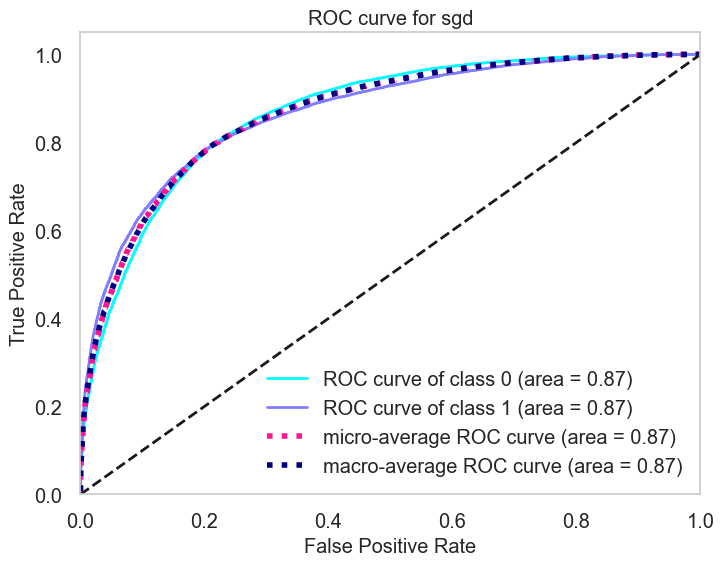

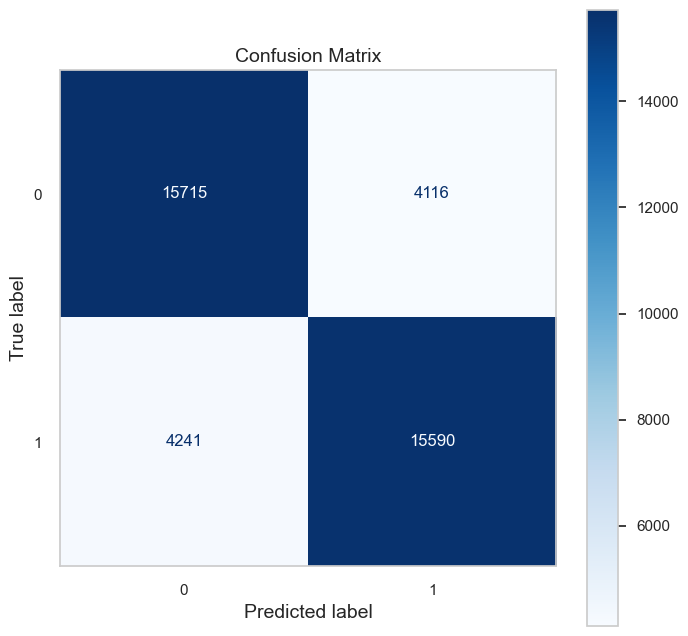



No feature importance for sgd






----------------------  logistic_regression  ----------------------


              precision    recall  f1-score   support

           0       0.80      0.80      0.80     19831
           1       0.80      0.80      0.80     19831

    accuracy                           0.80     39662
   macro avg       0.80      0.80      0.80     39662
weighted avg       0.80      0.80      0.80     39662



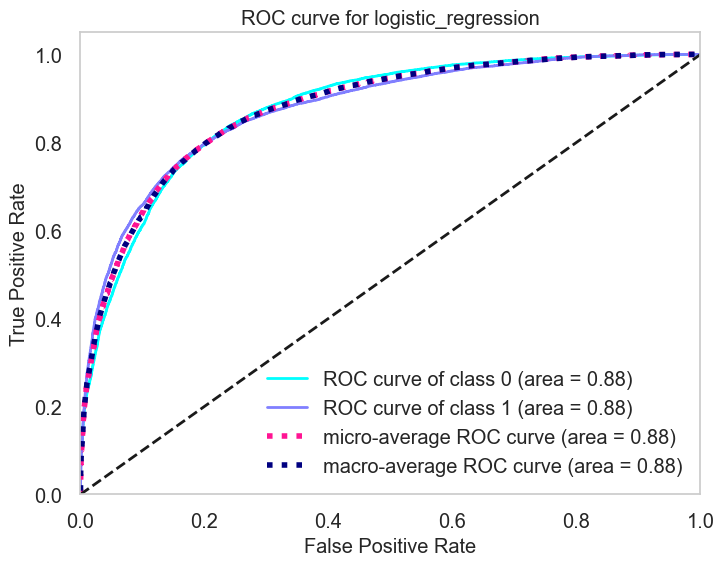

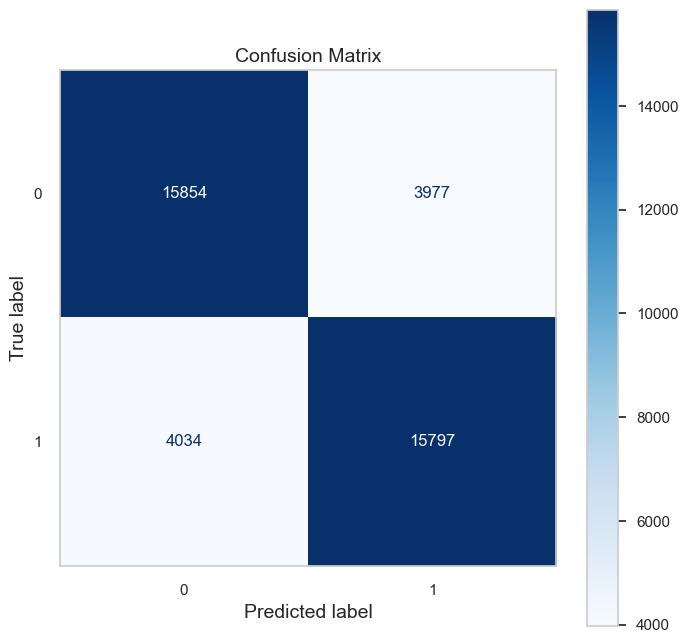

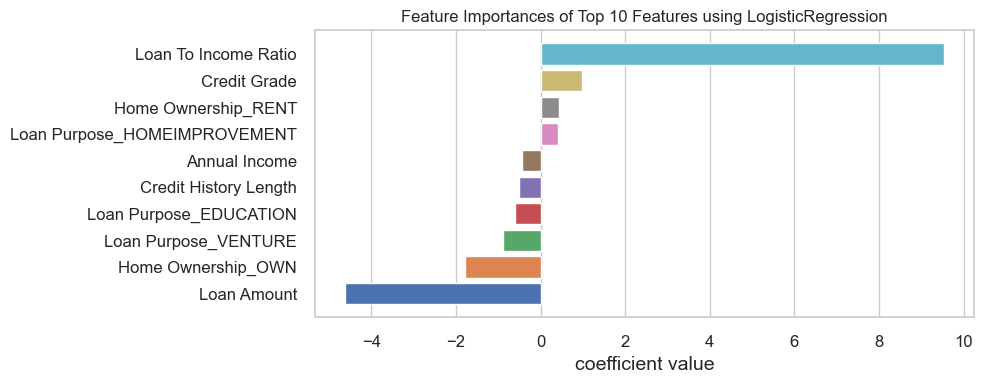

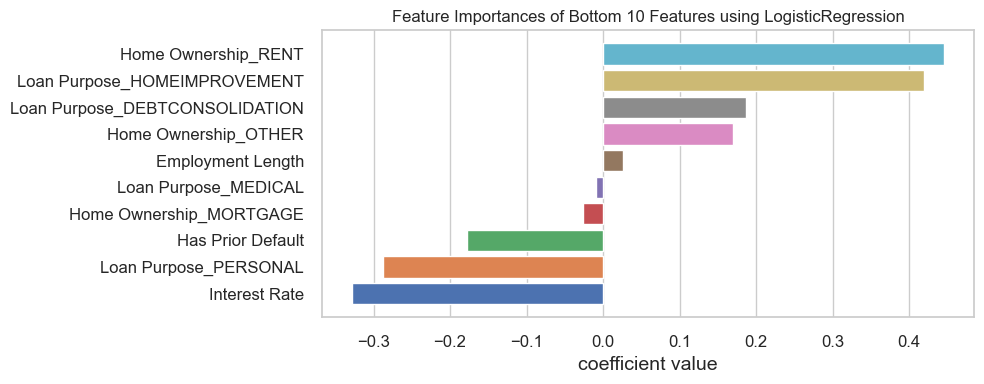







----------------------  support_vector_machine  ----------------------


              precision    recall  f1-score   support

           0       0.80      0.90      0.85     19831
           1       0.89      0.78      0.83     19831

    accuracy                           0.84     39662
   macro avg       0.85      0.84      0.84     39662
weighted avg       0.85      0.84      0.84     39662



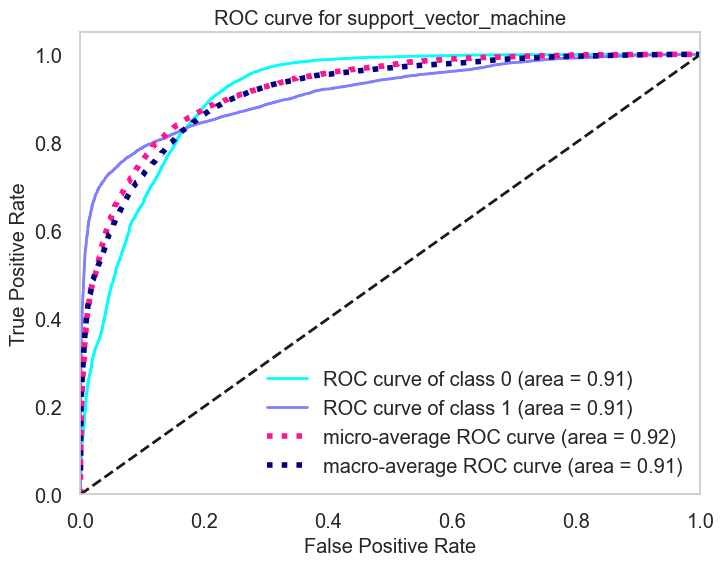

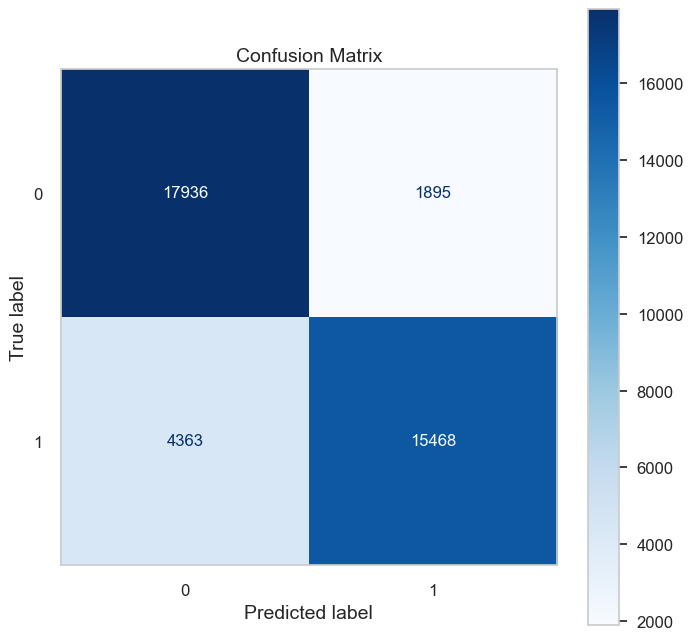



No feature importance for support_vector_machine






----------------------  decision_tree  ----------------------


              precision    recall  f1-score   support

           0       0.90      0.90      0.90     19831
           1       0.90      0.90      0.90     19831

    accuracy                           0.90     39662
   macro avg       0.90      0.90      0.90     39662
weighted avg       0.90      0.90      0.90     39662



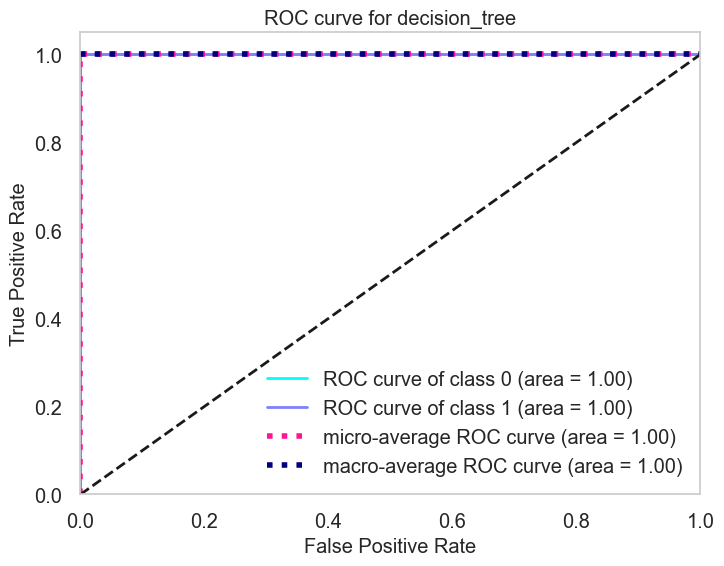

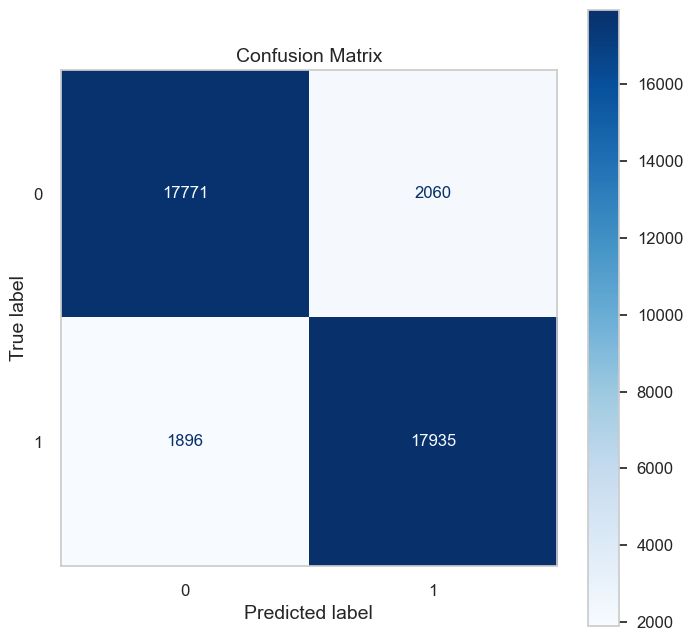

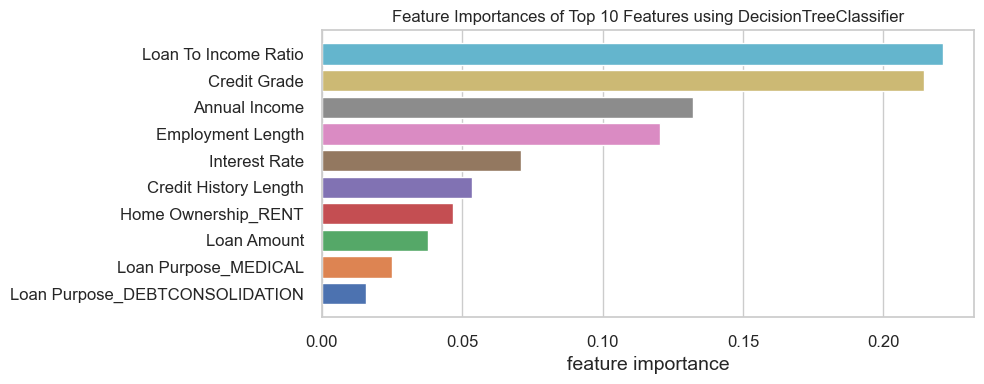

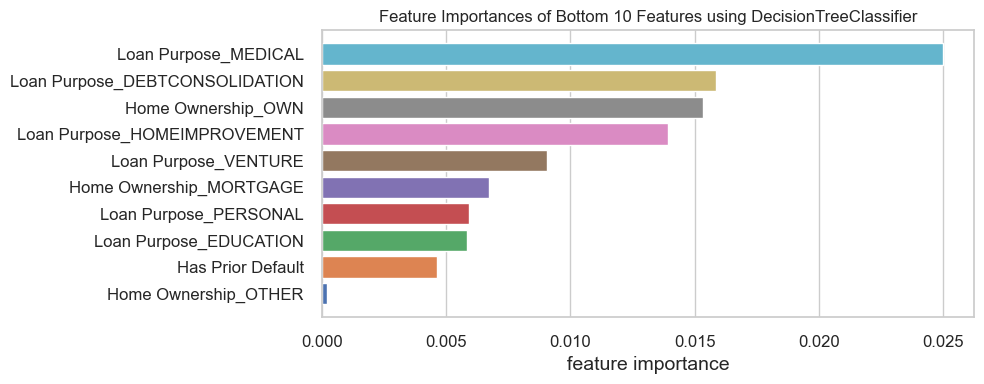







----------------------  random_forest  ----------------------


              precision    recall  f1-score   support

           0       0.92      0.98      0.95     19831
           1       0.98      0.91      0.94     19831

    accuracy                           0.94     39662
   macro avg       0.95      0.94      0.94     39662
weighted avg       0.95      0.94      0.94     39662



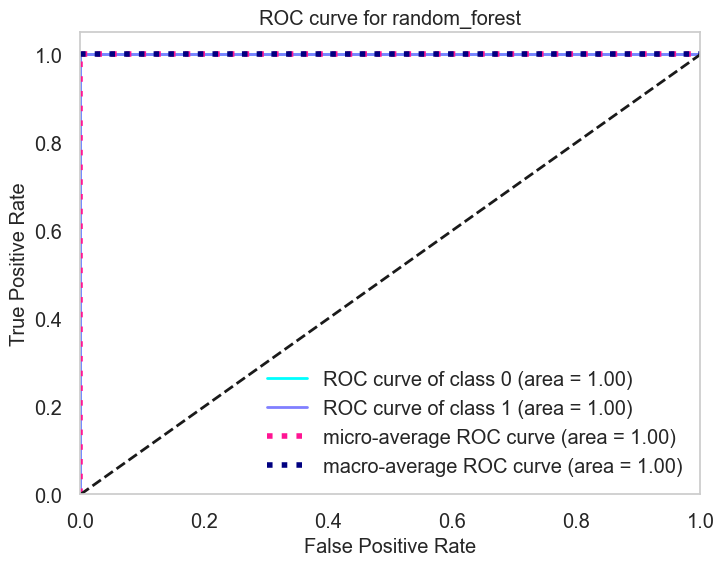

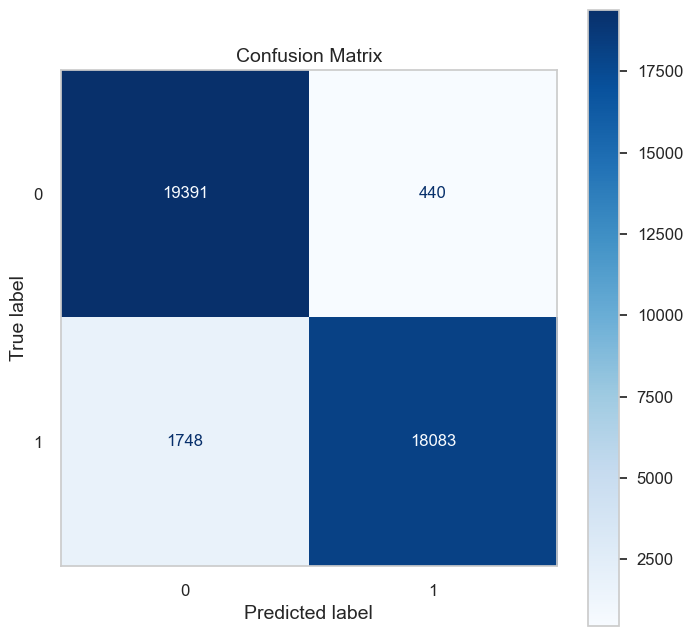

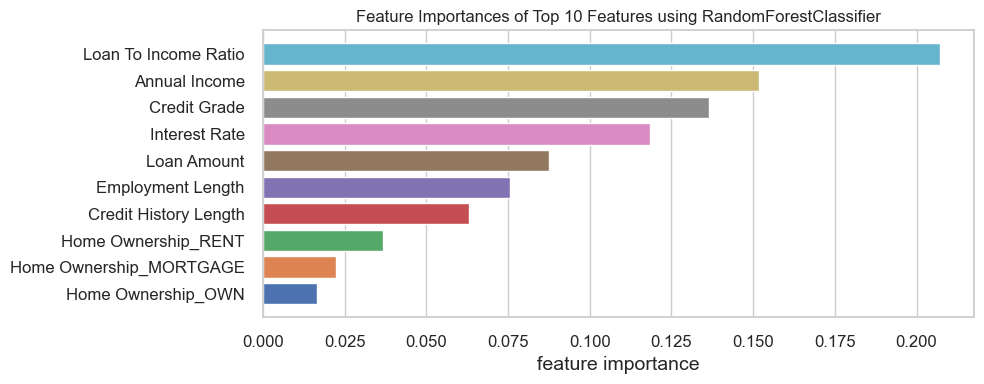

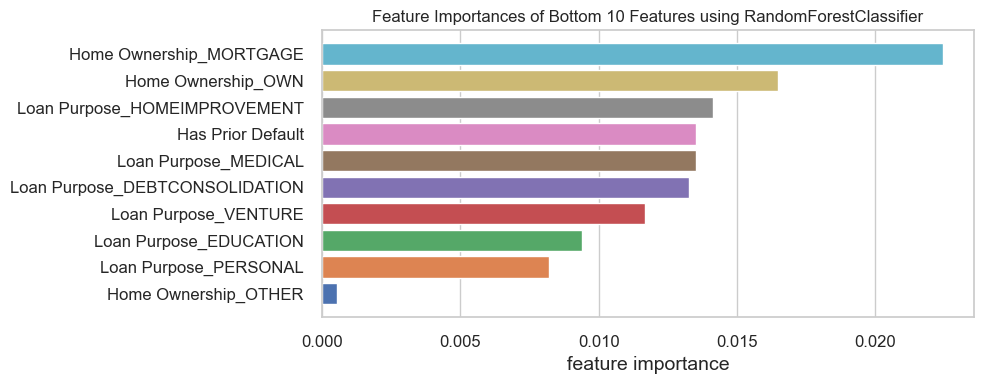







----------------------  gaussian_naive_bayes  ----------------------


              precision    recall  f1-score   support

           0       0.80      0.74      0.77     19831
           1       0.76      0.81      0.78     19831

    accuracy                           0.78     39662
   macro avg       0.78      0.78      0.78     39662
weighted avg       0.78      0.78      0.78     39662



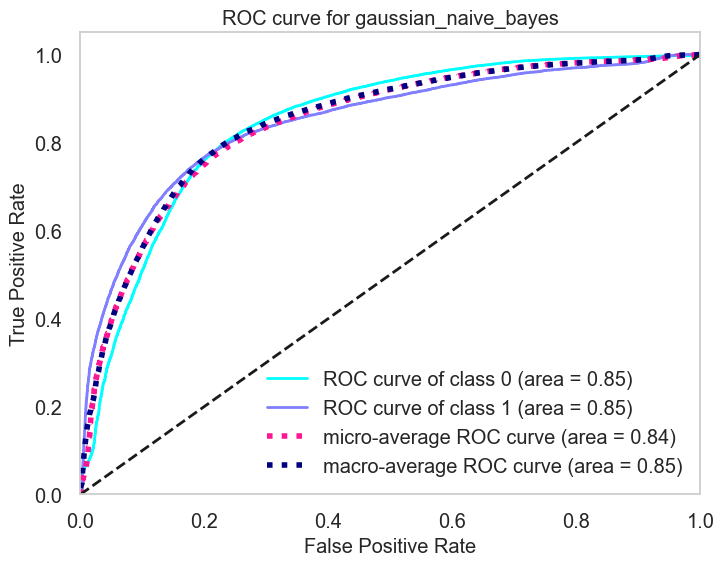

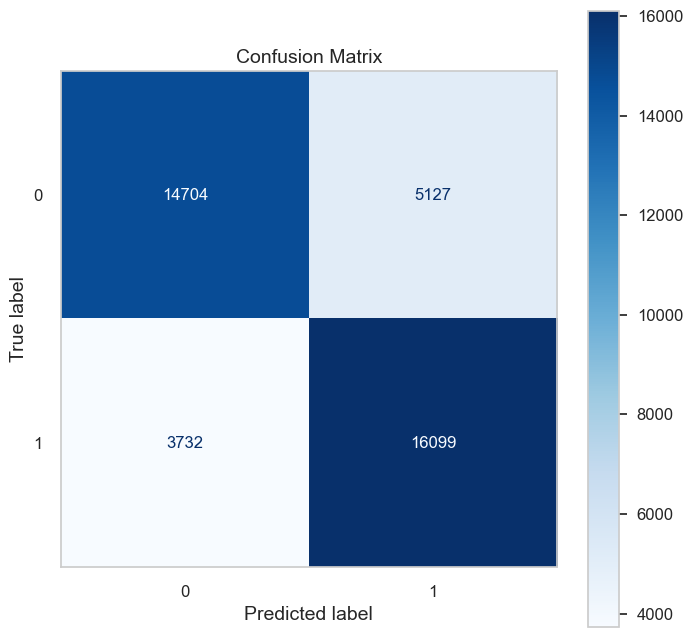



No feature importance for gaussian_naive_bayes






----------------------  k_nearest_neighbors  ----------------------


              precision    recall  f1-score   support

           0       0.93      0.84      0.88     19831
           1       0.85      0.94      0.89     19831

    accuracy                           0.89     39662
   macro avg       0.89      0.89      0.89     39662
weighted avg       0.89      0.89      0.89     39662



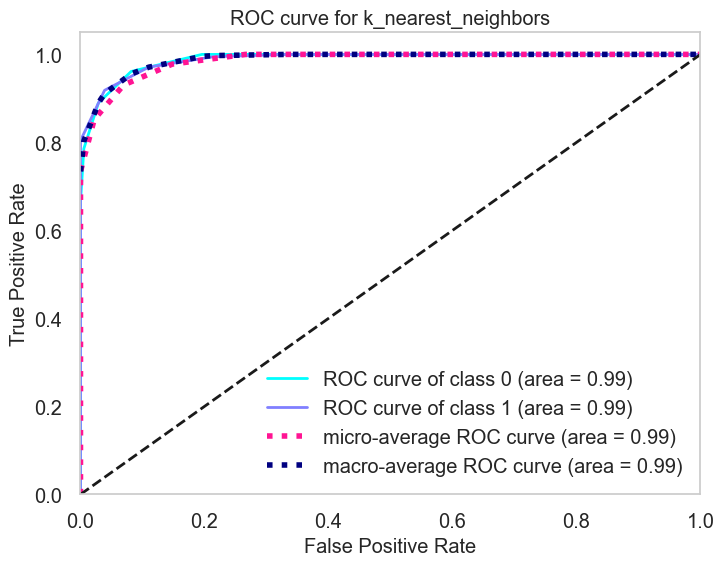

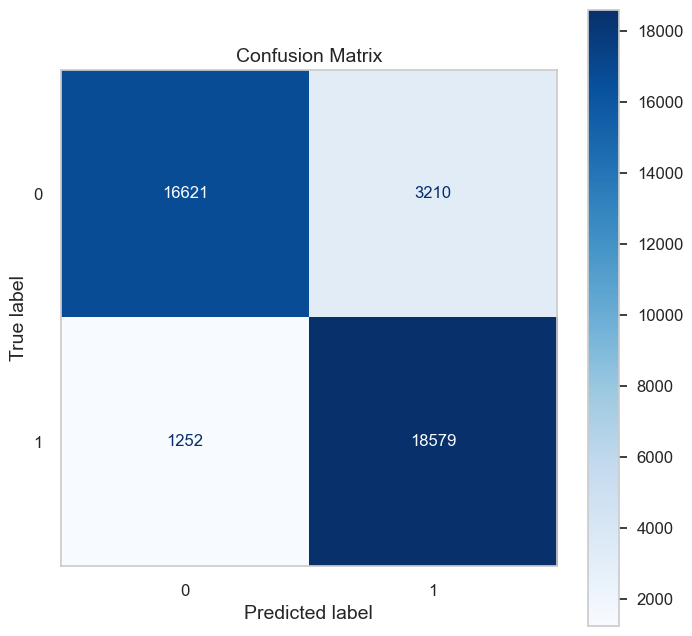



No feature importance for k_nearest_neighbors






----------------------  gradient_boosting  ----------------------


              precision    recall  f1-score   support

           0       0.87      0.94      0.90     19831
           1       0.94      0.85      0.89     19831

    accuracy                           0.90     39662
   macro avg       0.90      0.90      0.90     39662
weighted avg       0.90      0.90      0.90     39662



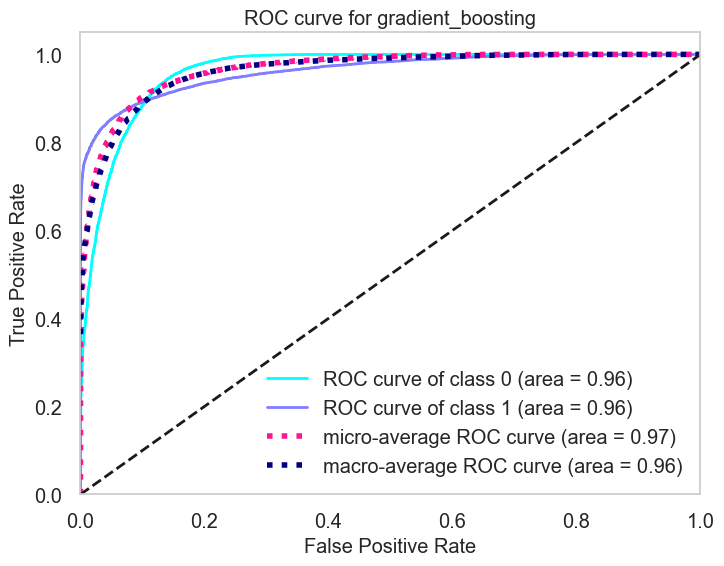

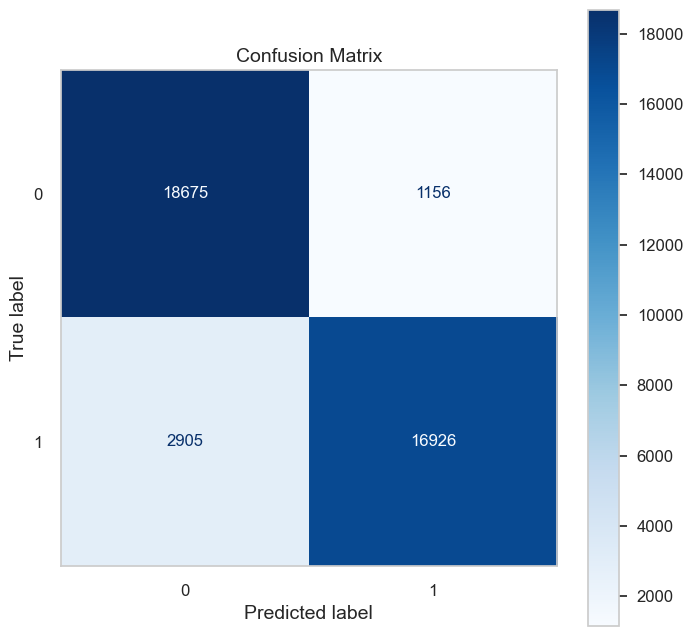

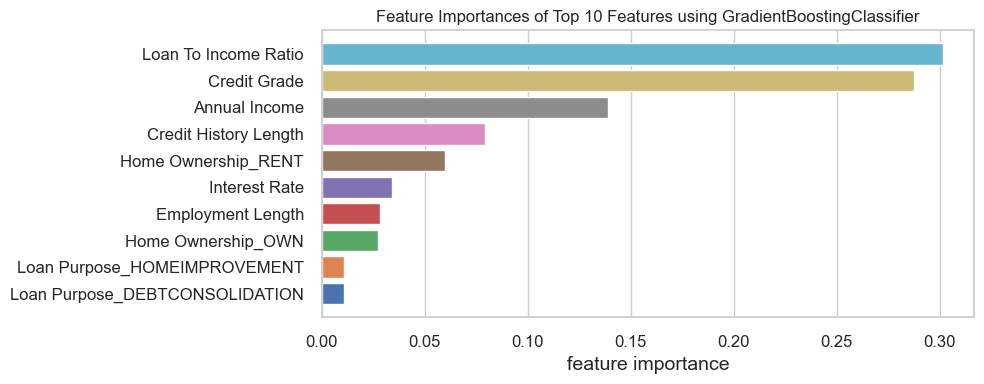

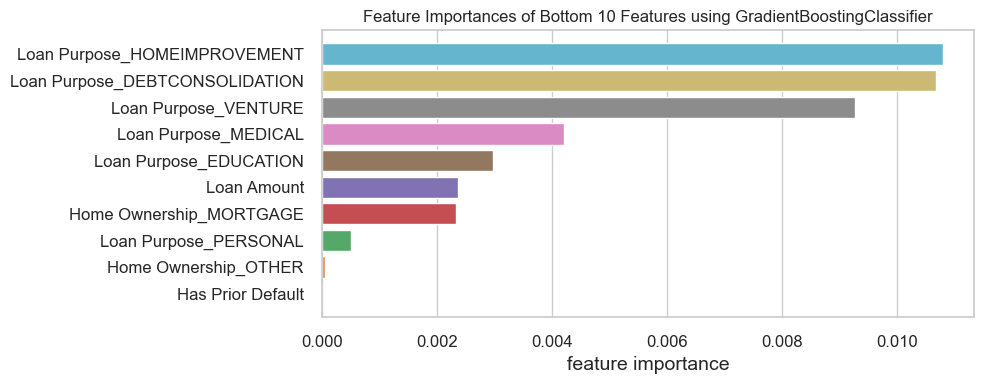







----------------------  linear_discriminant_analysis  ----------------------


              precision    recall  f1-score   support

           0       0.79      0.80      0.80     19831
           1       0.80      0.79      0.80     19831

    accuracy                           0.80     39662
   macro avg       0.80      0.80      0.80     39662
weighted avg       0.80      0.80      0.80     39662



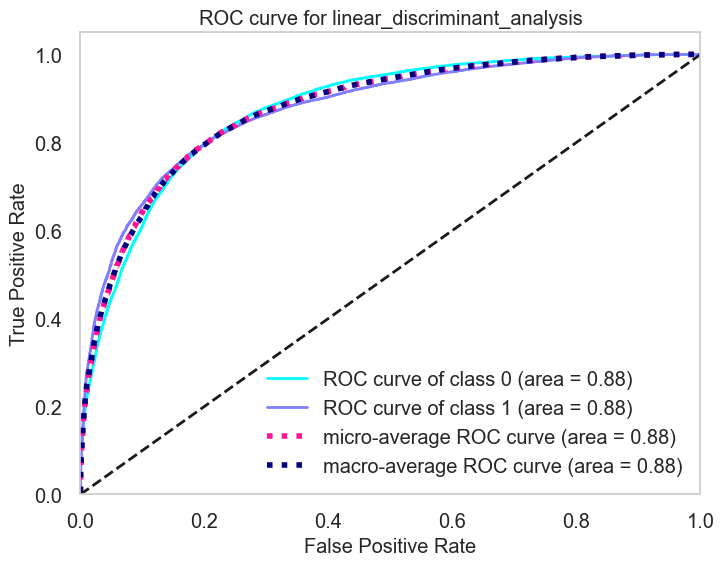

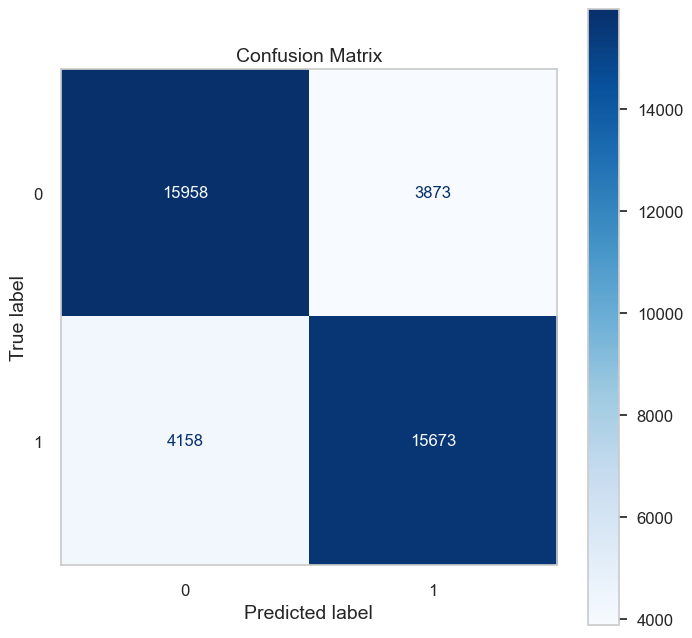

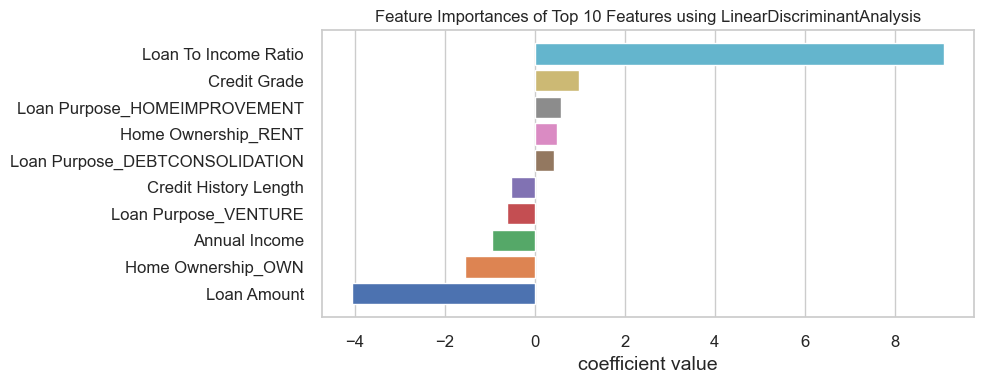

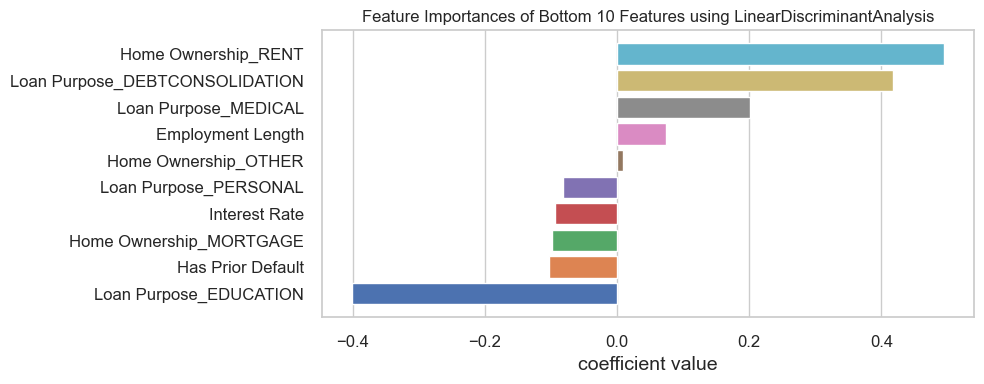







----------------------  bagging  ----------------------


              precision    recall  f1-score   support

           0       0.90      0.97      0.93     19831
           1       0.97      0.89      0.93     19831

    accuracy                           0.93     39662
   macro avg       0.94      0.93      0.93     39662
weighted avg       0.94      0.93      0.93     39662



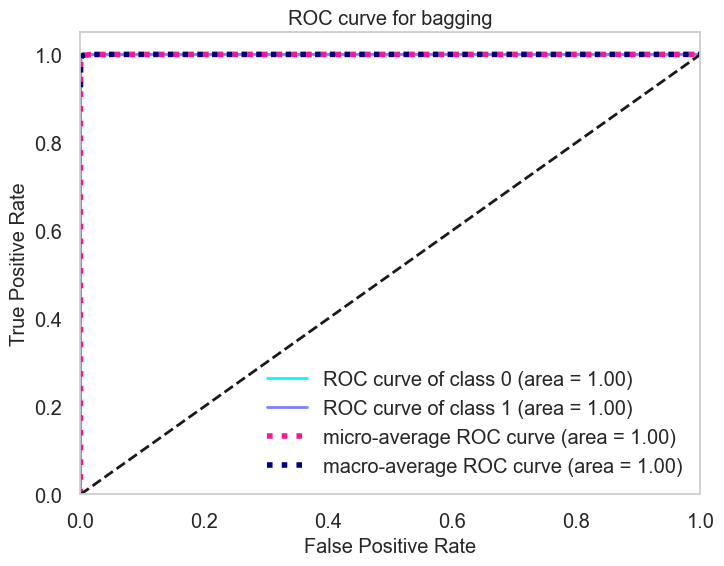

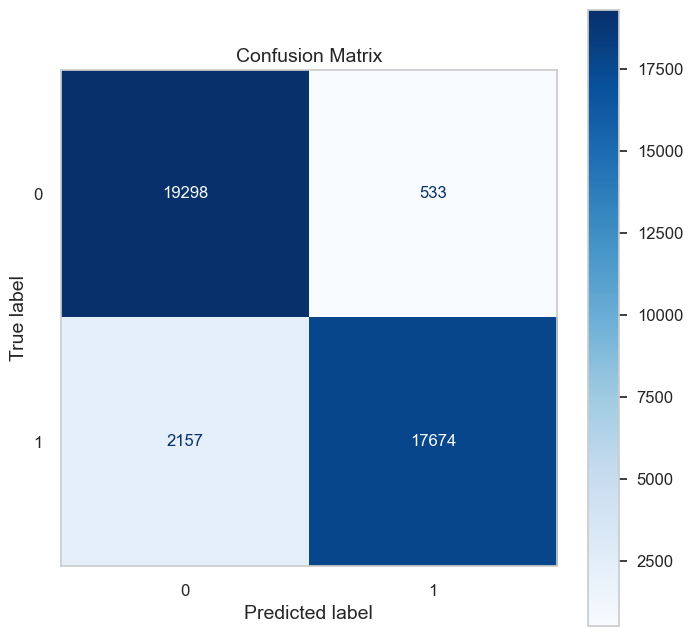



No feature importance for bagging






----------------------  neural_network  ----------------------


              precision    recall  f1-score   support

           0       0.82      0.92      0.87     19831
           1       0.91      0.80      0.85     19831

    accuracy                           0.86     39662
   macro avg       0.87      0.86      0.86     39662
weighted avg       0.87      0.86      0.86     39662



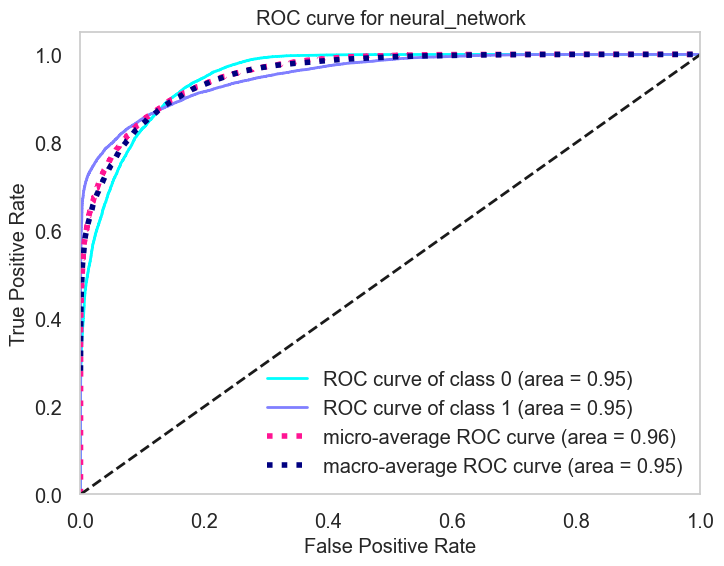

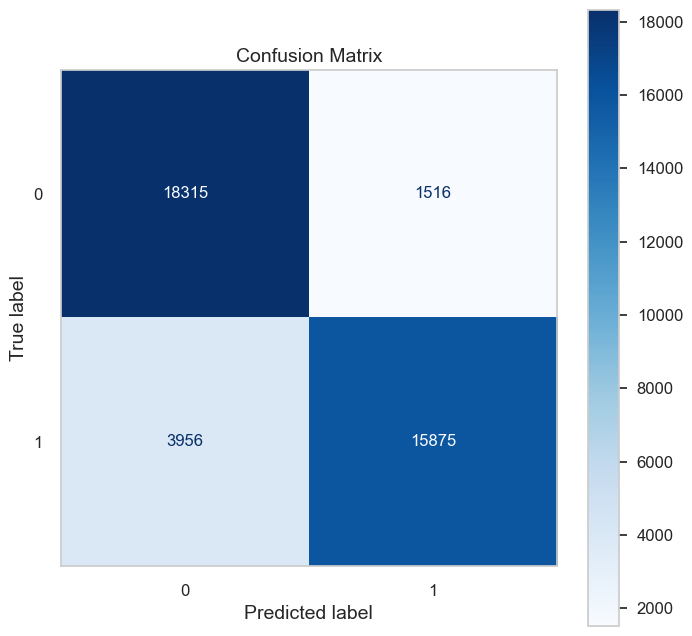



No feature importance for neural_network






----------------------  adaboost  ----------------------


              precision    recall  f1-score   support

           0       0.84      0.89      0.86     19831
           1       0.88      0.83      0.85     19831

    accuracy                           0.86     39662
   macro avg       0.86      0.86      0.86     39662
weighted avg       0.86      0.86      0.86     39662



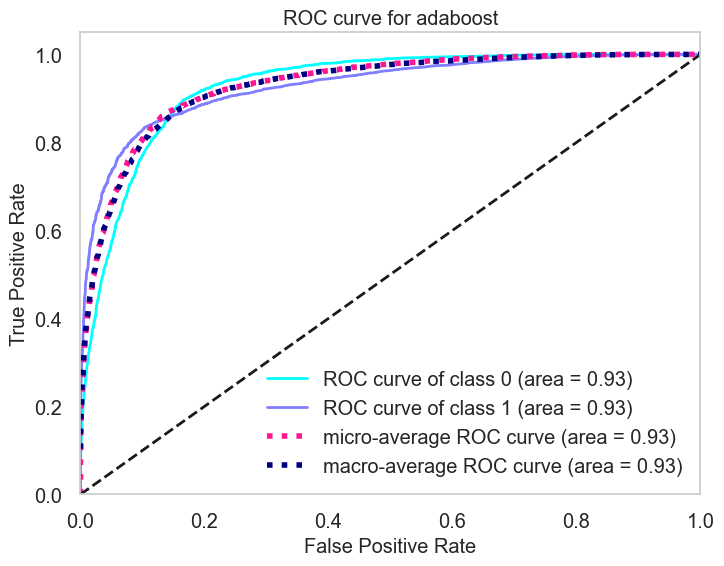

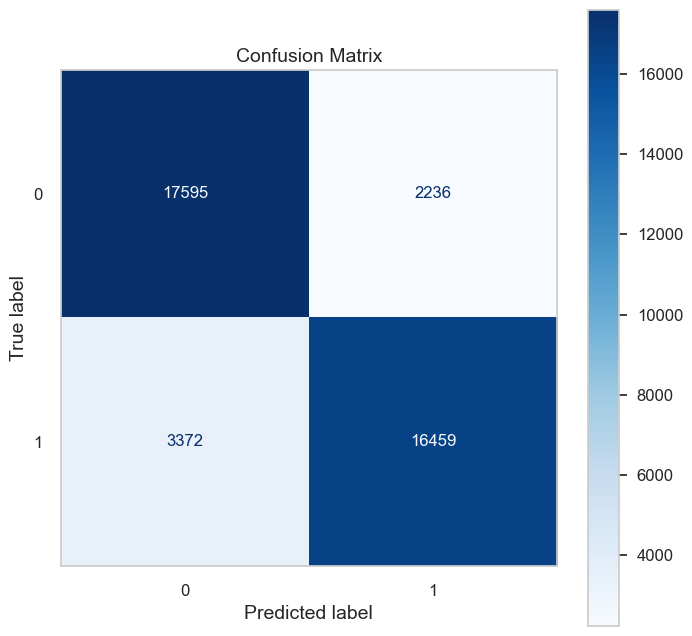

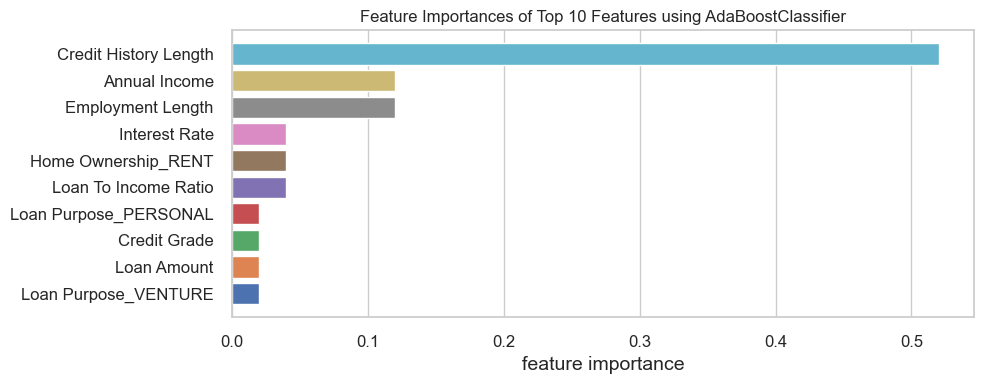

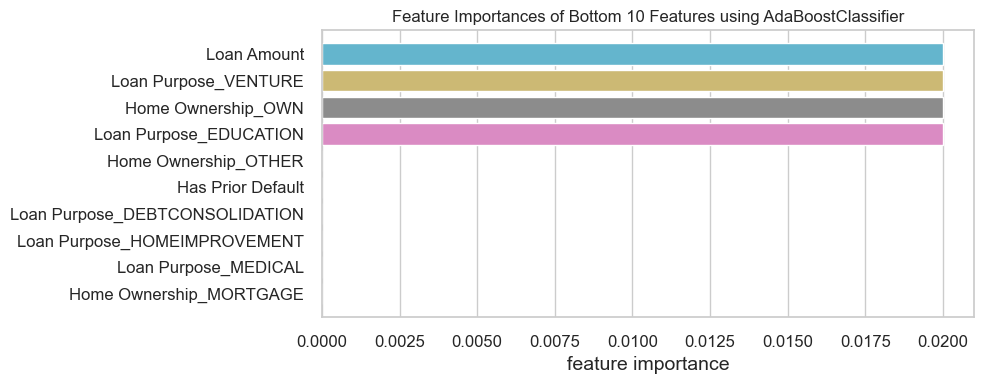







----------------------  extra_trees  ----------------------


              precision    recall  f1-score   support

           0       0.94      0.96      0.95     19831
           1       0.96      0.93      0.95     19831

    accuracy                           0.95     39662
   macro avg       0.95      0.95      0.95     39662
weighted avg       0.95      0.95      0.95     39662



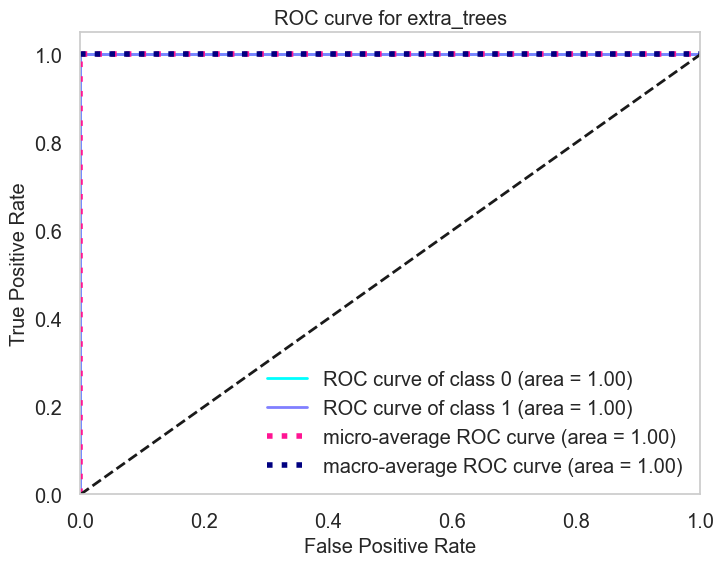

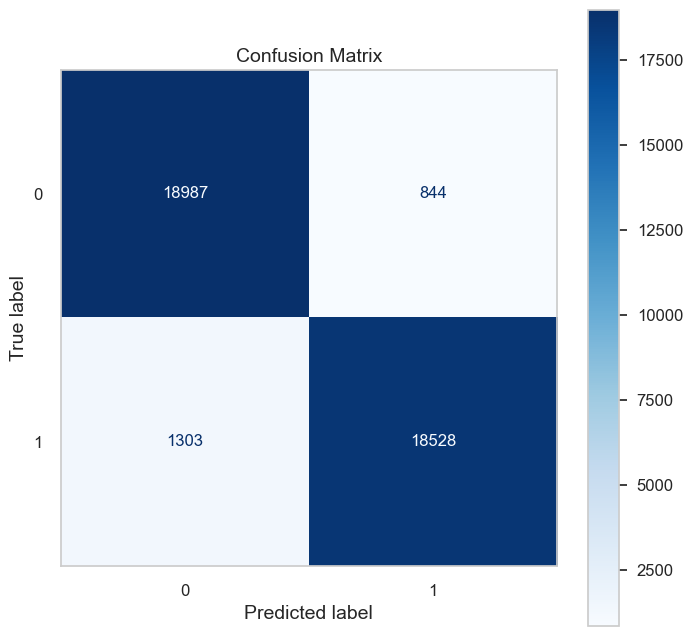

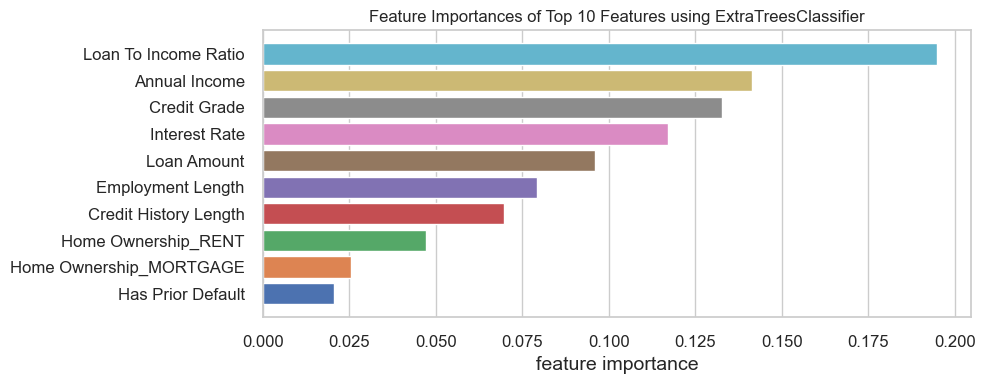

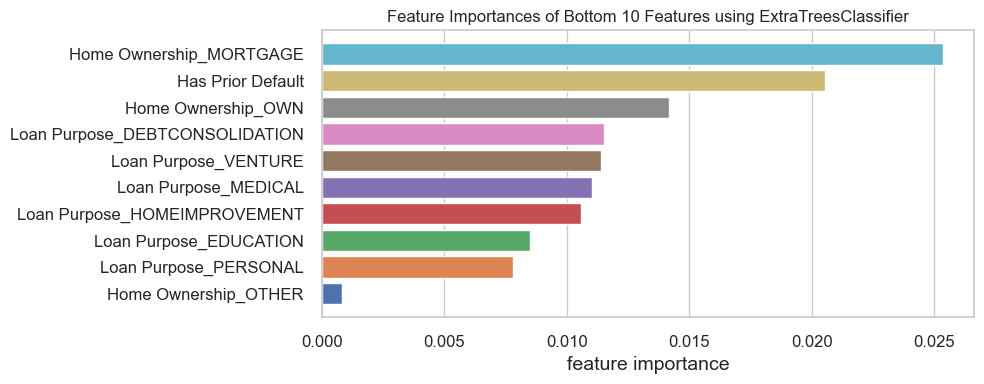

In [158]:
# loop over all the models
for model_name,model in classifiers.items():
    # title formatting
    print('\n')
    print('\n')
    print('  {}  '.center(50,'-').format(model_name))
    print('\n')
    # check if the folder for saving the model exists, if not create it
    folder_check_model()
    # train the model
    model_trn = train_model(model,model_name)
    # print the scores from the classification report
    score_func(model_trn, model_name)
    # plot the ROC curve
    roc_curve_func(model_trn,model_name)
    # plot the confusion matrix
    confusion_matrix_func(model_trn,model_name)
    # plot feature importance
    feat_importance_plot(model_trn, model_name)
    warnings.filterwarnings("ignore")

### Context and Model Selection Criteria for Credit Risk Prediction

In the context of finance and banking, **predicting credit risk** for individual borrowers plays a crucial role in risk management and profit optimization. The dataset used includes detailed borrower information such as age, annual income, home ownership type, employment length, credit history length, loan intent, loan grade (from A to G), loan amount, interest rate, loan-to-income ratio, and historical default records. Based on these features, the task is to classify whether a borrower is likely to **default (1)** or **not default (0)** on their loan.

In real-world applications, **misclassifying high-risk individuals as low-risk (false negatives)** can lead to significant financial losses for lenders. Therefore, an ideal model should prioritize **high recall for the default class**, while maintaining reasonable precision to avoid rejecting too many creditworthy customers. As a result, the **F1-score** (the harmonic mean of precision and recall) is selected as the primary evaluation metric. Additionally, inference speed and scalability are important considerations for deploying the model in production environments.##

## Recommended Model and Justification

Based on the evaluation of multiple algorithms, the **Extra Trees Classifier** emerges as the most suitable model for this task. It achieves **95% accuracy**, with a **precision of 0.96**, **recall of 0.93**, and **F1-score of 0.95**, indicating excellent performance in classifying both default and non-default cases. Compared to Random Forest, Extra Trees offers improved training speed and often better generalization due to its randomized splitting strategy.

With its high predictive power, strong generalization, and computational efficiency, the Extra Trees Classifier provides a robust and practical solution for **real-time credit risk assessment** in financial institutions.


## Evaluation of Feature Importances (ExtraTreesClassifier)

---

### Top 10 Most Important Features

| Feature                  | Comment |
|---------------------------|---------|
| **Loan To Income Ratio**  | Most influential feature; borrowers with higher ratios are riskier. |
| **Annual Income**         | High income reduces default risk. |
| **Credit Grade**          | Creditworthiness is a strong predictor of default. |
| **Interest Rate**         | Higher rates are usually associated with higher risk. |
| **Loan Amount**           | Larger loan amounts increase risk. |
| **Employment Length**     | Longer employment history indicates more stability. |
| **Credit History Length** | A longer history typically means better credit behavior. |
| **Home Ownership_RENT**   | Renters might have higher risk compared to owners. |
| **Home Ownership_MORTGAGE** | Mortgaged homeowners may have moderate stability. |
| **Has Prior Default**     | Past defaults significantly impact risk. |

**Summary:**  
The model heavily relies on financial ratios, income, credit status, and employment stability. **Loan To Income Ratio** is the strongest predictor.

---

### Bottom 10 Least Important Features

| Feature                         | Comment |
|----------------------------------|---------|
| **Home Ownership_MORTGAGE**      | Still somewhat important among lower-ranked features. |
| **Has Prior Default**            | Appears again here; small inconsistencies may exist due to feature encoding. |
| **Home Ownership_OWN**           | Owning a home is slightly correlated with lower risk. |
| **Loan Purpose_DEBTCONSOLIDATION** | Borrowers consolidating debt show certain risk patterns. |
| **Loan Purpose_VENTURE**         | Business ventures are riskier but less frequent. |
| **Loan Purpose_MEDICAL**         | Medical loans can have mixed risk profiles. |
| **Loan Purpose_HOMEIMPROVEMENT** | Home improvement loans typically indicate asset value increase. |
| **Loan Purpose_EDUCATION**       | Educational loans usually indicate future income potential. |
| **Loan Purpose_PERSONAL**        | Personal loans vary widely in risk based on purpose. |
| **Home Ownership_OTHER**         | Rare home ownership types have little predictive power. |

**Summary:**  
Secondary features such as specific **loan purposes** and detailed **home ownership categories** have relatively minor contributions. They are useful but not as critical as income and credit-related variables.

---

## Final Notes
- Focus on the **top 5 features** for primary model decisions.
- **Secondary features** could still be useful for fine-tuning thresholds or developing custom risk segments.
- Consider reducing the dimensionality by excluding very low-importance features if simplifying the model is a priority.

---

# VI) Test the final model on the test set

In [162]:
test_data_copy.head(5)

Age  Annual Income Home Ownership  Employment Length       Loan Purpose  \
0   24          28000            OWN               6.00    HOMEIMPROVEMENT   
1   27          64000           RENT               0.00           PERSONAL   
2   26          72000       MORTGAGE              10.00          EDUCATION   
3   23          27996           RENT               7.00  DEBTCONSOLIDATION   
4   30          44500           RENT               2.00            MEDICAL   

  Credit Grade  Loan Amount  Interest Rate  Loan Default  \
0            B        10000          10.37             0   
1            C        10000          15.27             0   
2            D        16000            NaN             0   
3            A        10000            NaN             1   
4            E        13000          16.32             1   

   Loan To Income Ratio Has Prior Default  Credit History Length  
0                  0.36                 N                      2  
1                  0.16                 Y                     10  
2                  0.22                 N                      3  
3                  0.36                 N                      2  
4                  0.29                 N                      6

In [163]:
test_data_prep = full_pipeline(test_data_copy)

In [164]:
# split the train data into X and y (target)
X_cc_test_prep, y_cc_test_prep = test_data_prep.loc[:, test_data_prep.columns != 'Loan Default'], test_data_prep['Loan Default'].astype('int64')

In [165]:
# train the model extra_trees
model_trn = train_model(classifiers['extra_trees'],'extra_trees')

In [166]:
final_predictions = model_trn.predict(X_cc_test_prep)

In [167]:
final_predictions.shape

(9884,)

In [168]:
n_correct = sum(final_predictions == y_cc_test_prep)

In [169]:
print(n_correct/len(final_predictions))

0.8457102387697288


# VII) Customer Segmentation

## 1) Data Preprocessing

In [172]:
def full_pipeline_seg(df):
    pipeline = Pipeline([
        ('imputer', ImputerWrapper()),
        ('drop_features', DropFeatures()),
        ('skewness_handler', SkewnessHandler()),
        ('binary_mapper', BinaryMapper()),
        ('ordinal_encoder', OrdinalEncoderWrapper()),
        ('one_hot_encoder', OneHotEncoderWrapper()),
        ('min_max_scaler', MinMaxScalerWrapper())
    ])
    
    df_processed = pipeline.fit_transform(df)
    return df_processed

In [173]:
train_data_seg = full_pipeline_seg(full_data)

In [174]:
train_data_seg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Annual Income                   32581 non-null  float64
 1   Employment Length               32581 non-null  float64
 2   Credit Grade                    32581 non-null  float64
 3   Loan Amount                     32581 non-null  float64
 4   Interest Rate                   32581 non-null  float64
 5   Loan Default                    32581 non-null  int64  
 6   Loan To Income Ratio            32581 non-null  float64
 7   Has Prior Default               32581 non-null  int64  
 8   Credit History Length           32581 non-null  float64
 9   Home Ownership_MORTGAGE         32581 non-null  float64
 10  Home Ownership_OTHER            32581 non-null  float64
 11  Home Ownership_OWN              32581 non-null  float64
 12  Home Ownership_RENT             

## 2) K-Means Clustering

In [176]:
X = np.asarray(train_data_seg)

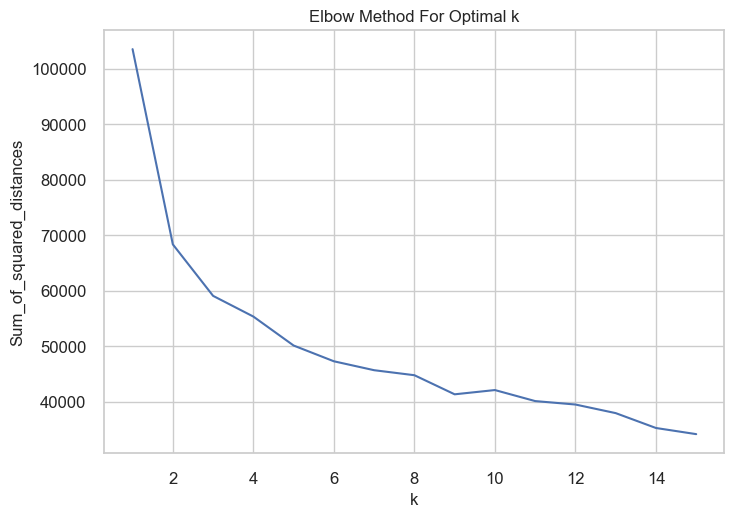

In [177]:
Sum_of_squared_distances = []
K = range(1,16)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [178]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

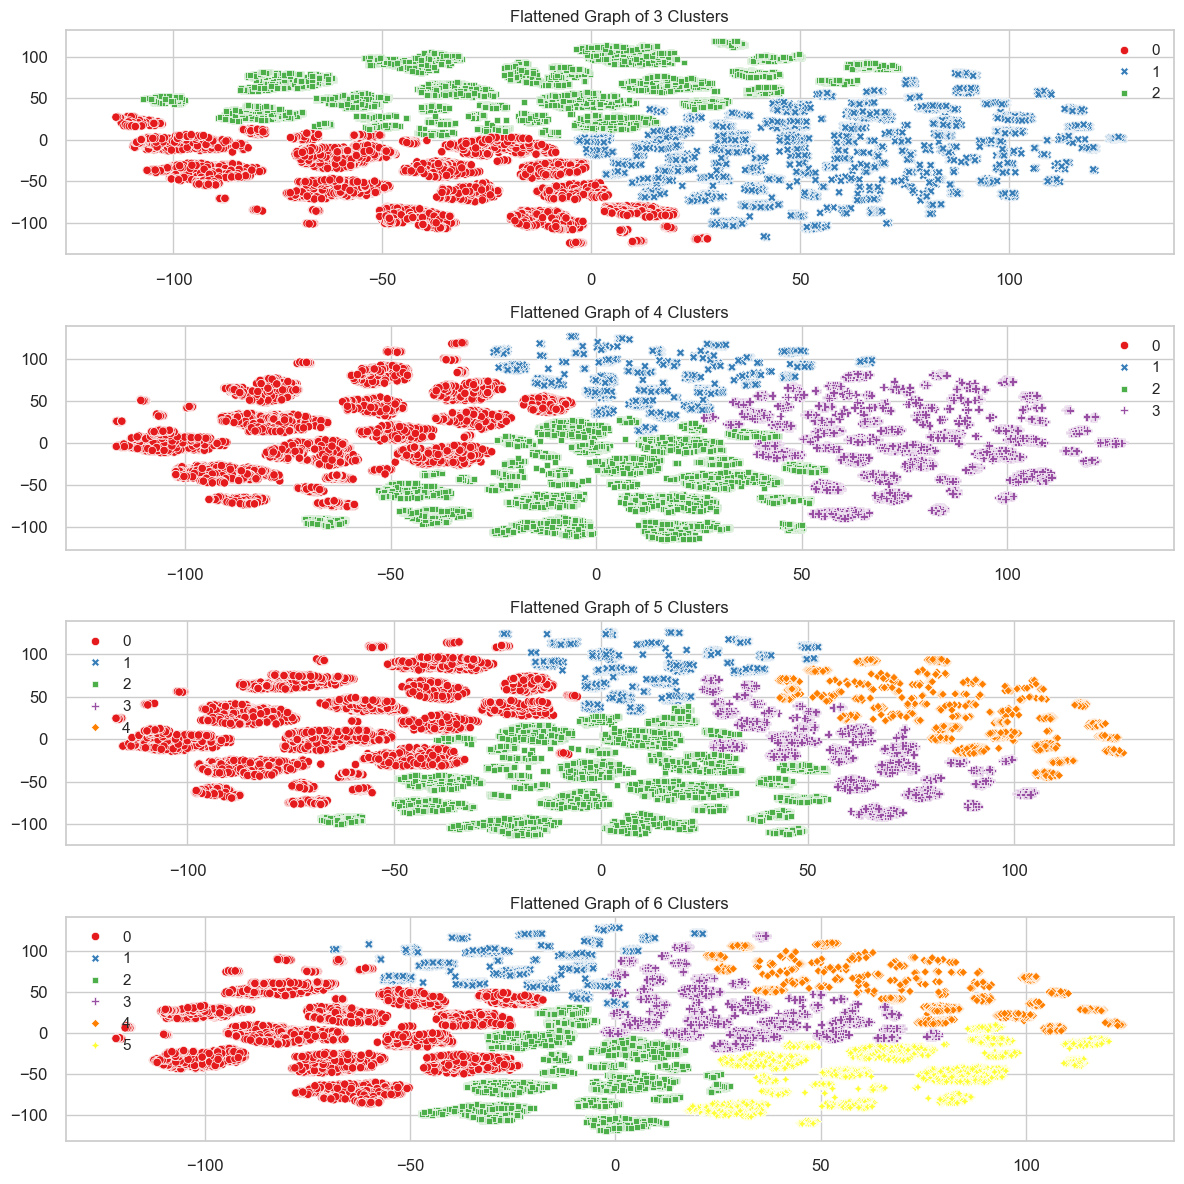

In [179]:
plt.figure(figsize=(12, 12))

# Subplot 1: K = 3
plt.subplot(4, 1, 1)
df_rfm_k3 = kmeans(train_data_seg, 3, train_data_seg)

# Subplot 2: K = 4
plt.subplot(4, 1, 2)
df_rfm_k4 = kmeans(train_data_seg, 4, train_data_seg)

# Subplot 3: K = 5
plt.subplot(4, 1, 3)
df_rfm_k5 = kmeans(train_data_seg, 5, train_data_seg)

# Subplot 4: K = 6
plt.subplot(4, 1, 4)
df_rfm_k6 = kmeans(train_data_seg, 6, train_data_seg)

plt.tight_layout()

## 3) Evaluating Model

In [181]:
for k in range(3, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    score = davies_bouldin_score(X, kmeans.labels_)
    print(f'k = {k}, Davies-Bouldin Score = {score:.4f}')


k = 3, Davies-Bouldin Score = 1.9095
k = 4, Davies-Bouldin Score = 1.8822
k = 5, Davies-Bouldin Score = 2.2191
k = 6, Davies-Bouldin Score = 1.8564


K-Means 4 clusters has lowest davies bouldin score than other cluster. Therefore the optimum cluster is 4.

In [183]:
df_rfm_k4.head()

Annual Income  Employment Length  Credit Grade  Loan Amount  Interest Rate  \
0           0.14               1.00          3.00         1.00           0.60   
1           0.03               0.04          1.00         0.08           0.32   
2           0.03               0.01          2.00         0.39           0.42   
3           0.15               0.03          2.00         1.00           0.55   
4           0.13               0.07          2.00         1.00           0.50   

   Loan Default  Loan To Income Ratio  Has Prior Default  \
0             1                  0.71                  1   
1             0                  0.12                  0   
2             1                  0.69                  0   
3             1                  0.64                  0   
4             1                  0.66                  1   

   Credit History Length  Home Ownership_MORTGAGE  Home Ownership_OTHER  \
0                   0.04                     0.00                  0.00   
1                   0.00                     0.00                  0.00   
2                   0.04                     1.00                  0.00   
3                   0.00                     0.00                  0.00   
4                   0.07                     0.00                  0.00   

   Home Ownership_OWN  Home Ownership_RENT  Loan Purpose_DEBTCONSOLIDATION  \
0                0.00                 1.00                            0.00   
1                1.00                 0.00                            0.00   
2                0.00                 0.00                            0.00   
3                0.00                 1.00                            0.00   
4                0.00                 1.00                            0.00   

   Loan Purpose_EDUCATION  Loan Purpose_HOMEIMPROVEMENT  Loan Purpose_MEDICAL  \
0                    0.00                          0.00                  0.00   
1                    1.00                          0.00                  0.00   
2                    0.00                          0.00                  1.00   
3                    0.00                          0.00                  1.00   
4                    0.00                          0.00                  1.00   

   Loan Purpose_PERSONAL  Loan Purpose_VENTURE  Cluster  
0                   1.00                  0.00        3  
1                   0.00                  0.00        2  
2                   0.00                  0.00        1  
3                   0.00                  0.00        3  
4                   0.00                  0.00        3

In [184]:
df_rfm_k4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Annual Income                   32581 non-null  float64
 1   Employment Length               32581 non-null  float64
 2   Credit Grade                    32581 non-null  float64
 3   Loan Amount                     32581 non-null  float64
 4   Interest Rate                   32581 non-null  float64
 5   Loan Default                    32581 non-null  int64  
 6   Loan To Income Ratio            32581 non-null  float64
 7   Has Prior Default               32581 non-null  int64  
 8   Credit History Length           32581 non-null  float64
 9   Home Ownership_MORTGAGE         32581 non-null  float64
 10  Home Ownership_OTHER            32581 non-null  float64
 11  Home Ownership_OWN              32581 non-null  float64
 12  Home Ownership_RENT             

In [185]:
test = full_data.copy()

In [186]:
test.loc[df_rfm_k4.index, 'Cluster'] = df_rfm_k4['Cluster']
test['Cluster'] = test['Cluster'].astype('int32')
test.head()


Age  Annual Income Home Ownership  Employment Length Loan Purpose  \
0   22          59000           RENT             123.00     PERSONAL   
1   21           9600            OWN               5.00    EDUCATION   
2   25           9600       MORTGAGE               1.00      MEDICAL   
3   23          65500           RENT               4.00      MEDICAL   
4   24          54400           RENT               8.00      MEDICAL   

  Credit Grade  Loan Amount  Interest Rate  Loan Default  \
0            D        35000          16.02             1   
1            B         1000          11.14             0   
2            C         5500          12.87             1   
3            C        35000          15.23             1   
4            C        35000          14.27             1   

   Loan To Income Ratio Has Prior Default  Credit History Length  Cluster  
0                  0.59                 Y                      3        3  
1                  0.10                 N                      2        2  
2                  0.57                 N                      3        1  
3                  0.53                 N                      2        3  
4                  0.55                 Y                      4        3

In [187]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    32581 non-null  int64  
 1   Annual Income          32581 non-null  int64  
 2   Home Ownership         32581 non-null  object 
 3   Employment Length      32581 non-null  float64
 4   Loan Purpose           32581 non-null  object 
 5   Credit Grade           32581 non-null  object 
 6   Loan Amount            32581 non-null  int64  
 7   Interest Rate          32581 non-null  float64
 8   Loan Default           32581 non-null  int64  
 9   Loan To Income Ratio   32581 non-null  float64
 10  Has Prior Default      32581 non-null  object 
 11  Credit History Length  32581 non-null  int64  
 12  Cluster                32581 non-null  int32  
dtypes: float64(3), int32(1), int64(5), object(4)
memory usage: 3.1+ MB


Number of records per Cluster:
 Cluster
0    10406
1     3934
2    10822
3     7419
Name: count, dtype: int64

 Average of numerical features by Cluster:
          Age  Annual Income  Employment Length  Loan Amount  Interest Rate  \
Cluster                                                                       
0       27.88       78001.42               5.89      9871.60           8.90   
1       28.19       84524.63               5.71     11866.37          14.21   
2       27.47       55368.44               4.00      8664.45           9.70   
3       27.66       55180.58               3.92      9335.28          14.19   

         Loan Default  Loan To Income Ratio  Credit History Length  
Cluster                                                             
0                0.06                  0.15                   5.87  
1                0.29                  0.16                   6.04  
2                0.20                  0.18                   5.66  
3                0.43     

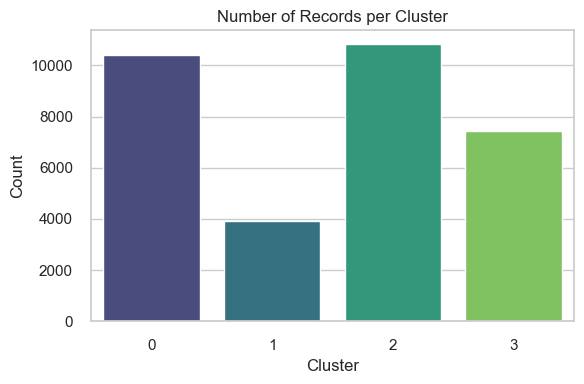

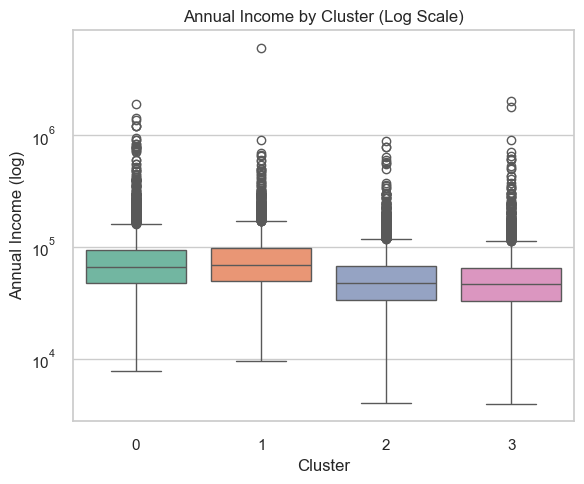

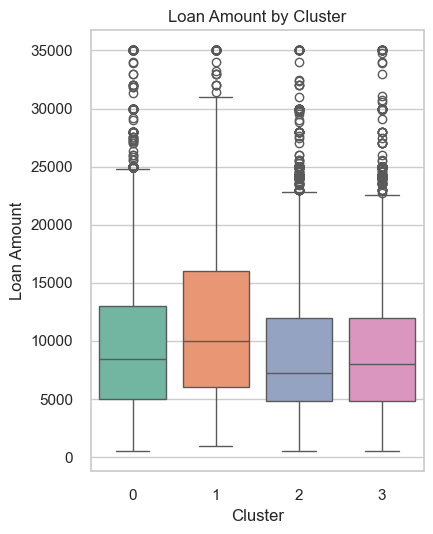

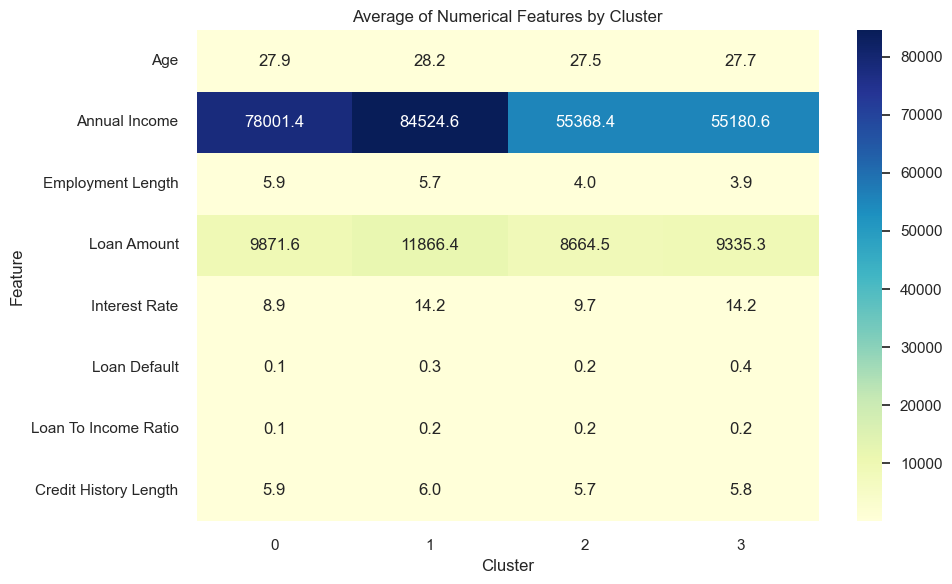

In [188]:
sns.set(style="whitegrid")

cluster_counts = test['Cluster'].value_counts().sort_index()
print("Number of records per Cluster:\n", cluster_counts)

print("\n Average of numerical features by Cluster:")
print(test.groupby('Cluster').mean(numeric_only=True))

plt.figure(figsize=(6, 4))
sns.countplot(data=test, x='Cluster', palette='viridis')
plt.title('Number of Records per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
sns.boxplot(data=test, x='Cluster', y='Annual Income', palette='Set2')
plt.yscale('log')  # Log scale
plt.title('Annual Income by Cluster (Log Scale)')
plt.xlabel('Cluster')
plt.ylabel('Annual Income (log)')
plt.tight_layout()
plt.show()

plt.subplot(1, 2, 2)
sns.boxplot(data=test, x='Cluster', y='Loan Amount', palette='Set2')
plt.title('Loan Amount by Cluster')

plt.tight_layout()
plt.show()

cluster_mean = test.groupby('Cluster').mean(numeric_only=True)

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_mean.T, annot=True, fmt=".1f", cmap='YlGnBu')
plt.title('Average of Numerical Features by Cluster')
plt.ylabel('Feature')
plt.xlabel('Cluster')
plt.tight_layout()
plt.show()

## 4) Recommendation

### Detailed Evaluation of Customer Clusters

---

### Cluster 0 – Low Risk Group

**Characteristics:**
- Average Age: **27.88**
- Annual Income: **78,001** (2nd highest)
- Employment Length: **5.89 years** (highest)
- Loan Amount: **9,872**
- Interest Rate: **8.90%** (lowest)
- Loan-to-Income Ratio: **0.15**
- Credit History Length: **5.87 years**
- Default Rate: **6%**

**Assessment:**
- This group is **very reliable**: high income, reasonable borrowing, and stable credit.
- Ideal for **fast approval** or **preferential interest rates**.

---

### Cluster 1 – Medium-High Risk Group

**Characteristics:**
- Average Age: **28.19** (highest)
- Annual Income: **84,525** (highest)
- Employment Length: **5.71 years**
- Loan Amount: **11,866** (highest)
- Interest Rate: **14.21%** (very high)
- Loan-to-Income Ratio: **0.16**
- Credit History Length: **6.04 years** (longest)
- Default Rate: **29%**

**Assessment:**
- Despite strong income and experience, the **high loan amount and interest rate** suggest increased risk.
- Possibly includes customers with complex borrowing histories.
- Should be **carefully assessed** before approval.

---

### Cluster 2 – Medium Risk Group

**Characteristics:**
- Average Age: **27.47**
- Annual Income: **55,368** (low)
- Employment Length: **4.00 years**
- Loan Amount: **8,664** (lowest)
- Interest Rate: **9.70%**
- Loan-to-Income Ratio: **0.18**
- Credit History Length: **5.66 years**
- Default Rate: **20%**

**Assessment:**
- Younger and less experienced borrowers, but with smaller loan amounts.
- Moderate risk overall.
- Could be a **developing customer segment**, manageable with light risk controls.

---

### Cluster 3 – High Risk Group

**Characteristics:**
- Average Age: **27.66**
- Annual Income: **55,181** (low)
- Employment Length: **3.92 years** (lowest)
- Loan Amount: **9,335**
- Interest Rate: **14.19%**
- Loan-to-Income Ratio: **0.19** (highest)
- Credit History Length: **5.80 years**
- Default Rate: **43%**

**Assessment:**
- This group is **very high risk**: low income, high borrowing, high interest, weak employment profile.
- Should be approached with **strict risk management**, e.g. co-signers, loan caps, or stricter eligibility.

---

# VIII) Save final dataset

In [192]:
import joblib
import pandas as pd

# Load model
model_path = 'C:/Users/thanh/OneDrive/Desktop/New Project/Banking/saved_models/extra_trees/extra_trees_model.sav'
extra_trees_model = joblib.load(model_path)

# Copy và xử lý dữ liệu
df = full_data.copy()
def final_full_pipeline(df):
    pipeline = Pipeline([
        ('imputer', ImputerWrapper()),
        ('drop_features', DropFeatures()),
        ('skewness_handler', SkewnessHandler()),
        ('binary_mapper', BinaryMapper()),
        ('ordinal_encoder', OrdinalEncoderWrapper()),
        ('one_hot_encoder', OneHotEncoderWrapper()),
        ('min_max_scaler', MinMaxScalerWrapper())
    ])
    
    df_processed = pipeline.fit_transform(df)
    return df_processed
    
data_processed = final_full_pipeline(df)

# Tách X, y
X_data_processed = data_processed.drop(columns='Loan Default')
y_data_processed = data_processed['Loan Default'].astype('int64')

# Dự đoán
y_pred = extra_trees_model.predict(X_data_processed)
y_proba = extra_trees_model.predict_proba(X_data_processed)

# Gán kết quả vào df gốc
df['Predicted Default'] = y_pred
df['Prob Non-Default'] = y_proba[:, 0]
df['Prob Default'] = y_proba[:, 1]

# Gán cluster (nếu có)
df.loc[df_rfm_k4.index, 'Cluster'] = df_rfm_k4['Cluster']
df['Cluster'] = test['Cluster'].astype('int32')

In [193]:
# Chuyển các cột 1/0 thành 'Yes'/'No'
df['Loan Default'] = df['Loan Default'].map({1: 'Yes', 0: 'No'})
df['Predicted Default'] = df['Predicted Default'].map({1: 'Yes', 0: 'No'})

# Chuyển cột 'Has Prior Default' từ 'Y'/'N' thành 'Yes'/'No'
df['Has Prior Default'] = df['Has Prior Default'].map({'Y': 'Yes', 'N': 'No'})

In [194]:
df.head()

Age  Annual Income Home Ownership  Employment Length Loan Purpose  \
0   22          59000           RENT             123.00     PERSONAL   
1   21           9600            OWN               5.00    EDUCATION   
2   25           9600       MORTGAGE               1.00      MEDICAL   
3   23          65500           RENT               4.00      MEDICAL   
4   24          54400           RENT               8.00      MEDICAL   

  Credit Grade  Loan Amount  Interest Rate Loan Default  Loan To Income Ratio  \
0            D        35000          16.02          Yes                  0.59   
1            B         1000          11.14           No                  0.10   
2            C         5500          12.87          Yes                  0.57   
3            C        35000          15.23          Yes                  0.53   
4            C        35000          14.27          Yes                  0.55   

  Has Prior Default  Credit History Length Predicted Default  \
0               Yes                      3               Yes   
1                No                      2                No   
2                No                      3               Yes   
3                No                      2               Yes   
4               Yes                      4               Yes   

   Prob Non-Default  Prob Default  Cluster  
0              0.14          0.86        3  
1              0.86          0.14        2  
2              0.09          0.91        1  
3              0.02          0.98        3  
4              0.02          0.98        3

In [195]:
df.shape

(32581, 16)

In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    32581 non-null  int64  
 1   Annual Income          32581 non-null  int64  
 2   Home Ownership         32581 non-null  object 
 3   Employment Length      32581 non-null  float64
 4   Loan Purpose           32581 non-null  object 
 5   Credit Grade           32581 non-null  object 
 6   Loan Amount            32581 non-null  int64  
 7   Interest Rate          32581 non-null  float64
 8   Loan Default           32581 non-null  object 
 9   Loan To Income Ratio   32581 non-null  float64
 10  Has Prior Default      32581 non-null  object 
 11  Credit History Length  32581 non-null  int64  
 12  Predicted Default      32581 non-null  object 
 13  Prob Non-Default       32581 non-null  float64
 14  Prob Default           32581 non-null  float64
 15  Cl